In [1]:
# ----------------------------------------------------------
# Import Libraries
# ----------------------------------------------------------

from __future__ import annotations

import os
import sys
import configparser
import json
import itertools

import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from pathlib import Path
from typing import Dict, List, Set, Tuple, Optional, Sequence, Mapping, Any, Iterable
from collections import defaultdict
from dataclasses import dataclass
from dataclasses import replace

from scipy.stats import norm
from scipy.stats import f as f_dist
from scipy.integrate import solve_ivp

from joblib import Parallel, delayed
from tqdm.auto import tqdm


seed = 8
np.random.seed(seed)
# ---------------------------------------------------------------------
# Project paths
# ---------------------------------------------------------------------

def _resolve_top_dir() -> Path:
    """Return project Root directory (folder that contains 0-Config, 0-Data, 8-Results)."""
    here = Path.cwd()
    # Heuristic: walk up until we see 0-Config and 8-Results
    for p in [here] + list(here.parents):
        if (p / "0-Config").exists() and (p / "8-Results").exists():
            return p
    # fallback: assume current dir is root
    return here

TOP_DIR = _resolve_top_dir()
CONFIG_DIR = TOP_DIR / "0-Config"
RESULTS_DIR = TOP_DIR / "8-Results"
DATA_DIR = TOP_DIR / "0-Data"

# Sampling methods to scan (folder names under each case)
METHODS = [
    "Sampling_AllFreeNonInformative",
    "Sampling_AllFreePriors",
    "Sampling_AllFreeTight",
    "Sampling_Regular",
    "Sampling_FixedNoIdentifiability",
]

# Parameters that are always fixed in your workflows
ALWAYS_FIXED: Set[str] = {"i_SS_X_I", "i_SS_X_S", "i_SS_BM"}

# ---------------------------------------------------------------------
# Imports from your model code (under 0-Libs)
# ---------------------------------------------------------------------

libs_dir = str(TOP_DIR / "0-Libs")
if libs_dir not in sys.path:
    sys.path.append(libs_dir)

from plant_config import get_reactor_initial_values    # noqa: E402
from asm3_model import ode_system_wrapper              # noqa: E402



c:\Users\ruanv\anaconda3\envs\thesisClone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---------------------------------------------------------------------
# Config helpers
# ---------------------------------------------------------------------

_cfg = configparser.ConfigParser()
_cfg.read(CONFIG_DIR / "config.ini")

# True parameter dictionary (as in your analysis file)
TRUE_THETA = {
    'k_H'      : float(_cfg['TRUEPARAMS']['true_param_k_H']),
    'K_X'      : float(_cfg['TRUEPARAMS']['true_param_K_X']),
    'k_STO'    : float(_cfg['TRUEPARAMS']['true_param_small_k_STO']),
    'eta_NOX'  : float(_cfg['TRUEPARAMS']['true_param_eta_NOX']),
    'K_O2'     : float(_cfg['TRUEPARAMS']['true_param_K_O2']),
    'K_NOX'    : float(_cfg['TRUEPARAMS']['true_param_K_NOX']),
    'K_S'      : float(_cfg['TRUEPARAMS']['true_param_K_S']),
    'K_STO'    : float(_cfg['TRUEPARAMS']['true_param_big_K_STO']),
    'mu_H'     : float(_cfg['TRUEPARAMS']['true_param_mu_H']),
    'K_NH4'    : float(_cfg['TRUEPARAMS']['true_param_K_NH4']),
    'K_ALK'    : float(_cfg['TRUEPARAMS']['true_param_K_ALK']),
    'b_H_O2'   : float(_cfg['TRUEPARAMS']['true_param_b_H_O2']),
    'b_H_NOX'  : float(_cfg['TRUEPARAMS']['true_param_b_H_NOX']),
    'b_STO_O2' : float(_cfg['TRUEPARAMS']['true_param_b_STO_O2']),
    'b_STO_NOX': float(_cfg['TRUEPARAMS']['true_param_b_STO_NOX']),
    'mu_A'     : float(_cfg['TRUEPARAMS']['true_param_mu_A']),
    'K_A_NH4'  : float(_cfg['TRUEPARAMS']['true_param_K_A_NH4']),
    'K_A_O2'   : float(_cfg['TRUEPARAMS']['true_param_K_A_O2']),
    'K_A_ALK'  : float(_cfg['TRUEPARAMS']['true_param_K_A_ALK']),
    'b_A_O2'   : float(_cfg['TRUEPARAMS']['true_param_b_A_O2']),
    'b_A_NOX'  : float(_cfg['TRUEPARAMS']['true_param_b_A_NOX']),
    'f_S_I'    : float(_cfg['TRUEPARAMS']['true_param_f_S_I']),
    'Y_STO_O2' : float(_cfg['TRUEPARAMS']['true_param_Y_STO_O2']),
    'Y_STO_NOX': float(_cfg['TRUEPARAMS']['true_param_Y_STO_NOX']),
    'Y_H_O2'   : float(_cfg['TRUEPARAMS']['true_param_Y_H_O2']),
    'Y_H_NOX'  : float(_cfg['TRUEPARAMS']['true_param_Y_H_NOX']),
    'Y_A'      : float(_cfg['TRUEPARAMS']['true_param_Y_A']),
    'f_X_I'    : float(_cfg['TRUEPARAMS']['true_param_f_X_I']),
    'i_N_S_I'  : float(_cfg['TRUEPARAMS']['true_param_i_N_S_I']),
    'i_N_S_S'  : float(_cfg['TRUEPARAMS']['true_param_i_N_S_S']),
    'i_N_X_I'  : float(_cfg['TRUEPARAMS']['true_param_i_N_X_I']),
    'i_N_X_S'  : float(_cfg['TRUEPARAMS']['true_param_i_N_X_S']),
    'i_N_BM'   : float(_cfg['TRUEPARAMS']['true_param_i_N_BM']),
    'i_SS_X_I' : float(_cfg['TRUEPARAMS']['true_param_i_SS_X_I']),
    'i_SS_X_S' : float(_cfg['TRUEPARAMS']['true_param_i_SS_X_S']),
    'i_SS_BM'  : float(_cfg['TRUEPARAMS']['true_param_i_SS_BM']),
}
PARAMETER_CANON: Set[str] = set(TRUE_THETA.keys())

TRUE_THETA_ARRAY = np.array(list(TRUE_THETA.values()), dtype=float)
R1_V = float(_cfg['REACTOR']['r1_V'])
REACTOR_VOLUMES = [R1_V]

theta_format_names = {
    'k_H': r'$k_H$',
    'K_X': r'$K_X$',
    'k_STO': r'$k_{STO}$',
    'eta_NOX': r'$\eta_{NOX}$',
    'K_O2': r'$K_{O2}$',
    'K_NOX': r'$K_{NOX}$',
    'K_S': r'$K_S$',
    'K_STO': r'$K_{STO}$',
    'mu_H': r'$\mu_H$',
    'K_NH4': r'$K_{NH4}$',
    'K_ALK': r'$K_{ALK}$',
    'b_H_O2': r'$b_{H,O2}$',
    'b_H_NOX': r'$b_{H,NOX}$',
    'b_STO_O2': r'$b_{STO,O2}$',
    'b_STO_NOX': r'$b_{STO,NOX}$',
    'mu_A': r'$\mu_A$',
    'K_A_NH4': r'$K_{A,NH4}$',
    'K_A_O2': r'$K_{A,O2}$',
    'K_A_ALK': r'$K_{A,ALK}$',
    'b_A_O2': r'$b_{A,O2}$',
    'b_A_NOX': r'$b_{A,NOX}$',
    'f_S_I': r'$f_{S,I}$',
    'Y_STO_O2': r'$Y_{STO,O2}$',
    'Y_STO_NOX': r'$Y_{STO,NOX}$',
    'Y_H_O2': r'$Y_{H,O2}$',
    'Y_H_NOX': r'$Y_{H,NOX}$',
    'Y_A': r'$Y_A$',
    'f_X_I': r'$f_{X,I}$',
    'i_N_S_I': r'$i_{N,S,I}$',
    'i_N_S_S': r'$i_{N,S,S}$',
    'i_N_X_I': r'$i_{N,X,I}$',
    'i_N_X_S': r'$i_{N,X,S}$',
    'i_N_BM': r'$i_{N,BM}$',
    'i_SS_X_I': r'$i_{SS,X,I}$',
    'i_SS_X_S': r'$i_{SS,X,S}$',
    'i_SS_BM': r'$i_{SS,BM}$'
}

CASE_COLORS = {
    "HighRes":      "#3594cc",
    "Active":       "#ea801c",
    "LongActive":   "#6a9a1f",
    "Routine":      "#A04479",
    "LongRoutine":  "#4D4D4D",
}


In [3]:
# ---------------------------------------------------------------------
# Utilities: read role lists & trace vars
# ---------------------------------------------------------------------

def read_parameter_lists(case_dir: Path) -> Dict[str, List[str]]:
    """
    Read <case_dir>/Parameters_lists.csv robustly and return dict:
      { 'fixed': [...], 'identifiable': [...], 'non_identifiable': [...], 'special': [...] }
    """
    csv_path = case_dir / "Parameters_lists.csv"
    roles = {'fixed': [], 'identifiable': [], 'non_identifiable': [], 'special': []}
    if not csv_path.exists():
        return roles

    # Read with engine that tolerates odd encodings; normalize headers
    df = pd.read_csv(csv_path)
    norm = {c: c.encode('utf-8', 'ignore').decode('utf-8') for c in df.columns}  # drop hidden chars
    df.rename(columns=norm, inplace=True)

    # Build a case/space-insensitive lookup
    def keyify(s: str) -> str:
        return "".join(str(s).strip().lower().split())

    colkey_to_name = {keyify(c): c for c in df.columns}

    want = {
        "fixedparameters": "fixed",
        "identifiableparameters": "identifiable",
        "non-identifiableparameters": "non_identifiable",
        "nonidentifiableparameters": "non_identifiable",
        "specialcaseparameters": "special",
    }

    for k_norm, dst in want.items():
        if k_norm in colkey_to_name:
            src_col = colkey_to_name[k_norm]
            vals = []
            for v in df[src_col].tolist():
                s = str(v).strip()
                if s and s.lower() != "nan":
                    vals.append(s)
            roles[dst] = vals

    return roles


def names_in_trace(idata: Optional[az.InferenceData]) -> Set[str]:
    """Parameter names present in the posterior, restricted to the model's theta set."""
    if idata is None:
        return set()
    names = set()
    if hasattr(idata, "posterior"):
        names.update(map(str, idata.posterior.data_vars))
    # Keep only canonical parameters; drop nuisance (sigma_*, z, etc.)
    names = {n for n in names if n in PARAMETER_CANON}
    return names

In [4]:
# ---------------------------------------------------------------------
# Load influent for a case & simulate true effluent
# ---------------------------------------------------------------------

def _influent_paths_for_case(case: str) -> Tuple[Path, Path]:
    """
    Map case -> expected influent file paths.
      Returns (influent_states_csv, effluent_states_csv_used_for_flow) — flow is needed for effluent.
    """
    # Case folder names match Data subfolders: HighRes, Routine, Active, LongActive, LongRoutine
    mapping = {
        "HighRes": ("0-HighRes/HighRes_Influent_States.csv", "0-HighRes/HighRes_Effluent_States.csv"),
        "Routine": ("1-Routine/Routine_Influent_States.csv", "1-Routine/Routine_Effluent_States.csv"),
        "Active": ("2-Active/Active_Influent_States.csv", "2-Active/Active_Effluent_States.csv"),
        "LongActive": ("3-LongActive/LongActive_Influent_States.csv", "3-LongActive/LongActive_Effluent_States.csv"),
        "LongRoutine": ("4-LongRoutine/LongRoutine_Influent_States.csv", "4-LongRoutine/LongRoutine_Effluent_States.csv"),
    }
    if case not in mapping:
        raise ValueError(f"Unknown case name for influent mapping: {case}")
    a, b = mapping[case]
    return (DATA_DIR / a, DATA_DIR / b)

def _compounds_from_states(states_array: np.ndarray) -> np.ndarray:
    """
    Build compounds [Time, Flowrate, COD, NH4+NH3, NO3+NO2, TKN, Alkalinity, TSS]
    from states array [T, Q, S_O2, S_I, S_S, S_NH4, S_N2, S_NOX, S_ALK, X_I, X_S, X_H, X_STO, X_A, X_SS]
    """
    COD = (states_array[:,3] + states_array[:,4] + states_array[:,9] +
           states_array[:,10] + states_array[:,12] + states_array[:,11] + states_array[:,13])
    NH4 = states_array[:,5]
    NOX = states_array[:,7]
    TKN = states_array[:,5] + states_array[:,6]
    ALK = states_array[:,8]
    TSS = states_array[:,14]
    return np.column_stack([states_array[:,0], states_array[:,1], COD, NH4, NOX, TKN, ALK, TSS])

def simulate_true_effluent_for_case(case: str, t_eval: np.ndarray) -> Dict[str, pd.DataFrame]:
    """
    Simulate 'true' effluent for a case using its influent states and your TRUE_THETA.
    Returns dict { 'states': df_states, 'compounds': df_compounds }
    """
    infl_path, eff_path_for_flow = _influent_paths_for_case(case)
    if not infl_path.exists():
        return {'states': pd.DataFrame(), 'compounds': pd.DataFrame()}

    influent_df = pd.read_csv(infl_path)

    if t_eval is None:
        t_eval = influent_df['Time'].to_numpy()
    t_span = (float(t_eval[0]), float(t_eval[-1]))

    # Initial conditions
    y0 = get_reactor_initial_values(TOP_DIR)

    # ODE system wrapper
    influent_np = influent_df.to_numpy()
    ode_true = lambda t, y: ode_system_wrapper(t, y, np.array(list(TRUE_THETA.values()), dtype=float),
                                               influent_np, REACTOR_VOLUMES)

    sol = solve_ivp(ode_true, t_span=t_span, y0=y0, t_eval=t_eval, method="BDF")

    # Effluent flowrate = influent flowrate here (your setup)
    if eff_path_for_flow.exists():
        eff_flow_df = pd.read_csv(eff_path_for_flow)
        qout = np.interp(t_eval, eff_flow_df['Time'].to_numpy(), eff_flow_df['Flowrate'].to_numpy())
    else:
        qout = influent_df['Flowrate'].to_numpy()

    eff_states = np.column_stack([sol.t, qout, sol.y.T])  # [Time, Flow, states...]

    states_cols = ['Time','Flowrate','S_O2','S_I','S_S','S_NH4','S_N2','S_NOX','S_ALK',
                   'X_I','X_S','X_H','X_STO','X_A','X_SS']
    df_states = pd.DataFrame(eff_states, columns=states_cols)

    comp_np = _compounds_from_states(eff_states)
    comp_cols = ['Time','Flowrate','COD','NH4+NH3','NO3+NO2','TKN','Alkalinity','TSS']
    df_comp = pd.DataFrame(comp_np, columns=comp_cols)

    return {'states': df_states, 'compounds': df_comp}

In [5]:
# ---------------------------------------------------------------------
# Discover cases & load traces
# ---------------------------------------------------------------------

def _case_dirs() -> List[Path]:
    """All immediate subdirectories in 8-Results considered as cases."""
    if not RESULTS_DIR.exists():
        print(f"[WARN] {RESULTS_DIR} does not exist")
        return []
    return sorted([p for p in RESULTS_DIR.iterdir() if p.is_dir()])

def _load_trace_nc(folder: Path) -> Optional[az.InferenceData]:
    """Load trace.nc if present, else None."""
    f = folder / "trace.nc"
    if f.exists():
        try:
            return az.from_netcdf(f)
        except Exception as e:
            print(f"[WARN] Failed to read {f}: {e}")
    return None

def build_cases_registry() -> Dict[str, dict]:
    """
    Scenario rules:

    - AllFree* (NonInformative / Priors / Tight):
        * Fixed  = ALWAYS_FIXED
        * Special = ∅   (none)
        * Inferred = PARAMETER_CANON / Fixed

    - FixedNoIdentifiability:
        * Fixed  = CSV 'fixed' AND ALWAYS_FIXED
        * Special = ∅   (none)
        * Inferred = PARAMETER_CANON / Fixed

    - Regular:
        * Fixed  = CSV 'fixed' AND ALWAYS_FIXED
        * Special = CSV 'special'
        * Inferred / Non-identifiable split by CSV lists ∩ actually present in trace.
    """
    registry: Dict[str, dict] = {}
    for cdir in _case_dirs():
        case = cdir.name
        if case.endswith("Figures"):
            continue

        traces = {m: _load_trace_nc(cdir / m) for m in METHODS}
        roles_csv = read_parameter_lists(cdir)

        fixed_csv     = set(roles_csv['fixed'])        & PARAMETER_CANON
        ident_csv     = set(roles_csv['identifiable']) & PARAMETER_CANON
        non_ident_csv = set(roles_csv['non_identifiable']) & PARAMETER_CANON
        special_csv   = set(roles_csv['special'])      & PARAMETER_CANON

        param_roles: Dict[str, Dict[str, Set[str]]] = {}
        for m, idata in traces.items():
            method_name = str(m)
            present = names_in_trace(idata)

            if method_name in ("Sampling_AllFreeNonInformative",
                               "Sampling_AllFreePriors",
                               "Sampling_AllFreeTight"):
                fixed_all = set(ALWAYS_FIXED) & PARAMETER_CANON
                special   = set()                                   # <-- only Regular uses special
                inferred  = (PARAMETER_CANON - fixed_all)
                non_ident = set()

            elif method_name == "Sampling_FixedNoIdentifiability":
                fixed_all = (fixed_csv | ALWAYS_FIXED) & PARAMETER_CANON
                special   = set()                                   # <-- only Regular uses special
                inferred  = (PARAMETER_CANON - fixed_all)
                non_ident = set()

            else:  # Sampling_Regular
                fixed_all = (fixed_csv | ALWAYS_FIXED) & PARAMETER_CANON
                special   = set(special_csv)
                sampled_ident     = (present & ident_csv) - fixed_all - special
                sampled_non_ident = (present & non_ident_csv) - fixed_all - special
                inferred  = sampled_ident
                non_ident = sampled_non_ident

            param_roles[method_name] = {
                'fixed'                   : set(sorted(fixed_all)),
                'special'                 : set(sorted(special)),
                'inferred'                : set(sorted(inferred)),
                'non_identifiable_sampled': set(sorted(non_ident)),
            }

        true_eff = simulate_true_effluent_for_case(case, None)

        registry[case] = {
            'case_dir'     : cdir,
            'traces'       : traces,
            'roles'        : roles_csv,
            'param_roles'  : param_roles,
            'true_effluent': true_eff,
        }

    return registry


In [6]:
# ---------------------------------------------------------------------
# Trace extraction helper
# ---------------------------------------------------------------------

def extract_trace_df(idata: az.InferenceData, num_samples: int = 500,
                     var_names: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Extract a tidy dataframe of samples for given var_names (or all posterior vars).
    Drops chain/draw columns if present.
    """
    if var_names is None:
        var_names = sorted(list(names_in_trace(idata)))
    df = az.extract(idata, num_samples=num_samples, var_names=var_names).to_dataframe()
    return df.drop(columns=['chain', 'draw'], errors='ignore')


# ---------------------------------------------------------------------
# Pretty printing of roles per method (requested format)
# ---------------------------------------------------------------------

def _fmt_list(seq: List[str] | Set[str]) -> str:
    if isinstance(seq, set):
        seq = sorted(list(seq))
    seq = [s for s in seq if s]  # drop blanks
    return ", ".join(seq) if seq else "<none>"

def print_roles_report(cases_registry: Dict[str, dict]) -> None:
    """
    Print, for each case, a per-method breakdown:
    ===========
    === Case ===
    ===========
    ---
    Sampling_Regular
    ---
    Fixed: {...}
    Non_identifiable: {...}
    Special_case: {...}
    Inferred: {...}
    ...
    """
    for case, blob in cases_registry.items():
        print("=" * 60)
        print(f"=== {case} ===")
        print("=" * 60)
        for method in METHODS:
            roles = blob['param_roles'].get(method, None)
            print(f"--- {method}")
            if roles is None:
                print("No trace found.\n")
                continue
            print(f"Fixed:                              {_fmt_list(roles['fixed'])}")
            print(f"Special_case (fixed to 0):          {_fmt_list(roles['special'])}")
            print(f"Inferred (identifiable, in trace):  {_fmt_list(roles['inferred'])}")
            print(f"Non_identifiable (in trace):        {_fmt_list(roles['non_identifiable_sampled'])}")
            print()


# -----------------------------------------------------
## Build cases registry
# -----------------------------------------------------

cases = build_cases_registry()
print_roles_report(cases)


=== Active ===
--- Sampling_AllFreeNonInformative
Fixed:                              i_SS_BM, i_SS_X_I, i_SS_X_S
Special_case (fixed to 0):          <none>
Inferred (identifiable, in trace):  K_ALK, K_A_ALK, K_A_NH4, K_A_O2, K_NH4, K_NOX, K_O2, K_S, K_STO, K_X, Y_A, Y_H_NOX, Y_H_O2, Y_STO_NOX, Y_STO_O2, b_A_NOX, b_A_O2, b_H_NOX, b_H_O2, b_STO_NOX, b_STO_O2, eta_NOX, f_S_I, f_X_I, i_N_BM, i_N_S_I, i_N_S_S, i_N_X_I, i_N_X_S, k_H, k_STO, mu_A, mu_H
Non_identifiable (in trace):        <none>

--- Sampling_AllFreePriors
Fixed:                              i_SS_BM, i_SS_X_I, i_SS_X_S
Special_case (fixed to 0):          <none>
Inferred (identifiable, in trace):  K_ALK, K_A_ALK, K_A_NH4, K_A_O2, K_NH4, K_NOX, K_O2, K_S, K_STO, K_X, Y_A, Y_H_NOX, Y_H_O2, Y_STO_NOX, Y_STO_O2, b_A_NOX, b_A_O2, b_H_NOX, b_H_O2, b_STO_NOX, b_STO_O2, eta_NOX, f_S_I, f_X_I, i_N_BM, i_N_S_I, i_N_S_S, i_N_X_I, i_N_X_S, k_H, k_STO, mu_A, mu_H
Non_identifiable (in trace):        <none>

--- Sampling_AllFreeTight
Fixed: 

C:\Users\ruanv\AppData\Local\Temp\ipykernel_12948\2568419922.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_df_num = heat_df.replace(status_to_code)


Saved heatmap (Regular only) to:
  c:\Users\ruanv\OneDrive - Stellenbosch University\University\Masters\Documents - Machine Learning at Process Engineering\Post-graduate students\Ruan van den Berg\Code\ThesisASM3\RunTemplate\8-Results\Figures\parameter_status_heatmap_regular.png


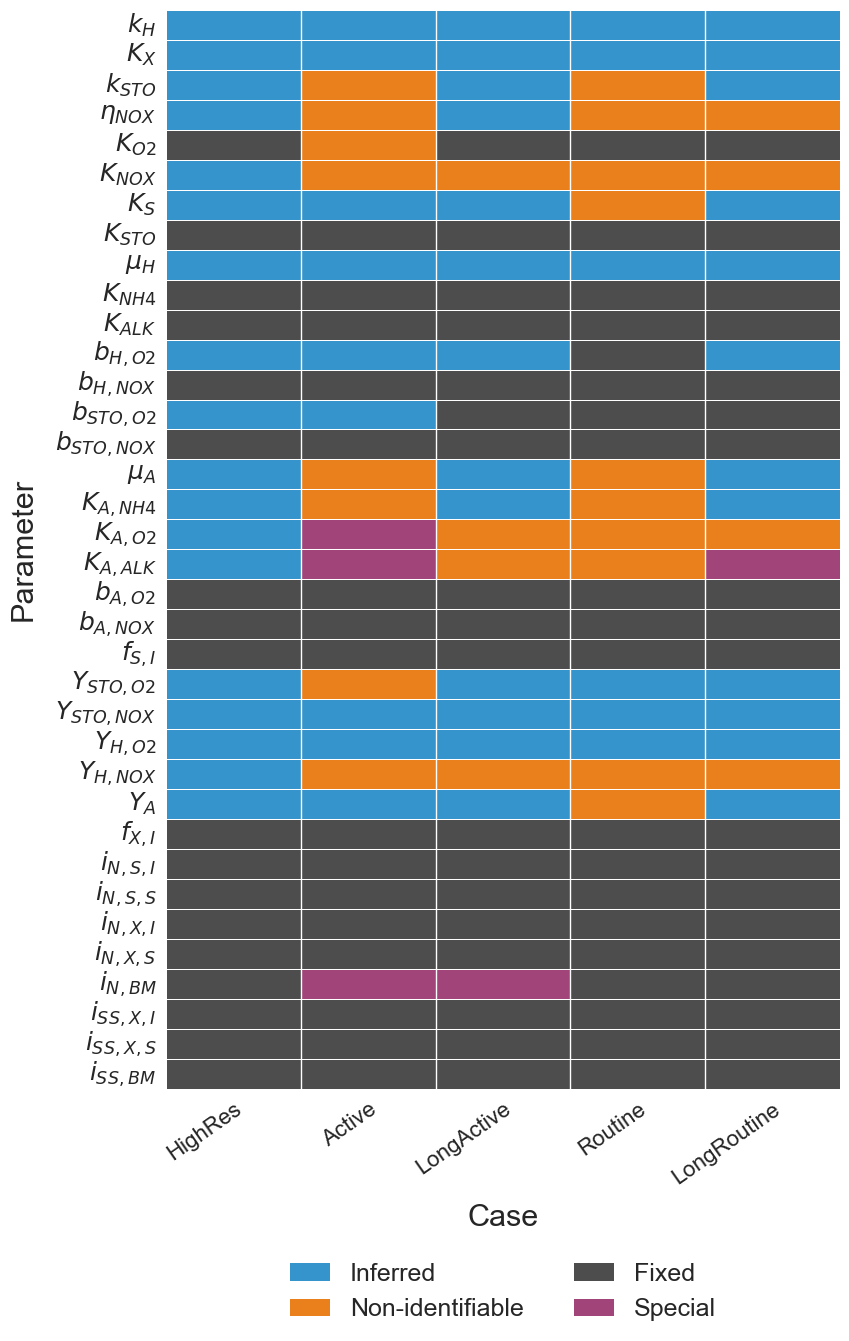

In [7]:
# --------------------------------------------------------------
# Parameter status heatmap for Regular scenario
# --------------------------------------------------------------

# --- Ordering ---
cases_order = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"]
REG_METHOD = "Sampling_Regular"

# --- Status + colors ---
status_to_code = {"inferred": 0, "non_identifiable_sampled": 1, "fixed": 2, "special": 3}
INFERED_COLOUR    = "#3594cc"   # Inferred
NON_IDENTIFIABLE_COLOUR  = "#ea801c"   # Non-identifiable
FIXED_COLOUR   = "#4D4D4D"   # Fixed
SPECIAL_COLOUR  = "#A04479"   # Special
cmap = ListedColormap([INFERED_COLOUR, NON_IDENTIFIABLE_COLOUR, FIXED_COLOUR, SPECIAL_COLOUR])
legend_patches = [
    Patch(facecolor=INFERED_COLOUR,   label="Inferred"),
    Patch(facecolor=NON_IDENTIFIABLE_COLOUR, label="Non-identifiable"),
    Patch(facecolor=FIXED_COLOUR,  label="Fixed"),
    Patch(facecolor=SPECIAL_COLOUR, label="Special"),
]

# --- Build param x case table ---
param_order = list(TRUE_THETA.keys())
col_keys = [f"{case}|{REG_METHOD}" for case in cases_order]
heat_df = pd.DataFrame(index=param_order, columns=col_keys, data="fixed")

for case in cases_order:
    if case not in cases:
        continue
    roles = cases[case]["param_roles"].get(REG_METHOD, {})
    r_fixed = set(roles.get("fixed", []))
    r_spec  = set(roles.get("special", []))
    r_inf   = set(roles.get("inferred", []))
    r_nonid = set(roles.get("non_identifiable_sampled", []))
    col = f"{case}|{REG_METHOD}"
    for p in param_order:
        if p in r_inf:
            heat_df.loc[p, col] = "inferred"
        elif p in r_nonid:
            heat_df.loc[p, col] = "non_identifiable_sampled"
        elif p in r_spec:
            heat_df.loc[p, col] = "special"
        elif p in r_fixed:
            heat_df.loc[p, col] = "fixed"

heat_df_num = heat_df.replace(status_to_code)
y_labels = [theta_format_names.get(p, p) for p in heat_df_num.index]

# --- Styling + layout ---
sns.set_style("white")
title_fs, axis_fs, ytick_fs, xtick_fs, legend_fs = 22, 22, 18, 16, 18

n_rows, n_cols = heat_df_num.shape  # n_cols == len(cases_order)

fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(
    heat_df_num,
    cmap=cmap, vmin=0, vmax=3,
    cbar=False,
    linewidths=0.6, linecolor="white",
    square=False,
    ax=ax
)

# X ticks = case names (tilted)
ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_xticklabels(cases_order, rotation=35, ha="right",
                   rotation_mode="anchor", fontsize=xtick_fs)

# Y ticks (formatted)
ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels(y_labels, rotation=0, fontsize=ytick_fs)

ax.set_xlabel("Case", fontsize=axis_fs, labelpad=12)
ax.set_ylabel("Parameter", fontsize=axis_fs, labelpad=12)
# fig.suptitle("Parameter Status", fontsize=title_fs, y=0.985)

# Light separators between cases
for i in range(len(cases_order) - 1):
    ax.axvline(i + 1, color="white", linewidth=1.0)

# Legend
# leg = ax.legend(handles=legend_patches, loc="lower center",
#                 bbox_to_anchor=(0.5, -0.1), frameon=False,
#                 fontsize=legend_fs, title="Status")


leg = ax.legend(
    handles=legend_patches,
    ncol=2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.14),
    frameon=False,
    fontsize=legend_fs,
    title="",
    handlelength=1.6,
)
if leg and leg.get_title():
    leg.get_title().set_fontsize(legend_fs)

# Layout
plt.tight_layout(rect=[0.0, 0.0, 0.86, 0.965])

# Save
out_dir = RESULTS_DIR / "Figures"
out_dir.mkdir(parents=True, exist_ok=True)
png = out_dir / "parameter_status_heatmap_regular.png"
plt.savefig(png, dpi=300, bbox_inches="tight")
print(f"Saved heatmap (Regular only) to:\n  {png}")

plt.show()


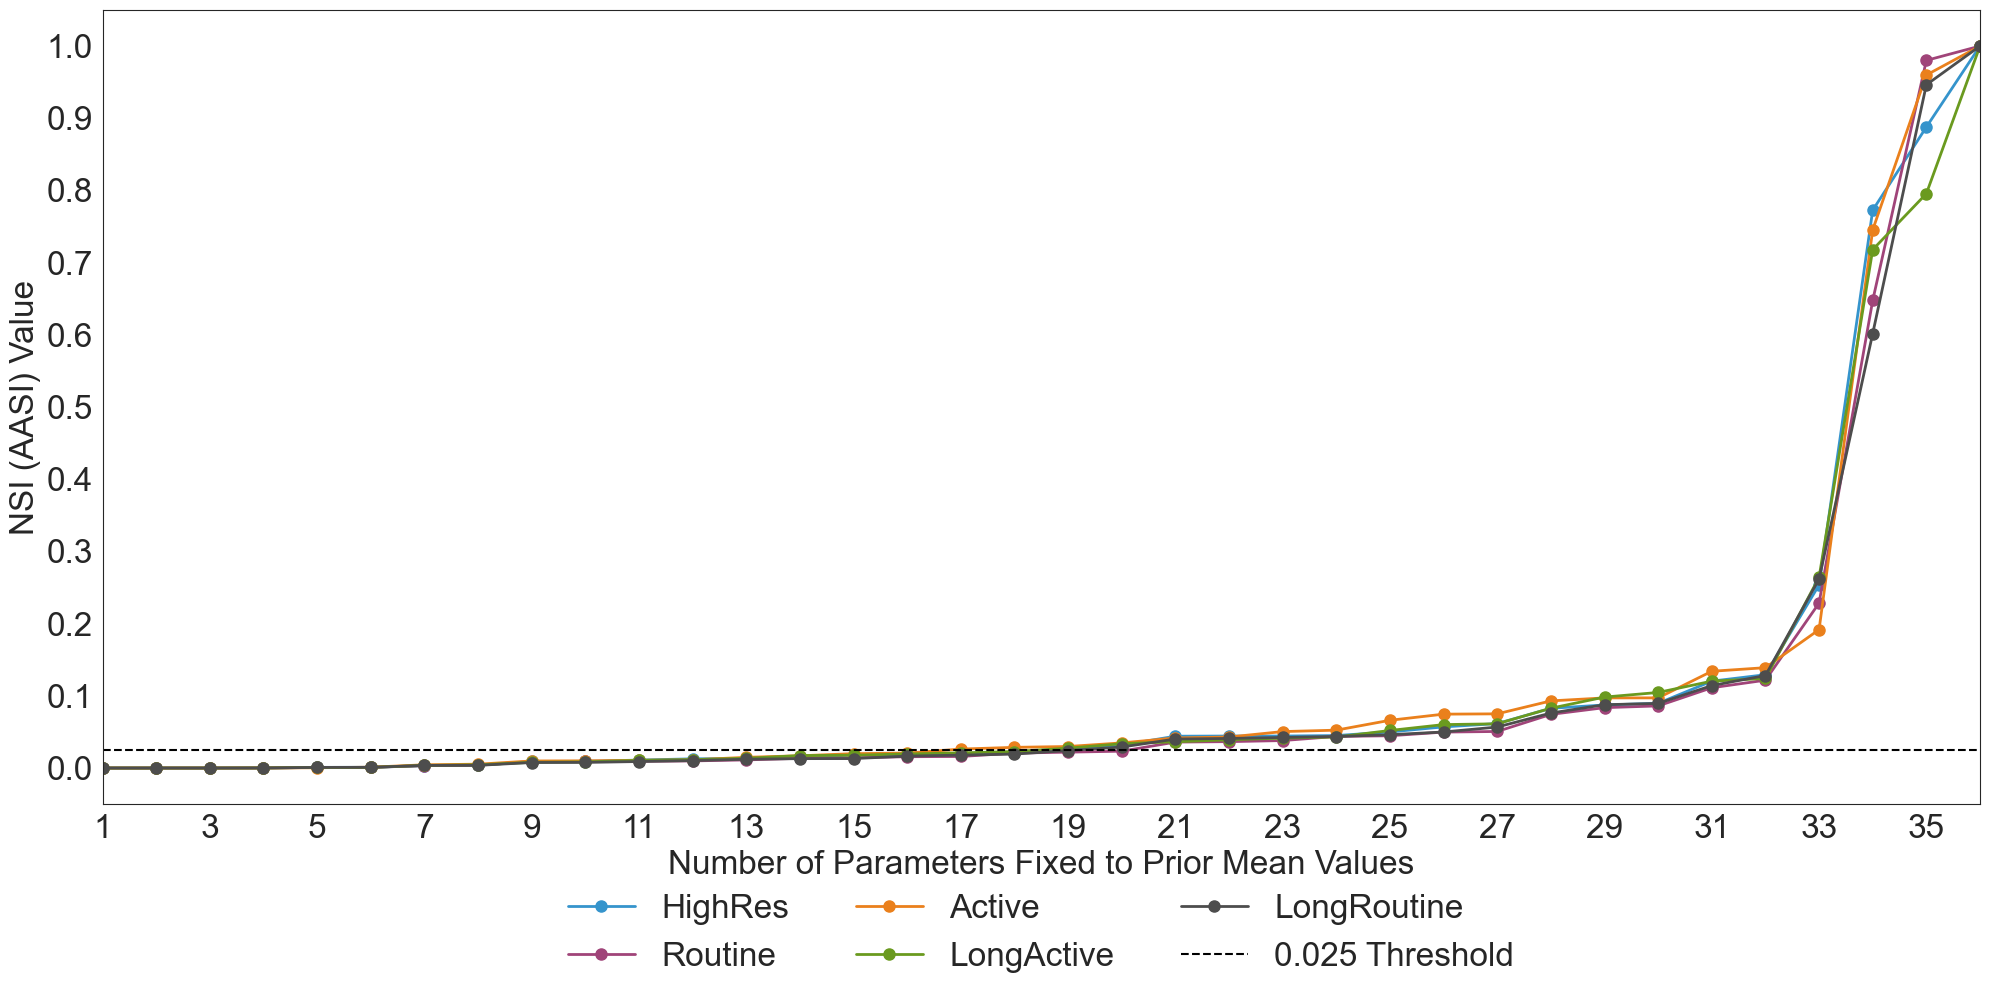

In [8]:
# ----------------------------------------------------------
# NSI (AASI) vs Number of Fixed Parameters — COMPOUNDS (All Cases)
# ----------------------------------------------------------


cases_to_plot = ["HighRes", "Routine", "Active", "LongActive", "LongRoutine"]

# Where NAASI files live per case
def naasi_compounds_path_for(case: str) -> Path:
    return RESULTS_DIR / case / "NAASI_compounds.csv"

# Collect sorted NSI sequences for each case
series_by_case = {}
max_len = 0
fontsize = 24

for case in cases_to_plot:
    f = naasi_compounds_path_for(case)
    if not f.exists():
        print(f"[skip] NAASI_compounds.csv not found for case '{case}' at: {f}")
        continue
    df = pd.read_csv(f)
    if "AASI" not in df.columns or "Parameter" not in df.columns:
        print(f"[skip] Missing required columns in {f.name} for case '{case}'")
        continue
    df_sorted = df.sort_values(by="AASI", ascending=True).reset_index(drop=True)
    y_vals = df_sorted["AASI"].astype(float).to_numpy()
    x_vals = np.arange(1, len(y_vals) + 1)
    series_by_case[case] = (x_vals, y_vals)
    max_len = max(max_len, len(y_vals))

if not series_by_case:
    raise RuntimeError("No valid NAASI_compounds.csv files found for the requested cases.")

# Plot
plt.figure(figsize=(20, 10))
for case, (x, y) in series_by_case.items():
    plt.plot(x, y, marker='o', linestyle='-', linewidth=2, markersize=8, label=case, color=CASE_COLORS.get(case, None))

# Threshold line at 0.025
plt.hlines(y=0.025, xmin=1, xmax=max_len, colors='black', linestyles='--', label='0.025 Threshold')

plt.xlabel('Number of Parameters Fixed to Prior Mean Values', fontsize=fontsize)
plt.ylabel('NSI (AASI) Value', fontsize=fontsize)
plt.xlim(1, max_len)
plt.xticks(np.arange(1, max_len + 1, 2), fontsize=fontsize)
plt.yticks(np.arange(0, 1.01, 0.1), fontsize=fontsize)
plt.legend(fontsize=fontsize, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.25), frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()



In [9]:
# ======================================================
# Small path helpers
# ======================================================
def naasi_compounds_path_for(case: str) -> Path:
    return RESULTS_DIR / case / "NAASI_compounds.csv"

def sse_by_fix_order_path_for(case: str) -> Path:
    return RESULTS_DIR / case / "SSE_by_fix_order.csv"

def _compounds_csv_path(case: str) -> Path:
    mapping = {
        "HighRes": ("0-HighRes/HighRes_Effluent_Compounds.csv"),
        "Routine": ("1-Routine/Routine_Effluent_Compounds.csv"),
        "Active": ("2-Active/Active_Effluent_Compounds.csv"),
        "LongActive": ("3-LongActive/LongActive_Effluent_Compounds.csv"),
        "LongRoutine": ("4-LongRoutine/LongRoutine_Effluent_Compounds.csv"),
    }
    return DATA_DIR / mapping[case]

def _influent_states_csv_path(case: str) -> Path:
    mapping = {
        "HighRes": ("0-HighRes/HighRes_Influent_States.csv"),
        "Routine": ("1-Routine/Routine_Influent_States.csv"),
        "Active": ("2-Active/Active_Influent_States.csv"),
        "LongActive": ("3-LongActive/LongActive_Influent_States.csv"),
        "LongRoutine": ("4-LongRoutine/LongRoutine_Influent_States.csv"),
    }
    return DATA_DIR / mapping[case]

# ==== Prior means from config ranges ====
def _map_range_key_to_param(range_key_tail: str) -> Optional[str]:
    raw = range_key_tail.strip()
    candidates = [raw]
    for pref in ("small_", "big_"):
        if raw.startswith(pref):
            candidates.append(raw[len(pref):])
    canon_keys = list(TRUE_THETA.keys())
    lower_to_canon = {k.lower(): k for k in canon_keys}
    for cand in candidates:
        if cand in TRUE_THETA:
            return cand
        lc = cand.lower()
        if lc in lower_to_canon:
            return lower_to_canon[lc]
    squeeze = raw.replace("_", "").lower()
    squeeze_map = {k.replace("_", "").lower(): k for k in canon_keys}
    return squeeze_map.get(squeeze, None)

def _read_prior_ranges_from_config(cfg: configparser.ConfigParser) -> Dict[str, Tuple[float, float]]:
    ranges: Dict[str, Tuple[float, float]] = {}
    for sect in cfg.sections():
        for k, v in cfg[sect].items():
            if not k.startswith("range_param_"):
                continue
            tail = k[len("range_param_"):]
            pname = _map_range_key_to_param(tail)
            if pname is None:
                continue
            try:
                lo, hi = [float(x.strip()) for x in v.split(",")]
                ranges[pname] = (lo, hi)
            except Exception:
                pass
    return ranges

def _prior_means_map() -> dict[str, float]:
    ranges = _read_prior_ranges_from_config(_cfg)
    return {p: 0.5*(lo+hi) for p, (lo, hi) in ranges.items()}

# ==== Theta fixing ====
def _results_method_dir(case: str, method: str) -> Path:
    return RESULTS_DIR / case / method

def load_theta_samples_and_meta(case: str, method: str) -> tuple[pd.DataFrame, dict]:
    mdir = _results_method_dir(case, method)
    df_path = mdir / "theta_samples.csv"
    meta_path = mdir / "theta_meta.json"
    if not df_path.exists():
        raise FileNotFoundError(f"Missing samples file: {df_path}")
    theta_df = pd.read_csv(df_path)
    meta = {"fixed": {}, "special": {}}
    if meta_path.exists():
        with open(meta_path, "r") as f:
            meta = json.load(f)
    keep = [c for c in theta_df.columns if c in TRUE_THETA]
    theta_df = theta_df[keep]
    return theta_df, meta

def _theta_df_with_fixed(theta_df: pd.DataFrame, fixed_params: set[str], prior_means: dict[str, float]) -> pd.DataFrame:
    df = theta_df.copy()
    for p in fixed_params:
        if (p in df.columns) and (p in prior_means):
            df[p] = prior_means[p]
    return df


In [10]:

# ----------------------------------------------------------
# Helpers -- Extract samples for every case + method
# ----------------------------------------------------------


def _prior_mean_from_range(lo_hi: Tuple[float, float]) -> float:
    return 0.5 * (lo_hi[0] + lo_hi[1])

def _build_theta_samples_df(
    idata: az.InferenceData,
    roles_for_method: Dict[str, Set[str]],
    prior_ranges: Dict[str, Tuple[float, float]],
    special_case_value: float = 1e-6,
    num_samples: Optional[int] = 1000,
) -> pd.DataFrame:
    """
    Build theta samples with priority:
      1) If param is intended to be sampled (inferred or non-ident) AND exists in trace -> use posterior samples.
      2) Else if param is fixed -> fill with prior-mean across rows.
      3) Else if param is special -> fill with special_case_value across rows.
      4) Else if param is intended to be sampled but *missing* from trace -> fallback to prior-mean.
      5) Else -> NaN (should be rare).
    """
    present = names_in_trace(idata) if idata is not None else set()

    want_sampled = (roles_for_method.get("inferred", set())
                    | roles_for_method.get("non_identifiable_sampled", set()))
    fixed  = roles_for_method.get("fixed", set())
    special = roles_for_method.get("special", set())

    actually_sampled = want_sampled & present

    # Pull posterior for what's actually in the trace
    if idata is not None and actually_sampled:
        df_samp = az.extract(idata, num_samples=num_samples, var_names=sorted(actually_sampled)).to_dataframe()
        df_samp = df_samp.drop(columns=["chain", "draw"], errors="ignore")
    else:
        df_samp = pd.DataFrame()

    # Decide number of rows
    nrows = len(df_samp) if not df_samp.empty else (num_samples or 0)
    if nrows == 0:
        nrows = 1

    # Start result
    theta_df = df_samp.copy() if not df_samp.empty else pd.DataFrame(index=np.arange(nrows))

    # Fill every canonical param
    for p in sorted(PARAMETER_CANON):
        if p in theta_df.columns:
            continue

        if p in fixed:
            lo_hi = prior_ranges.get(p, (TRUE_THETA[p], TRUE_THETA[p]))
            theta_df[p] = _prior_mean_from_range(lo_hi)
        elif p in special:
            theta_df[p] = special_case_value
        elif p in want_sampled:
            # intended to be sampled but not present in trace -> fallback to prior mean
            lo_hi = prior_ranges.get(p, (TRUE_THETA[p], TRUE_THETA[p]))
            theta_df[p] = _prior_mean_from_range(lo_hi)
        else:
            theta_df[p] = np.nan

    # Column order: canonical
    theta_df = theta_df[[p for p in TRUE_THETA.keys() if p in theta_df.columns]]
    return theta_df

def _build_theta_meta(
    roles_for_method: Dict[str, Set[str]],
    prior_ranges: Dict[str, Tuple[float, float]],
    special_case_value: float = 1e-6,
) -> Dict[str, dict]:
    """
    Metadata: fixed params -> prior mean; special params -> special_case_value.
    (No 'notes' field.)
    """
    fixed = sorted(list(roles_for_method.get("fixed", set())))
    special = sorted(list(roles_for_method.get("special", set())))

    fixed_vals = {}
    for p in fixed:
        lo, hi = prior_ranges[p]
        fixed_vals[p] = 0.5 * (lo + hi)
    meta = {
        "fixed": fixed_vals,
        "special": {p: special_case_value for p in special},
    }
    return meta

def save_all_theta_samples(
    cases_registry: Dict[str, dict],
    out_filename: str = "theta_samples.csv",
    meta_filename: str = "theta_meta.json",
    num_samples: Optional[int] = 1000,
    special_case_value: float = 1e-6,
) -> None:
    """
    For every case+method with a trace, save `theta_samples.csv` and `theta_meta.json` under the method folder.
    """
    prior_ranges = _read_prior_ranges_from_config(_cfg)
    for case, blob in cases_registry.items():
        case_dir = blob["case_dir"]
        for method, idata in blob["traces"].items():
            roles = blob["param_roles"][method]
            # Build & save samples
            df = _build_theta_samples_df(
                idata=idata,
                roles_for_method=roles,
                prior_ranges=prior_ranges,
                special_case_value=special_case_value,
                num_samples=num_samples,
            )
            out_dir = case_dir / method
            out_dir.mkdir(parents=True, exist_ok=True)
            df.to_csv(out_dir / out_filename, index=False)

            # Save meta (fixed & special values used)
            meta = _build_theta_meta(roles, prior_ranges, special_case_value=special_case_value)
            with open(out_dir / meta_filename, "w") as f:
                json.dump(meta, f, indent=2)

    print("Saved theta samples and metadata for all available traces.")

# ----------------------------------------------------------
# Noise sigma helpers
# ----------------------------------------------------------

SIGMA_VARS = ["sigma_COD","sigma_NH4","sigma_NOx","sigma_TKN","sigma_Alkalinity","sigma_TSS"]

def _extract_sigma_df(idata: Optional[az.InferenceData], num_samples: int = 500) -> pd.DataFrame:
    """Return a dataframe with the sigma_* columns (if present). Empty if none found."""
    if idata is None or not hasattr(idata, "posterior"):
        return pd.DataFrame(columns=SIGMA_VARS)
    present = [v for v in SIGMA_VARS if v in idata.posterior.data_vars]
    if not present:
        return pd.DataFrame(columns=SIGMA_VARS)
    df = az.extract(idata, num_samples=num_samples, var_names=present).to_dataframe()
    return df.drop(columns=['chain','draw'], errors='ignore')

def save_all_sigma_samples(
    cases_registry: Dict[str, dict],
    out_filename: str = "sigma_samples.csv",
    num_samples: Optional[int] = 500,
) -> None:
    """For every case+method with a trace, save sigma samples to sigma_samples.csv."""
    for case, blob in cases_registry.items():
        case_dir = blob["case_dir"]
        for method, idata in blob["traces"].items():
            if idata is None:
                continue
            df_sig = _extract_sigma_df(idata=idata, num_samples=num_samples or 500)
            if df_sig.empty:
                # still write a header so downstream code can proceed gracefully
                df_sig = pd.DataFrame(columns=SIGMA_VARS)
            out_dir = case_dir / method
            out_dir.mkdir(parents=True, exist_ok=True)
            df_sig.to_csv(out_dir / out_filename, index=False)
    print("Saved sigma (noise) samples for all available traces.")



In [11]:
# ----------------------------------------------------------
# Extract & persist samples for every case + method
# ----------------------------------------------------------

NUM_SAMPLES = 500

# Save 500 samples per case/method
print("--------------------------------------------------")
print("\nExtracting and saving theta samples and metadata...")
print("--------------------------------------------------\n")
save_all_theta_samples(cases, num_samples=NUM_SAMPLES, special_case_value=1e-6)

print("\nExtracting and saving sigma noise samples...\n")
save_all_sigma_samples(cases, num_samples=NUM_SAMPLES)

--------------------------------------------------

Extracting and saving theta samples and metadata...
--------------------------------------------------

Saved theta samples and metadata for all available traces.

Extracting and saving sigma noise samples...

Saved sigma (noise) samples for all available traces.


In [12]:
# ----------------------------------------------------------
## Helpers for kde plots to keep values nonnegative
# ----------------------------------------------------------

def _positive_series(s: pd.Series, name: str = "") -> pd.Series:
    """Return nonnegative values only; log a short note if any were dropped."""
    if s is None:
        return pd.Series(dtype=float)
    s = s.dropna().astype(float)
    neg = (s < 0).sum()
    if neg > 0:
        print(f"[note] Dropped {neg} negative samples for {name} (params must be ≥ 0).")
    return s[s >= 0]

def _is_effectively_constant_nonneg(s: pd.Series) -> bool:
    s = _positive_series(s)
    return (s.size > 0) and (float(np.nanmax(s)) - float(np.nanmin(s)) == 0.0)

def _hdi_nonneg(s: pd.Series) -> tuple[float,float,float]:
    s = _positive_series(s)
    if s.empty:
        return (np.nan, np.nan, np.nan)
    return (float(s.mean()),
            float(s.quantile(0.025)),
            float(s.quantile(0.975)))


In [13]:
# --------------------------------------------------------------
# Plotting helpers (with formatted names & customizable styles)
# --------------------------------------------------------------

# Defaults for seaborn/matplotlib plot
sns.set_context("poster")
sns.set_style("white")



def load_sigma_samples(case: str, method: str) -> pd.DataFrame:
    """Load sigma_samples.csv for a case/method; returns empty DF if missing."""
    f = _results_method_dir(case, method) / "sigma_samples.csv"
    if not f.exists():
        return pd.DataFrame(columns=SIGMA_VARS)
    df = pd.read_csv(f)
    # keep only known sigma cols, preserve order
    cols = [c for c in SIGMA_VARS if c in df.columns]
    return df[cols]


def get_roles_for(case: str, method: str, cases_registry: dict) -> dict:
    """
    Retrieve role sets for a case/method from cases_registry['param_roles'].
    - 'fixed'
    - 'special'
    - 'inferred'                 (identifiable & present in trace)
    - 'non_identifiable_sampled' (present in trace, but flagged non-ident)
    """
    blob = cases_registry.get(case)
    if not blob:
        raise KeyError(f"Unknown case: {case}")
    roles = blob['param_roles'].get(method)
    if not roles:
        raise KeyError(f"No roles for method {method} in case {case}")
    # Ensure sets
    return {k: set(v) for k, v in roles.items()}

def _stats(series: pd.Series) -> dict:
    """Compute mean/median/95% HDI-style quantiles for a 1D series (drop nans)."""
    s = series.dropna().astype(float)
    if s.empty:
        return {"mean": np.nan, "median": np.nan, "q2.5": np.nan, "q97.5": np.nan}
    return {
        "mean":   float(s.mean()),
        "median": float(s.median()),
        "q2.5":   float(s.quantile(0.025)),
        "q97.5":  float(s.quantile(0.975)),
    }

def _big_text_figure(title: str,
                     subtitle: str,
                     footnote: str | None = None,
                     figsize=(12, 3.5),
                     fontsize: int = 28,
                     true_rel: float = 0.92,
                     sub_rel: float = 1.0):
    """
    Create a simple matplotlib figure with large text.
    - `fontsize` is the base for the title.
    - `subtitle` (e.g., fixed value) uses ~same size as title (sub_rel).
    - `footnote` (e.g., true value) uses a *slightly* smaller size (true_rel).
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    # Title = formatted parameter name + role
    ax.text(0.02, 0.70, title, fontsize=fontsize, fontweight='bold', va='center', ha='left')
    # Subtitle (e.g., Fixed value) — just a hair smaller or same
    ax.text(0.02, 0.40, subtitle, fontsize=int(fontsize * sub_rel), va='center', ha='left')
    # Footnote (true value) — slightly smaller than subtitle
    if footnote:
        ax.text(0.02, 0.18, footnote, fontsize=int(fontsize * true_rel), color='dimgray', va='center', ha='left')
    plt.tight_layout()
    return fig, ax

def _kde_figure(param: str,
                samples: pd.Series,
                true_value: float | None,
                label_suffix: str = "",
                sampled_color: str = "blue",
                mean_line_color: str = "darkblue",
                hdi_line_color: str = "lightcoral",
                true_line_color: str = "black",
                median_line_color: str = "lightcoral",
                show_median: bool = False,
                title: str | None = None,
                figsize=(12, 4.5),
                fontsize: int = 20,
                use_formatted_name: bool = True):
    """
    KDE + vertical lines for mean & 95% interval (+ optional true value),
    with fully customizable colors and font sizes.
    """
    disp_name = theta_format_names.get(param, param) if use_formatted_name else param

    s = _positive_series(samples, name=param)
    fig, ax = plt.subplots(figsize=figsize)
    if not s.empty:
        sns.kdeplot(
            s,
            fill=True,
            linewidth=2,
            ax=ax,
            label=f"Sampled density {label_suffix}".strip(),
            color=sampled_color,
            clip=(0, None)
        )
        st = _stats(s)
        ax.axvline(st["mean"], linestyle="--", linewidth=3, color=mean_line_color, label="Mean")
        if show_median:
            ax.axvline(st["median"], linestyle=":", linewidth=3, color=median_line_color, label="Median")
        ax.axvline(st["q2.5"], linestyle="-.", linewidth=3, color=hdi_line_color, label="95% HDI bounds")
        ax.axvline(st["q97.5"], linestyle="-.", linewidth=3, color=hdi_line_color)
        print(
            f"{param}: mean={st['mean']:.5g}, median={st['median']:.5g}, "
            f"95% HDI=[{st['q2.5']:.5g}, {st['q97.5']:.5g}]",
            f" true={true_value:.5g}" if true_value is not None else ""
        )

        x_candidates = [
            s.min(),
            s.max(),
            st["mean"],
            st["q2.5"],
            st["q97.5"],
        ]
        if true_value is not None:
            x_candidates.append(true_value)

        x_min = min(x_candidates)
        x_max = max(x_candidates)
        span = x_max - x_min
        pad = 0.1 * span if span > 0 else max(x_max, 1.0) * 0.1
        left = max(0.0, x_min - pad)
        right = x_max + pad if span > 0 else x_max + pad
        if right <= left:
            right = left + (span if span > 0 else max(x_max, 1.0))
        ax.set_xlim(left=left, right=right)
    else:
        ax.text(0.5, 0.5, "No samples in trace", ha="center", va="center", fontsize=fontsize)
        ax.set_xlim(left=0.0)

    if true_value is not None:
        true_label = f"True value ({true_value:.6g})"
        ax.axvline(true_value, color=true_line_color, linestyle="-", linewidth=3, label=true_label)

    ax.set_ylim(bottom=0.0)

    # ax.set_title(title if title else f"{disp_name}", fontsize=fontsize)
    ax.set_xlabel(f"{disp_name} distribution", fontsize=fontsize)
    ax.set_ylabel("Density", fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), frameon=False, fontsize=fontsize, ncol=2)
    plt.tight_layout()
    return fig, ax

def plot_case_method(case: str,
                     method: str,
                     cases_registry: dict,
                     params: list[str] | None = None,
                     show_median: bool = False,
                     # Appearance controls (optional)
                     fontsize: int = 20,
                     figsize_kde=(12, 4.5),
                     figsize_tile=(12, 3.8),
                     # Colors
                     sampled_color_inferred: str = "C0",
                     sampled_color_nonident: str = "C1",
                     mean_line_color: str = "black",
                     hdi_line_color: str = "purple",
                     true_line_color: str = "green",
                     median_line_color: str = "black"):
    """
    For a chosen dataset (case) and scenario (method), in *column order* of theta_samples.csv:
      - inferred params: KDE plot with stats + true value
      - non-identifiable-in-trace: KDE plot + note "(non-identifiable, latent)"
      - fixed params: big text tile with fixed (prior-mean) and true value (formatted names)
      - special params: big text tile with value=0 (1e-6) and true value (formatted names)

    Customize appearance via colors, fontsize, and figuresize.
    """
    # Load data and roles
    theta_df, meta = load_theta_samples_and_meta(case, method)
    roles = get_roles_for(case, method, cases_registry)

    # Role sets
    inferred            = set(roles.get("inferred", set()))
    non_ident_sampled   = set(roles.get("non_identifiable_sampled", set()))
    fixed               = set(roles.get("fixed", set()))
    special             = set(roles.get("special", set()))

    # If a subset of params was requested, filter *display* to that subset
    column_order = list(theta_df.columns)
    if params is not None:
        # keep order as in theta_df.columns but include only requested ones (if present)
        want = [p for p in column_order if p in params]
        # also include requested fixed/special that might not be in samples
        extras = [p for p in (params or []) if p not in want]
        column_order = want + extras

        subset = set(params)
        inferred          &= subset
        non_ident_sampled &= subset
        fixed             &= subset
        special           &= subset

    # Fixed/special meta
    fixed_meta = meta.get("fixed", {})
    special_meta = meta.get("special", {})

    # Iterate in the order of theta_samples columns; for any fixed/special that
    # don't appear in the samples, we’ll still render them when we encounter their name.
    seen = set()

    for p in column_order:
        seen.add(p)
        disp_name = theta_format_names.get(p, p)
        tval = TRUE_THETA.get(p, None)

        if p in inferred:
            _kde_figure(
                p, theta_df[p],
                tval,
                label_suffix="",
                sampled_color=sampled_color_inferred,
                mean_line_color=mean_line_color,
                hdi_line_color=hdi_line_color,
                true_line_color=true_line_color,
                median_line_color=median_line_color,
                show_median=show_median,
                title=f"{disp_name} (inferred)",
                figsize=figsize_kde,
                fontsize=fontsize,
                use_formatted_name=True
            )
            plt.show()
            continue

        if p in non_ident_sampled:
            _kde_figure(
                p, theta_df[p],
                tval,
                label_suffix="(non-identifiable, latent)",
                sampled_color=sampled_color_nonident,
                mean_line_color=mean_line_color,
                hdi_line_color=hdi_line_color,
                true_line_color=true_line_color,
                median_line_color=median_line_color,
                show_median=show_median,
                title=f"{disp_name} (non-identifiable, latent)",
                figsize=figsize_kde,
                fontsize=fontsize,
                use_formatted_name=True
            )
            plt.show()
            continue

        if p in fixed:
            fval = fixed_meta.get(p, None)
            subtitle = f"Fixed value (prior mean): {fval:.6g}" if fval is not None else "Fixed value: <unknown in meta>"
            foot = f"True value: {tval:.6g}" if tval is not None else "True value: N/A"
            _big_text_figure(
                title=f"{disp_name} — FIXED",
                subtitle=subtitle,
                footnote=foot,
                figsize=figsize_tile,
                fontsize=fontsize,
                sub_rel=1.0,                 # fixed value ~same as title
                true_rel=0.95                # true value only slightly smaller
            )
            plt.show()
            continue

        if p in special:
            sval = special_meta.get(p, 1e-6)
            subtitle = f"Special-case value: {sval:.6g} (≈ 0)"
            foot = f"True value: {tval:.6g}" if tval is not None else "True value: N/A"
            _big_text_figure(
                title=f"{disp_name} — SPECIAL CASE",
                subtitle=subtitle,
                footnote=foot,
                figsize=figsize_tile,
                fontsize=fontsize,
                sub_rel=1.0,
                true_rel=0.95
            )
            plt.show()
            continue

        # If parameter is neither in samples nor in any role (rare), just show a note
        if p not in theta_df.columns and p not in fixed and p not in special:
            _big_text_figure(
                title=f"{disp_name} — Not categorized",
                subtitle="No samples and not listed in roles.",
                footnote="Check roles CSV and saved theta.",
                figsize=figsize_tile,
                fontsize=fontsize,
                sub_rel=1.0,
                true_rel=0.9
            )
            plt.show()

    # If there are fixed/special that don't appear in theta_df columns (and not in `params`),
    # render those at the end in their original order.
    if params is None:
        remaining_tiles = [p for p in (list(fixed) + list(special)) if p not in seen]
        for p in remaining_tiles:
            disp_name = theta_format_names.get(p, p)
            tval = TRUE_THETA.get(p, None)
            if p in fixed:
                fval = fixed_meta.get(p, None)
                subtitle = f"Fixed value (prior mean): {fval:.6g}" if fval is not None else "Fixed value: <unknown in meta>"
                foot = f"True value: {tval:.6g}" if tval is not None else "True value: N/A"
                _big_text_figure(
                    title=f"{disp_name} — FIXED",
                    subtitle=subtitle,
                    footnote=foot,
                    figsize=figsize_tile,
                    fontsize=fontsize,
                    sub_rel=1.0,
                    true_rel=0.95
                )
                plt.show()
            elif p in special:
                sval = special_meta.get(p, 1e-6)
                subtitle = f"Special-case value: {sval:.6g} (≈ 0)"
                foot = f"True value: {tval:.6g}" if tval is not None else "True value: N/A"
                _big_text_figure(
                    title=f"{disp_name} — SPECIAL CASE",
                    subtitle=subtitle,
                    footnote=foot,
                    figsize=figsize_tile,
                    fontsize=fontsize,
                    sub_rel=1.0,
                    true_rel=0.95
                )
                plt.show()


In [14]:
# ----------------------------------------------------------
# Overlay distributions for two (case, scenario) selections
# ----------------------------------------------------------

# Palette
COL_A = "#3594cc"   # Scenario A fill/KDE
COL_B = "#ea801c"   # Scenario B fill/KDE
COL_TRUE = "#000000"  # true value line
COL_MEAN_A = "#1d506e" # Mean line A
COL_MEAN_B = "#854912" # Mean line B

@dataclass
class ScenarioSel:
    case: str
    method: str
    label: str  # for legend

def _param_status(roles: dict, p: str) -> str:
    if p in roles.get("fixed", set()): return "fixed"
    if p in roles.get("special", set()): return "special"
    if p in roles.get("inferred", set()): return "sampled_ident"
    if p in roles.get("non_identifiable_sampled", set()): return "sampled_nonident"
    return "none"

def _series_or_none(theta_df: pd.DataFrame, p: str) -> Optional[pd.Series]:
    if p in theta_df.columns:
        s = theta_df[p].dropna()
        return s if not s.empty else None
    return None

def _is_effectively_constant(s: pd.Series) -> bool:
    return (s.notna().sum() > 0) and (np.nanmax(s) - np.nanmin(s) == 0)

def _hdi(s: pd.Series) -> tuple[float,float,float]:
    s = s.dropna().astype(float)
    if s.empty:
        return (np.nan, np.nan, np.nan)
    return (float(s.mean()),
            float(s.quantile(0.025)),
            float(s.quantile(0.975)))

def plot_overlay_two(
    sel_a: ScenarioSel,
    sel_b: ScenarioSel,
    cases_registry: dict,
    params: list[str] | None = None,
    fontsize: int = 24,
    figsize=(12, 5),
    fill_alpha_a: float = 0.40,
    fill_alpha_b: float = 0.35,
):
    """
    One figure per parameter with both scenarios overlaid.
    - KDE for sampled; solid vertical for fixed/special.
    - HDI lines for each sampled series, colored to match its KDE.
    - True value line is black.
    """
    df_a, meta_a = load_theta_samples_and_meta(sel_a.case, sel_a.method)
    df_b, meta_b = load_theta_samples_and_meta(sel_b.case, sel_b.method)
    roles_a = get_roles_for(sel_a.case, sel_a.method, cases_registry)
    roles_b = get_roles_for(sel_b.case, sel_b.method, cases_registry)

    all_params = [p for p in TRUE_THETA.keys() if (p in df_a.columns) or (p in df_b.columns)
                  or (p in roles_a.get("fixed", set()) | roles_a.get("special", set())
                      | roles_b.get("fixed", set()) | roles_b.get("special", set()))]
    param_list = [p for p in (params if params is not None else all_params) if p in TRUE_THETA]

    for p in param_list:
        status_a = _param_status(roles_a, p)
        status_b = _param_status(roles_b, p)

        s_a_raw = _series_or_none(df_a, p)
        s_b_raw = _series_or_none(df_b, p)
        s_a = _positive_series(s_a_raw, name=f"{sel_a.label}:{p}") if s_a_raw is not None else None
        s_b = _positive_series(s_b_raw, name=f"{sel_b.label}:{p}") if s_b_raw is not None else None

        fixed_val_a = None
        fixed_val_b = None
        if status_a == "fixed":
            fixed_val_a = meta_a.get("fixed", {}).get(p, None)
        elif status_a == "special":
            fixed_val_a = meta_a.get("special", {}).get(p, 1e-6)
        elif s_a is not None and _is_effectively_constant_nonneg(s_a):
            fixed_val_a = float(s_a.iloc[0])

        if status_b == "fixed":
            fixed_val_b = meta_b.get("fixed", {}).get(p, None)
        elif status_b == "special":
            fixed_val_b = meta_b.get("special", {}).get(p, 1e-6)
        elif s_b is not None and _is_effectively_constant_nonneg(s_b):
            fixed_val_b = float(s_b.iloc[0])

        disp = theta_format_names.get(p, p)
        true_val = TRUE_THETA.get(p, None)

        fig, ax = plt.subplots(figsize=figsize)

        # Scenario A KDE
        if status_a.startswith("sampled") and s_a is not None and not _is_effectively_constant_nonneg(s_a):
            sns.kdeplot(
                s_a, fill=True, color=COL_A, alpha=fill_alpha_a, linewidth=2, ax=ax,
                label=f"{sel_a.label} density", clip=(0, None)
            )
            mean_a, lo_a, hi_a = _hdi_nonneg(s_a)
            ax.axvline(mean_a, color=COL_MEAN_A, linestyle="--", linewidth=3, label=f"{sel_a.label} mean")
            ax.axvline(lo_a,   color=COL_A,      linestyle="-.", linewidth=3, label=f"{sel_a.label} 95% HDI")
            ax.axvline(hi_a,   color=COL_A,      linestyle="-.", linewidth=3)
        elif fixed_val_a is not None:
            ax.axvline(fixed_val_a, color=COL_A, linestyle="-", linewidth=4, label=f"{sel_a.label} fixed")

        # Scenario B KDE
        if status_b.startswith("sampled") and s_b is not None and not _is_effectively_constant_nonneg(s_b):
            sns.kdeplot(
                s_b, fill=True, color=COL_B, alpha=fill_alpha_b, linewidth=2, ax=ax,
                label=f"{sel_b.label} density", clip=(0, None)
            )
            mean_b, lo_b, hi_b = _hdi_nonneg(s_b)
            ax.axvline(mean_b, color=COL_MEAN_B, linestyle="--", linewidth=3, label=f"{sel_b.label} mean")
            ax.axvline(lo_b,   color=COL_B,      linestyle="-.", linewidth=3, label=f"{sel_b.label} 95% HDI")
            ax.axvline(hi_b,   color=COL_B,      linestyle="-.", linewidth=3)
        elif fixed_val_b is not None:
            ax.axvline(fixed_val_b, color=COL_B, linestyle="-", linewidth=4, label=f"{sel_b.label} fixed")

        # True value
        if true_val is not None:
            true_label = f"True value ({true_val:.6g})"
            ax.axvline(true_val, color=COL_TRUE, linestyle="-", linewidth=3, label=true_label)

        # cosmetic: keep x ≥ 0
        ax.set_xlim(left=0)

        # Titles & labels
        ax.set_title(f"{disp}", fontsize=fontsize)
        ax.set_xlabel(f"{disp} distribution", fontsize=int(fontsize*0.9))
        ax.set_ylabel("Density", fontsize=int(fontsize*0.9))
        ax.tick_params(axis='both', labelsize=int(fontsize*0.85))
        ax.grid(False)

        # Legend: deduplicate
        handles, labels = ax.get_legend_handles_labels()
        seen, dedup_h, dedup_l = set(), [], []
        for h, l in zip(handles, labels):
            if l not in seen:
                seen.add(l); dedup_h.append(h); dedup_l.append(l)
        #ax.legend(dedup_h, dedup_l, loc="best", frameon=False, fontsize=int(fontsize*0.75))

        ax.legend(
            dedup_h,
            dedup_l,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            frameon=False,
            fontsize=fontsize,
            ncol=2,
        )

        # If both fixed/special, add compact text summary
        if (fixed_val_a is not None) and (fixed_val_b is not None) and \
           not (status_a.startswith("sampled") or status_b.startswith("sampled")):
            lines = [f"{sel_a.label}: {fixed_val_a:.6g}  (fixed)",
                     f"{sel_b.label}: {fixed_val_b:.6g}  (fixed)"]
            if true_val is not None:
                lines.append(f"True: {true_val:.6g}")
            ax.text(0.02, 0.95, "\n".join(lines), transform=ax.transAxes,
                    ha="left", va="top", fontsize=int(fontsize*0.75))

        plt.tight_layout()
        plt.show()


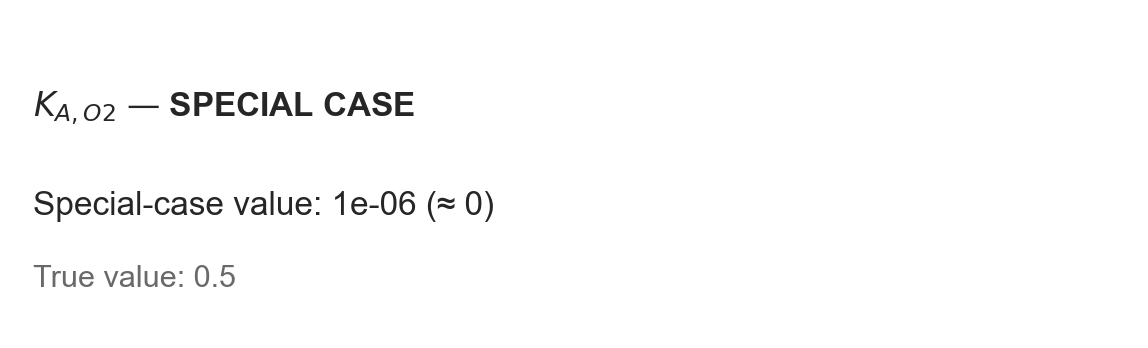

In [15]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# --------------------------------------------------------------
# Choose dataset (case) and scenario (method), then plot
# --------------------------------------------------------------

case   = "Active"               # "HighRes", "Routine", "Active", "LongActive", "LongRoutine"
method = "Sampling_Regular"     # "Sampling_AllFreeNonInformative", "Sampling_AllFreePriors", "Sampling_AllFreeTight", "Sampling_FixedNoIdentifiability", "Sampling_Regular"

# Optionally restrict to a subset of parameters (in displayed order of theta_samples.csv)
params_to_show = ["K_A_O2"]
# params_to_show = None

plot_case_method(
    case,
    method,
    cases_registry=cases,
    params=params_to_show,
    show_median=False,         # set True to add median line

    # Appearance controls (optional)
    fontsize=24,
    figsize_kde=(20, 7),
    figsize_tile=(12, 4.0),

    # Colors (optional)
    sampled_color_inferred="C0",
    sampled_color_nonident="C1",
    mean_line_color="blue",
    hdi_line_color="C0",
    true_line_color="black",
    median_line_color="blue",
)


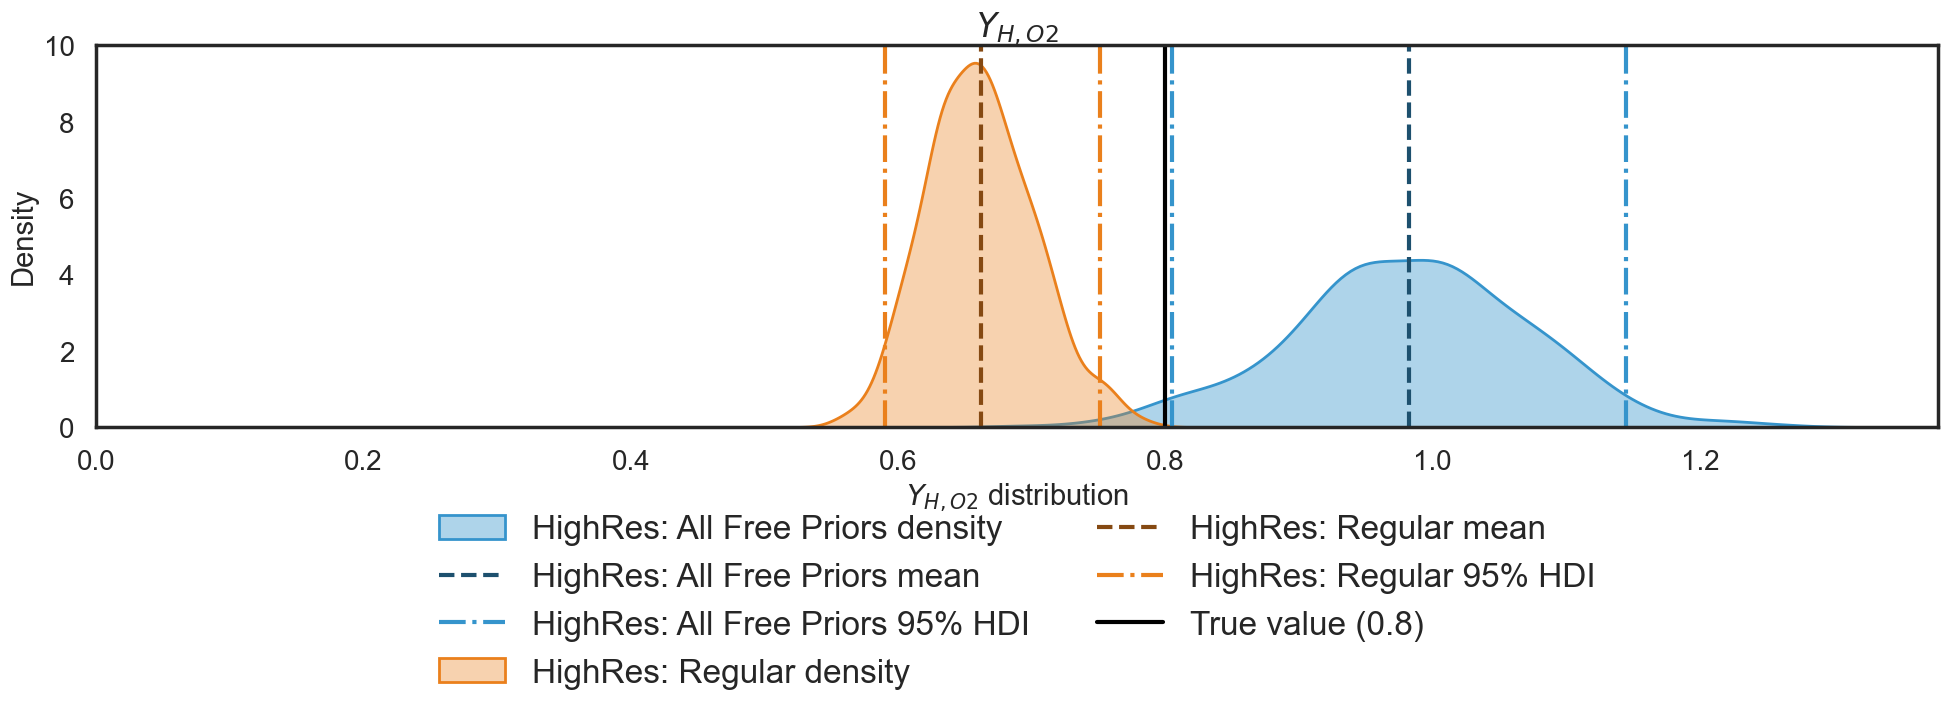

In [16]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ----------------------------------------------------------
## Choose two scenarios compare with overlays
# ----------------------------------------------------------

# case: "HighRes", "Routine", "Active", "LongActive", "LongRoutine"
# method: "Sampling_AllFreeNonInformative", "Sampling_AllFreePriors", "Sampling_AllFreeTight", "Sampling_FixedNoIdentifiability", "Sampling_Regular"

sel_a = ScenarioSel(
    case="HighRes",  
    method="Sampling_AllFreePriors",            
    label="HighRes: All Free Priors")
sel_b = ScenarioSel(
    case="HighRes",  
    method="Sampling_Regular", 
    label="HighRes: Regular")

# Plot a few key parameters (or set params=None for all)
# params_to_show = None
params_to_show = ["Y_H_O2"]

plot_overlay_two(
    sel_a=sel_a,
    sel_b=sel_b,
    cases_registry=cases,
    params=params_to_show,
    fontsize=24,
    figsize=(20, 8)
)


In [17]:
# ----------------------------------------------------------
# Predictive compounds for ONE case+method:
# - simulate posterior predictive (per-theta sample)
# - aggregate to mean & CI
# - save JSON (+ tidy CSV)
# - plot compounds with data, CI, and true line
# ----------------------------------------------------------

# ---------- Configurable defaults ----------
PRED_DIRNAME = "Predictions"   # subfolder under Results/<case>/<method>
PRED_JSON    = "predictive_compounds_ci.json"
PRED_CSV     = "predictive_compounds_ci.csv"

@dataclass
class PredictiveSpec:
    case: str
    method: str
    label: str = ""         # optional label for figures/legends
    ci_level: float = 0.95  # e.g., 0.95 or 0.99
    num_samples: Optional[int] = None  # None -> all saved rows in theta_samples.csv
    t_eval: Optional[np.ndarray] = None  # if None, infer from influent 'Time'

# ---------- Small IO helpers ----------


def _predictions_dir(case: str, method: str) -> Path:
    return RESULTS_DIR / case / method / PRED_DIRNAME

def _predictions_json(case: str, method: str) -> Path:
    return _predictions_dir(case, method) / PRED_JSON

def _predictions_csv(case: str, method: str) -> Path:
    return _predictions_dir(case, method) / PRED_CSV

def _nonneg(x):
    """Clip scalars/arrays/Series to be >= 0."""
    if x is None:
        return None
    return np.clip(x, 0.0, None)


def _case_influent_states_df(case: str) -> pd.DataFrame:
    """Load influent states CSV for a case."""
    return pd.read_csv(_influent_states_csv_path(case))

def _case_effluent_comp_flow_df(case: str) -> pd.DataFrame:
    """Load effluent compounds (for Flowrate) CSV for a case."""
    return pd.read_csv(_compounds_csv_path(case))

def _extend_timeseries_with_fallback(
    primary_df: pd.DataFrame,
    fallback_df: pd.DataFrame,
    t_target_max: float,
    *,
    time_col: str = "Time",
) -> pd.DataFrame:
    """
    Concatenate `primary_df` up to its max time, and if t_target_max exceeds that,
    append a slice of `fallback_df` starting at 0 and shifted forward so time is continuous.
    """
    if primary_df.empty:
        raise ValueError("Primary dataframe is empty; cannot extend.")
    if fallback_df.empty:
        raise ValueError("Fallback dataframe is empty; cannot extend.")

    # Ensure sorted by time
    primary = primary_df.sort_values(time_col).copy()
    fallback = fallback_df.sort_values(time_col).copy()

    t_primary_max = float(primary[time_col].max())
    if t_target_max <= t_primary_max + 1e-12:
        # Already enough coverage; trim to t_target_max window (keep everything, interpolation will handle)
        return primary

    need_span = t_target_max - t_primary_max

    # Take fallback rows from 0 up to `need_span`
    # If fallback shorter than needed, just take all it has (could be extended later to tile if desired)
    fb_slice = fallback[fallback[time_col] <= need_span].copy()
    if fb_slice.empty:
        # If nothing <= need_span, at least take the first row (constant edge case)
        fb_slice = fallback.iloc[[0]].copy()

    # Shift fallback times so they continue after primary
    fb_slice[time_col] = fb_slice[time_col] + t_primary_max

    # Concatenate
    out = pd.concat([primary, fb_slice], ignore_index=True)
    # Drop any accidental duplicates and enforce strictly increasing time if possible
    out = out.drop_duplicates(subset=[time_col]).sort_values(time_col).reset_index(drop=True)
    return out

def _build_influent_and_flow_with_fallback(
    case: str,
    t_eval: np.ndarray,
    *,
    fallback_case: str = "HighRes",
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Return (influent_np, flow_times, flow_vals) that cover the full t_eval.
    Uses `case` data up to its max time, then switches to `fallback_case` data (time-shifted)
    for the remaining interval.
    """
    if t_eval is None or len(t_eval) == 0:
        raise ValueError("t_eval is empty")
    t_max_needed = float(np.asarray(t_eval, dtype=float).max())

    prim_infl = _case_influent_states_df(case)
    prim_flow = _case_effluent_comp_flow_df(case)[["Time", "Flowrate"]]

    # Simple pass-through when fully covered
    if float(prim_infl["Time"].max()) >= t_max_needed and float(prim_flow["Time"].max()) >= t_max_needed:
        return prim_infl.to_numpy(), prim_flow["Time"].to_numpy(), prim_flow["Flowrate"].to_numpy()

    # Fallback sources
    fb_infl = _case_influent_states_df(fallback_case)
    fb_flow = _case_effluent_comp_flow_df(fallback_case)[["Time", "Flowrate"]]

    # Extended influent and flow with concatenation
    ext_infl = _extend_timeseries_with_fallback(prim_infl, fb_infl, t_max_needed, time_col="Time")
    ext_flow = _extend_timeseries_with_fallback(prim_flow, fb_flow, t_max_needed, time_col="Time")

    return ext_infl.to_numpy(), ext_flow["Time"].to_numpy(), ext_flow["Flowrate"].to_numpy()



# ---------- Core compute ----------
def _compute_compounds_from_states(time: np.ndarray, Y: np.ndarray, flow_times: np.ndarray, flow_vals: np.ndarray) -> pd.DataFrame:
    """
    Y shape: (n_states, n_time). Uses your model’s state layout.
    Returns DataFrame with Time, Flowrate, COD, NH4+NH3, NO3+NO2, TKN, Alkalinity, TSS
    """
    qout = np.interp(time, flow_times, flow_vals)

    # Indices (your comments)
    COD = (Y[1] + Y[2] + Y[7] + Y[8] + Y[10] + Y[9] + Y[11])
    NH4 = Y[3]
    NOx = Y[5]
    TKN = Y[3] + Y[4]
    ALK = Y[6]
    TSS = Y[12]

    # Ensure non-negative
    COD = _nonneg(COD)
    NH4 = _nonneg(NH4)
    NOx = _nonneg(NOx)
    TKN = _nonneg(TKN)
    ALK = _nonneg(ALK)
    TSS = _nonneg(TSS)

    return pd.DataFrame({
        "Time": time,
        "Flowrate": qout,
        "COD": COD,
        "NH4+NH3": NH4,
        "NO3+NO2": NOx,
        "TKN": TKN,
        "Alkalinity": ALK,
        "TSS": TSS
    })


def _simulate_one_theta_job(
    theta_vec: np.ndarray,
    t_eval: np.ndarray,
    y0: np.ndarray,
    influent_np: np.ndarray,
    reactor_volumes: list[float],
    flow_times: np.ndarray,
    flow_vals: np.ndarray,
    solver: str = "LSODA",
    rtol: float = 1e-6,
    atol: float = 1e-8,
    max_step: float | None = 0.5,
) -> pd.DataFrame:
    """
    Run one ODE solve for a single theta vector and return the compounds DataFrame.
    Kept top-level so joblib can pickle it (works on Windows/macOS/Linux).
    """
    t_span = (float(t_eval[0]), float(t_eval[-1]))

    def f(t, y):
        return ode_system_wrapper(t, y, theta_vec, influent_np, reactor_volumes)

    kwargs = dict(method=solver, rtol=rtol, atol=atol, t_eval=t_eval)
    if max_step is not None:
        kwargs["max_step"] = max_step

    sol = solve_ivp(f, t_span=t_span, y0=y0, **kwargs)
    if sol.status < 0:
        # Return NaNs if solver fails
        return pd.DataFrame(np.nan, index=range(len(t_eval)), columns=[
            "Time", "Flowrate", "COD", "NH4+NH3", "NO3+NO2", "TKN", "Alkalinity", "TSS"
        ])
    return _compute_compounds_from_states(sol.t, sol.y, flow_times, flow_vals)


def simulate_predictive(
    spec: PredictiveSpec,
    overwrite: bool = False,
    *,
    n_jobs: int = 1,
    solver_method: str = "LSODA",
    rtol: float = 1e-6,
    atol: float = 1e-8,
    max_step: float | None = 0.5,

) -> tuple[pd.DataFrame, dict]:
    """
    Simulate posterior predictive for one case+method.
    Supports parallel ODE solves via joblib with tqdm progress bar.
    """
    out_json = _predictions_json(spec.case, spec.method)
    out_csv  = _predictions_csv(spec.case, spec.method)
    out_dir  = _predictions_dir(spec.case, spec.method)
    out_dir.mkdir(parents=True, exist_ok=True)

    # from the json and csv
    # if out_json.exists() and out_csv.exists() and not overwrite:
    #     with open(out_json, "r") as f:
    #         obj = json.load(f)
    #     tidy = pd.read_csv(out_csv)
    #     print(f"Loaded existing data from {out_json} and {out_csv}")
    #     return tidy, obj


    # from the CSV only
    if out_csv.exists() and not overwrite:
        tidy = pd.read_csv(out_csv)
        print(f"Loaded existing data from {out_csv}")

        # Reconstruct `obj` in the same structure as when we compute from scratch
        # Assumes tidy has columns: Time, compound, mean, [median], lower, upper
        time_vals = np.sort(tidy["Time"].unique())
        has_median = "median" in tidy.columns

        compounds_dict: dict[str, dict[str, list[float]]] = {}
        for comp in sorted(tidy["compound"].unique()):
            sub = (
                tidy[tidy["compound"] == comp]
                .sort_values("Time")
                .reset_index(drop=True)
            )
            compounds_dict[comp] = {
                "mean":   sub["mean"].astype(float).tolist(),
                "median": (sub["median"] if has_median else sub["mean"]).astype(float).tolist(),
                "lower":  sub["lower"].astype(float).tolist(),
                "upper":  sub["upper"].astype(float).tolist(),
            }

        obj = {
            "meta": {
                "case": spec.case,
                "method": spec.method,
                "label": spec.label,
                "ci_level": spec.ci_level,
                # best-effort: use spec.num_samples if given, else NaN
                "num_samples": int(spec.num_samples) if spec.num_samples is not None else np.nan,
            },
            "time": list(map(float, time_vals)),
            "compounds": compounds_dict,
        }

        return tidy, obj

    # --- Load theta samples & meta ---
    theta_df, _meta = load_theta_samples_and_meta(spec.case, spec.method)
    if spec.num_samples is not None and spec.num_samples < len(theta_df):
        theta_df = theta_df.sample(n=spec.num_samples, random_state=0).reset_index(drop=True)


        # Build t_eval (prefer the case's native grid if not provided)
    influent_states_native = pd.read_csv(_influent_states_csv_path(spec.case))
    time_ref = influent_states_native["Time"].to_numpy()
    t_eval = np.asarray(spec.t_eval if spec.t_eval is not None else time_ref, dtype=float)
    t_span = (float(t_eval[0]), float(t_eval[-1]))

    y0 = get_reactor_initial_values(TOP_DIR)

    # influent & flow that extend beyond case end by switching to HighRes when data is beyond available
    influent_np, flow_times, flow_vals = _build_influent_and_flow_with_fallback(
        spec.case, t_eval, fallback_case="HighRes"
    )

    # influent_states = pd.read_csv(_influent_states_csv_path(spec.case))
    # time_ref = influent_states["Time"].to_numpy()
    # t_eval = np.asarray(spec.t_eval if spec.t_eval is not None else time_ref, dtype=float)
    # t_span = (float(t_eval[0]), float(t_eval[-1]))

    # y0 = get_reactor_initial_values(TOP_DIR)
    # influent_np = influent_states.to_numpy()

    # eff_comp_path = _compounds_csv_path(spec.case)
    # eff_comp_df = pd.read_csv(eff_comp_path)
    # flow_times = eff_comp_df["Time"].to_numpy()
    # flow_vals  = eff_comp_df["Flowrate"].to_numpy()

    thetas = [theta_df.iloc[i].to_numpy(dtype=float) for i in range(len(theta_df))]

    # --- Parallelized with tqdm ---
    def run_parallel():
        iterator = (delayed(_simulate_one_theta_job)(
            th, t_eval, y0, influent_np, REACTOR_VOLUMES, flow_times, flow_vals,
            solver=solver_method, rtol=rtol, atol=atol, max_step=max_step
        ) for th in thetas)
        return Parallel(n_jobs=n_jobs, prefer="processes")(
            tqdm(iterator, total=len(thetas), desc=f"Simulating {spec.case} | {spec.method}", unit="θ")
        )

    preds = run_parallel() if n_jobs > 1 else [
        _simulate_one_theta_job(
            th, t_eval, y0, influent_np, REACTOR_VOLUMES, flow_times, flow_vals,
            solver=solver_method, rtol=rtol, atol=atol, max_step=max_step
        )
        for th in tqdm(thetas, desc=f"Simulating {spec.case} | {spec.method}", unit="θ")
    ]

    # --- Aggregate to mean & CI ---
    ci = spec.ci_level
    lo_q, hi_q = (100 * (1 - ci) / 2.0, 100 * (1 + ci) / 2.0)
    keys = ["COD", "NH4+NH3", "NO3+NO2", "TKN", "Alkalinity", "TSS"]

    agg = {"Time": t_eval}
    tidy_rows = []
    for k in keys:
        stack = np.stack([df[k].to_numpy() for df in preds], axis=0)
        mean = np.nanmean(stack, axis=0)
        median = np.nanmedian(stack, axis=0)
        lo   = np.nanpercentile(stack, lo_q, axis=0)
        hi   = np.nanpercentile(stack, hi_q, axis=0)

        # Ensure non-negative
        mean = _nonneg(mean)
        med  = _nonneg(median)
        lo   = _nonneg(lo)
        hi   = _nonneg(hi)

        agg[f"{k}_mean"]  = mean
        agg[f"{k}_median"] = med
        agg[f"{k}_lower"] = lo
        agg[f"{k}_upper"] = hi

        for t, m, md, l, u in zip(t_eval, mean, med, lo, hi):
            tidy_rows.append({
                "Time": t, 
                "compound": k, 
                "mean": float(m), 
                "median": float(md),
                "lower": float(l), 
                "upper": float(u)})

    tidy_df = pd.DataFrame(tidy_rows)
    obj = {
        "meta": {
            "case": spec.case,
            "method": spec.method,
            "label": spec.label,
            "ci_level": spec.ci_level,
            "num_samples": int(len(theta_df))
        },
        "time": list(map(float, t_eval)),
        "compounds": {
            k: {
                "mean": list(map(float, agg[f"{k}_mean"])),
                "median": list(map(float, agg[f"{k}_median"])),
                "lower": list(map(float, agg[f"{k}_lower"])),
                "upper": list(map(float, agg[f"{k}_upper"]))
            } for k in keys
        }
    }

    with open(out_json, "w") as f:
        json.dump(obj, f, indent=2)
    tidy_df.to_csv(out_csv, index=False)
    print(f"[saved] {out_json}")
    print(f"[saved] {out_csv}")
    return tidy_df, obj

# ---------- Plotting ----------
def plot_predictive_compounds(
    spec: PredictiveSpec,
    compounds: Optional[Iterable[str]] = None,
    center: str = "median",   # "median" (default) or "mean"
    point_alpha: float = 1.0,
    ci_alpha: float = 0.22,
    mean_lw: float = 2.5,
    true_lw: float = 2.5,
    fontsize: int = 18,
    fig_size: tuple[float, float] = (20, 8),
    markersize: float = 8.0,
    show_posterior_band: bool = True,
    show_noise_band: bool = False,
    noise_sigma_quantile: float | str = 0.5,
    ylims: Optional[tuple[float, float]] = None,
    ylims_per: Optional[dict[str, tuple[float, float]]] = None,
):
    """
    Plot compounds for one case+method using saved predictions.

    Bands & lines:
      • Posterior band (blue): parameter uncertainty. Width set by `spec.ci_level`.

      • Noise band (orange, smooth on the same grid tt as posterior): observation noise around the
        Its half-width is z * σ_source, where
           z = Φ^{-1}((1 + spec.ci_level)/2), and
           σ_source = Quantile_q(σ | data) if noise_sigma_quantile == q ∈ [0,1]
                      (NOTE: q=0.50 is the *median*, not the mean),
                    = mean(σ | data) if noise_sigma_quantile == "mean".

    Requires: simulate_true_effluent_for_case_on_grid(case, t_eval) defined elsewhere.
    """
    tidy, obj = simulate_predictive(spec, overwrite=False)
    eff_comp_df = pd.read_csv(_compounds_csv_path(spec.case))
    sigma_df = load_sigma_samples(spec.case, spec.method) if show_noise_band else pd.DataFrame(columns=SIGMA_VARS)
    z = norm.ppf(0.5 * (1.0 + spec.ci_level))

    all_keys = list(obj["compounds"].keys())
    use_keys = list(compounds) if compounds is not None else all_keys

    def _collect_for_limits(*arrays):
        vals = np.concatenate([np.asarray(a, dtype=float).ravel() for a in arrays if a is not None and len(a) > 0])
        vals = vals[~np.isnan(vals)]
        return vals

    for k in use_keys:
        if k not in all_keys:
            print(f"[skip] Unknown compound '{k}'")
            continue

        fig, ax = plt.subplots(figsize=fig_size)

        tt = np.array(obj["time"])
        post_lo = _nonneg(np.array(obj["compounds"][k]["lower"]))
        post_hi = _nonneg(np.array(obj["compounds"][k]["upper"]))
        if center.lower() == "median" and "median" in obj["compounds"][k]:
            post_center = _nonneg(np.array(obj["compounds"][k]["median"]))
        else:
            post_center = _nonneg(np.array(obj["compounds"][k]["mean"]))

        t_data = eff_comp_df["Time"].to_numpy()
        y_data = eff_comp_df[k].to_numpy()


        y_true_tt = None
        # Plot true effluent on grid if available
        try:
            true_on_grid = simulate_true_effluent_for_case(spec.case, tt)
            true_comp_tt = true_on_grid.get("compounds", pd.DataFrame())
            if not true_comp_tt.empty:
                y_true_tt = _nonneg(true_comp_tt[k].to_numpy())
                ax.plot(tt, y_true_tt, color="black", linestyle="--", lw=true_lw, label="True")
        except Exception as e:
            print(f"[note] Could not compute true on grid for '{k}': {e}")
            y_true_tt = None

        # Plot predictive mean/median line
        ax.plot(tt, post_center, color="C0", lw=mean_lw, label=f"Predictive {center}")

        noise_lo = noise_hi = None
        if show_noise_band and (y_true_tt is not None) and not sigma_df.empty:
            sigma_col = f"sigma_{'Alkalinity' if k=='Alkalinity' else ('NOx' if k=='NO3+NO2' else ('NH4' if k=='NH4+NH3' else k))}"
            if sigma_col in sigma_df.columns:
                sigma_vals = sigma_df[sigma_col].dropna().to_numpy()
                if sigma_vals.size > 0:
                    if isinstance(noise_sigma_quantile, str) and noise_sigma_quantile.lower() == "mean":
                        sigma_src = float(np.mean(sigma_vals))
                        sigma_source_label = "mean"
                    else:
                        q = float(noise_sigma_quantile)
                        q = min(1.0, max(0.0, q))
                        sigma_src = float(np.quantile(sigma_vals, q))
                        sigma_source_label = f"q={q:.2f}" + (" (median)" if abs(q - 0.5) < 1e-9 else "")
                    noise_lo = _nonneg(y_true_tt - z * sigma_src)
                    noise_hi = _nonneg(y_true_tt + z * sigma_src)
            else:
                print(f"[note] No sigma column found for '{k}' (looked for '{sigma_col}').")

        if show_posterior_band:
            ax.fill_between(tt, post_lo, post_hi, color="C0", alpha=ci_alpha,
                            label=f"{int(spec.ci_level*100)}% CI (posterior)")

        if show_noise_band and (noise_lo is not None) and (noise_hi is not None):
            label_tail = "mean" if sigma_source_label == "mean" else sigma_source_label
            ax.fill_between(tt, noise_lo, noise_hi, color="C1", alpha=ci_alpha * 0.9,
                            label=f"Noise band - {spec.case} (± z·σ[{label_tail}])")

        applied_limits = None
        if ylims_per and (k in ylims_per) and ylims_per[k] is not None:
            applied_limits = ylims_per[k]
        elif ylims is not None:
            applied_limits = ylims

        if applied_limits is not None:
            ax.set_ylim(*applied_limits)
        else:
            y_candidates = [y_data, post_lo, post_hi, post_center]
            if y_true_tt is not None:
                y_candidates.append(y_true_tt)
            if (noise_lo is not None) and (noise_hi is not None):
                y_candidates.extend([noise_lo, noise_hi])

            all_y = _collect_for_limits(*y_candidates)
            if all_y.size > 0:
                ymin, ymax = max(0.0, float(np.nanmin(all_y))), float(np.nanmax(all_y))
                if not np.isfinite(ymin) or not np.isfinite(ymax) or ymax <= ymin:
                    ymin, ymax = 0.0, 1.0
                pad = 0.06 * (ymax - ymin)
                ax.set_ylim(ymin - pad if ymin > 0 else 0.0, ymax + pad)

        # Plot data points
        ax.plot(t_data, y_data, ".", color="black", alpha=point_alpha, markersize=markersize, label=f"{k} data")

        # ax.set_title(f"{k} — {spec.case} | {spec.method}", fontsize=fontsize)
        ax.set_xlabel("Time (days)", fontsize=fontsize)
        ax.set_ylabel(f"{k} (mg/L)", fontsize=fontsize)
        ax.set_xlim(min(tt), max(tt))
        ax.tick_params(axis="both", labelsize=int(fontsize * 0.9))
        ax.grid(False)

        handles, labels = ax.get_legend_handles_labels()
        desired_order = [
            f"{k} data",
            "True",
            "Predictive mean",
            f"{int(spec.ci_level*100)}% CI (posterior)",
        ]
        desired_order += [lab for lab in labels if lab.startswith(f"Noise band")]

        seen, final_h, final_l = set(), [], []
        for name in desired_order:
            for h, l in zip(handles, labels):
                if l == name and l not in seen:
                    seen.add(l); final_h.append(h); final_l.append(l)
        for h, l in zip(handles, labels):
            if l not in seen:
                seen.add(l); final_h.append(h); final_l.append(l)

        ax.legend(final_h, final_l, loc="upper center", bbox_to_anchor=(0.5, -0.20),
                  ncol=3, frameon=False, fontsize=fontsize)
        fig.subplots_adjust(bottom=0.3)
        plt.tight_layout()
        plt.show()

In [18]:
# ----------------------------------------------------------
# Helpers - Compare two scenarios on a shared time grid (max of both)
# ----------------------------------------------------------

def _max_data_time(case: str) -> float:
    """Return the max Time found in the effluent compounds CSV for a case."""
    df = pd.read_csv(_compounds_csv_path(case))
    return float(df["Time"].max()) if not df.empty else 0.0

def _build_shared_time_grid(case_a: str, case_b: str, n: int = 1000) -> np.ndarray:
    """Use the max data extent among the two cases to define a common t_eval."""
    ta = _max_data_time(case_a)
    tb = _max_data_time(case_b)
    t_max = max(ta, tb)
    if t_max <= 0:
        raise ValueError("No data time found for the chosen cases.")
    return np.linspace(0.0, t_max, n)

def _clone_spec_with_t(spec: PredictiveSpec, t_eval: np.ndarray) -> PredictiveSpec:
    """Return a copy of spec but with a new t_eval (and keep other fields)."""
    return PredictiveSpec(
        case=spec.case,
        method=spec.method,
        label=spec.label,
        ci_level=spec.ci_level,
        num_samples=spec.num_samples,
        t_eval=t_eval
    )

def _interp_compound_to_grid(obj: dict, compound: str, tt: np.ndarray) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    """
    Return (mean, lower, upper) for `compound` from `obj` interpolated onto `tt`.
    Handles cached results saved on a different time grid.
    """
    t_old = np.asarray(obj["time"], dtype=float)
    # Ensure strictly increasing & unique for interpolation
    t_old, unique_idx = np.unique(t_old, return_index=True)

    def _interp(field: str) -> np.ndarray:
        y_old = np.asarray(obj["compounds"][compound][field], dtype=float)[unique_idx]
        y_new = np.interp(tt, t_old, y_old)
        return _nonneg(y_new)

    mean = _interp("mean")
    lo   = _interp("lower")
    hi   = _interp("upper")
    return mean, lo, hi


# ---------- Plotting comparison of two scenarios ----------
def plot_predictive_compounds_compare(
    spec_a: PredictiveSpec,
    spec_b: PredictiveSpec,
    compounds: Optional[Iterable[str]] = None,
    n_grid: int = 1000,
    overwrite_predictive: bool = False,
    point_alpha_a: float = 0.9,
    point_alpha_b: float = 0.6,
    ci_alpha: float = 0.22,
    mean_lw: float = 2.6,
    true_lw: float = 2.2,
    fontsize: int = 18,
    fig_size: tuple[float, float] = (20, 8),
    show_posterior_band: bool = True,
    show_noise_band: bool = False,
    noise_sigma_quantile: float | str = 0.5,
    compute_kwargs: dict | None = None,
    parallelize_scenarios: bool = False,
    outer_n_jobs: int = 2,
    ylims: Optional[tuple[float, float]] = None,
    ylims_per: Optional[dict[str, tuple[float, float]]] = None,
):
    """
    Compare posterior & predictive bands for two scenarios, now using the parallel ODE compute in simulate_predictive.
    Plotting and visual styling are unchanged.

    compute_kwargs -> forwarded to simulate_predictive, e.g. {"n_jobs": 10, ...}
    parallelize_scenarios -> if True, run spec A and B in parallel (each may itself use n_jobs>1).
                              Beware of CPU oversubscription if both levels are >1.
    """
    # Shared time base
    tt = _build_shared_time_grid(spec_a.case, spec_b.case, n=n_grid)
    specA = _clone_spec_with_t(spec_a, tt)
    specB = _clone_spec_with_t(spec_b, tt)

    # Defaults for compute if not provided
    _ckw = dict(n_jobs=1, solver_method="LSODA", rtol=1e-6, atol=1e-8, max_step=0.5)
    if compute_kwargs:
        _ckw.update(compute_kwargs)

    # Compute predictive summaries (sequential by default; optional concurrent)
    if parallelize_scenarios:
        # NOTE: If you set compute_kwargs["n_jobs"] > 1 here, two scenarios will each spin up workers.
        # That can oversubscribe your CPU. Consider dropping inner n_jobs when parallelizing scenarios.
        results = Parallel(n_jobs=outer_n_jobs, prefer="processes")(
            delayed(simulate_predictive)(sp, overwrite=overwrite_predictive, **_ckw)
            for sp in tqdm([specA, specB], desc="Computing scenarios", unit="scenario")
        )
        (_, objA), (_, objB) = results[0], results[1]
    else:
        _, objA = simulate_predictive(specA, overwrite=overwrite_predictive, **_ckw)
        _, objB = simulate_predictive(specB, overwrite=overwrite_predictive, **_ckw)

    # Load observed data
    data_a = pd.read_csv(_compounds_csv_path(specA.case))
    data_b = pd.read_csv(_compounds_csv_path(specB.case))
    same_case = (specA.case == specB.case)

    # True lines
    trueA = simulate_true_effluent_for_case(specA.case, tt).get("compounds", pd.DataFrame())
    trueB = simulate_true_effluent_for_case(specB.case, tt).get("compounds", pd.DataFrame())

    # Ensure true lines are clipped to non-negative
    if not trueA.empty:
        y_true_A = trueA.clip(lower=0.0)
    if not trueB.empty:
        y_true_B = trueB.clip(lower=0.0)

    # σ samples (if asked)
    sigA = load_sigma_samples(specA.case, specA.method) if show_noise_band else pd.DataFrame(columns=SIGMA_VARS)
    sigB = load_sigma_samples(specB.case, specB.method) if show_noise_band else pd.DataFrame(columns=SIGMA_VARS)

    zA = norm.ppf(0.5 * (1.0 + specA.ci_level))
    zB = norm.ppf(0.5 * (1.0 + specB.ci_level))

    keysA = list(objA["compounds"].keys())
    keysB = list(objB["compounds"].keys())
    use_keys = list(compounds) if compounds is not None else sorted(set(keysA) & set(keysB))

    def _sigma_for(compound: str, sig_df: pd.DataFrame, q: float | str) -> tuple[Optional[float], str]:
        if sig_df.empty:
            return None, ""
        s_col = f"sigma_{'Alkalinity' if compound=='Alkalinity' else ('NOx' if compound=='NO3+NO2' else ('NH4' if compound=='NH4+NH3' else compound))}"
        if s_col not in sig_df.columns:
            return None, ""
        vals = sig_df[s_col].dropna().to_numpy()
        if vals.size == 0:
            return None, ""
        if isinstance(q, str) and q.lower() == "mean":
            return float(np.mean(vals)), "mean"
        qf = min(1.0, max(0.0, float(q)))
        src = float(np.quantile(vals, qf))
        tag = f"q={qf:.2f}" + (" (median)" if abs(qf - 0.5) < 1e-9 else "")
        return src, tag

    # Plotting
    for k in use_keys:
        fig, ax = plt.subplots(figsize=fig_size)

        # Data points
        if same_case:
            ax.plot(data_a["Time"], data_a[k], ".", color="black", alpha=point_alpha_a, label=f"{k} data — {specA.case}")
        else:
            ax.plot(data_a["Time"], data_a[k], ".", color="black", alpha=point_alpha_a, label=f"{k} data — {specA.case}")
            ax.plot(data_b["Time"], data_b[k], ".", color="gray",  alpha=point_alpha_b, label=f"{k} data — {specB.case}")

        # True lines
        if same_case:
            if not trueA.empty:
                ax.plot(tt, trueA[k].to_numpy(), "--", color="black", lw=true_lw, label=f"True — {specA.case}")
        else:
            if not trueA.empty:
                ax.plot(tt, trueA[k].to_numpy(), "--", color="black",   lw=true_lw, label=f"True — {specA.case}")
            if not trueB.empty:
                ax.plot(tt, trueB[k].to_numpy(), "--", color="dimgray", lw=true_lw, label=f"True — {specB.case}")

        # Interpolate both scenarios to the shared grid `tt`
        meanA, loA, hiA = _interp_compound_to_grid(objA, k, tt)
        meanB, loB, hiB = _interp_compound_to_grid(objB, k, tt)

        ax.plot(tt, meanA, color=COL_MEAN_A, lw=mean_lw, label=f"Predictive mean — {specA.method}")
        ax.plot(tt, meanB, color=COL_MEAN_B, lw=mean_lw, label=f"Predictive mean — {specB.method}")

        if show_posterior_band:
            ax.fill_between(tt, loA, hiA, color=COL_A, alpha=ci_alpha,
                            label=f"{int(specA.ci_level*100)}% CI — {specA.method}", linewidth=0.6, edgecolor=COL_A)
            ax.fill_between(tt, loB, hiB, color=COL_B, alpha=ci_alpha,
                            label=f"{int(specB.ci_level*100)}% CI — {specB.method}", linewidth=0.6, edgecolor=COL_B)

        if show_noise_band:
            sA, tagA = _sigma_for(k, sigA, noise_sigma_quantile)
            sB, tagB = _sigma_for(k, sigB, noise_sigma_quantile)
            if sA is not None:
                centerA = (y_true_A if y_true_A is not None else meanA)
                lo_nb_A = _nonneg(centerA - zA * sA)
                hi_nb_A = _nonneg(centerA + zA * sA)
                ax.fill_between(tt, lo_nb_A, hi_nb_A, color=COL_A, alpha=ci_alpha * 0.55,
                                label=f"Noise band — {specA.method} (σ[{tagA}])", linewidth=0.6, edgecolor=COL_A)
            if sB is not None:
                centerB = (y_true_B if (y_true_B is not None and not same_case) else meanB)
                lo_nb_B = _nonneg(centerB - zB * sB)
                hi_nb_B = _nonneg(centerB + zB * sB)
                ax.fill_between(tt, lo_nb_B, hi_nb_B, color=COL_B, alpha=ci_alpha * 0.55,
                                label=f"Noise band — {specB.method} (σ[{tagB}])", linewidth=0.6, edgecolor=COL_B)

        # Axis scaling
        applied_limits = None
        if ylims_per and (k in ylims_per) and ylims_per[k] is not None:
            applied_limits = ylims_per[k]
        elif ylims is not None:
            applied_limits = ylims

        if applied_limits is not None:
            ax.set_ylim(*applied_limits)
        else:
            y_cands = [loA, hiA, meanA, loB, hiB, meanB, data_a[k].to_numpy()]
            if not same_case and k in data_b.columns:
                y_cands.append(data_b[k].to_numpy())
            if y_true_A is not None: y_cands.append(y_true_A)
            if y_true_B is not None and not same_case: y_cands.append(y_true_B)

            all_y = np.concatenate([np.asarray(v, float).ravel() for v in y_cands if v is not None])
            all_y = all_y[~np.isnan(all_y)]
            if all_y.size > 0:
                ymin, ymax = max(0.0, float(np.nanmin(all_y))), float(np.nanmax(all_y))
                pad = 0.06 * (ymax - ymin)
                ax.set_ylim(ymin - pad if ymin > 0 else 0.0, ymax + pad)


        # Labels & legend
        ax.set_title(f"{k} — Compare: {specA.method} vs {specB.method}", fontsize=fontsize)
        ax.set_xlabel("Time (days)", fontsize=fontsize)
        ax.set_ylabel(f"{k} (mg/L)", fontsize=fontsize)
        ax.set_xlim(tt.min(), tt.max())
        ax.tick_params(axis="both", labelsize=int(fontsize * 0.9))
        ax.grid(False)
        leg = ax.legend(
            frameon=False,
            fontsize=int(fontsize),
            loc="upper center",
            bbox_to_anchor=(0.5, -0.16),
            ncol=3,
            borderaxespad=0.0,
        )
        plt.tight_layout(rect=[0, 0.12, 1, 1])
        plt.show()


Simulating LongActive | Sampling_Regular: 100%|██████████| 100/100 [00:05<00:00, 19.87θ/s]


[saved] c:\Users\ruanv\OneDrive - Stellenbosch University\University\Masters\Documents - Machine Learning at Process Engineering\Post-graduate students\Ruan van den Berg\Code\ThesisASM3\RunTemplate\8-Results\LongActive\Sampling_Regular\Predictions\predictive_compounds_ci.json
[saved] c:\Users\ruanv\OneDrive - Stellenbosch University\University\Masters\Documents - Machine Learning at Process Engineering\Post-graduate students\Ruan van den Berg\Code\ThesisASM3\RunTemplate\8-Results\LongActive\Sampling_Regular\Predictions\predictive_compounds_ci.csv
Loaded existing data from c:\Users\ruanv\OneDrive - Stellenbosch University\University\Masters\Documents - Machine Learning at Process Engineering\Post-graduate students\Ruan van den Berg\Code\ThesisASM3\RunTemplate\8-Results\LongActive\Sampling_Regular\Predictions\predictive_compounds_ci.csv


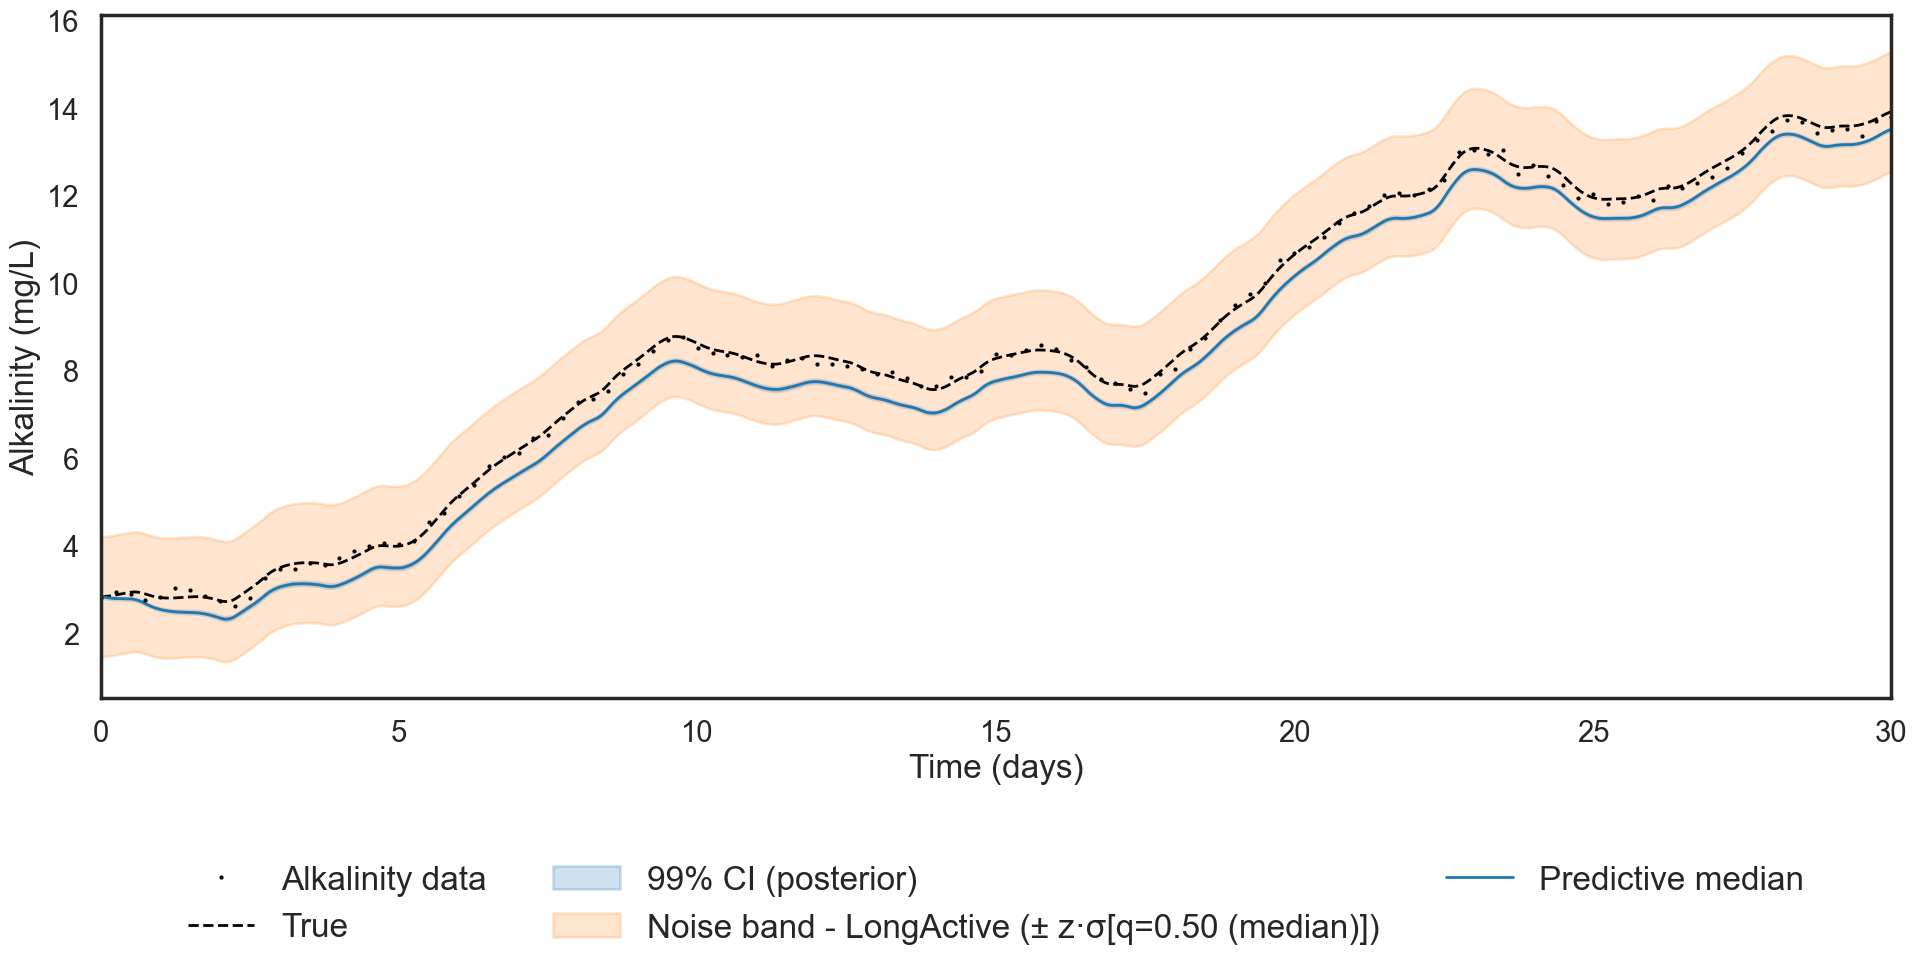

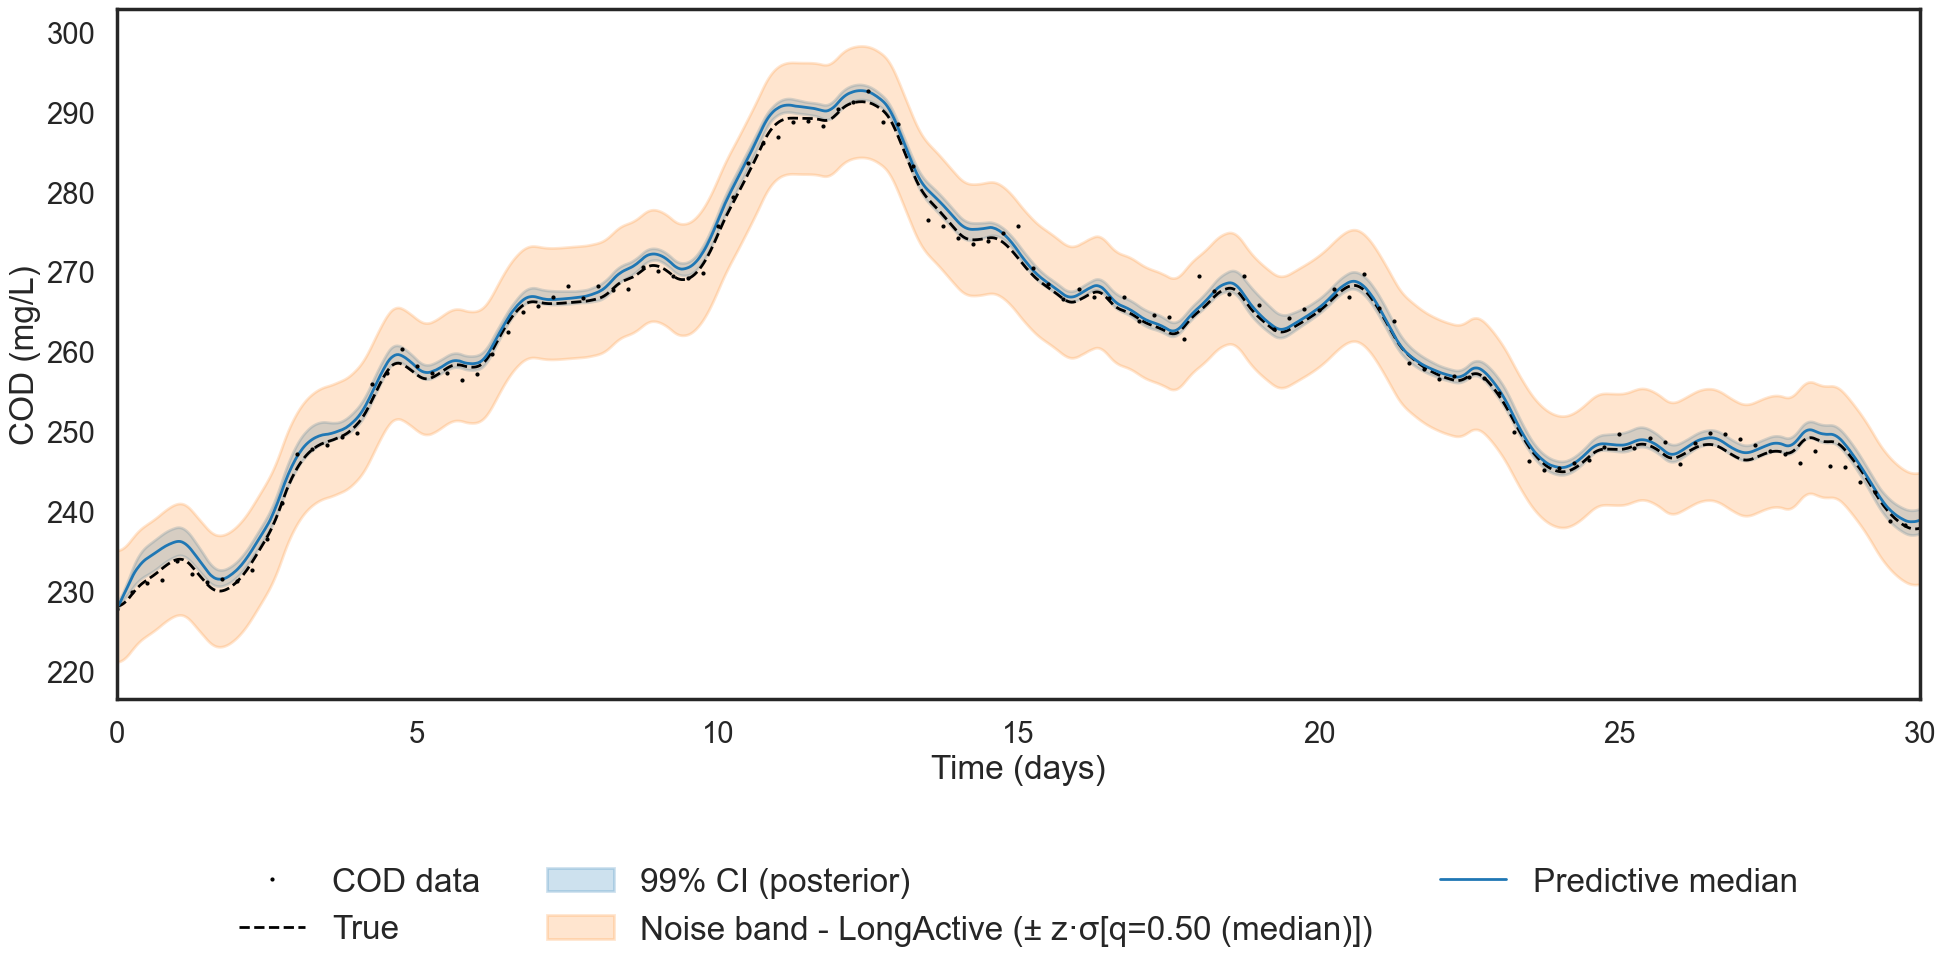

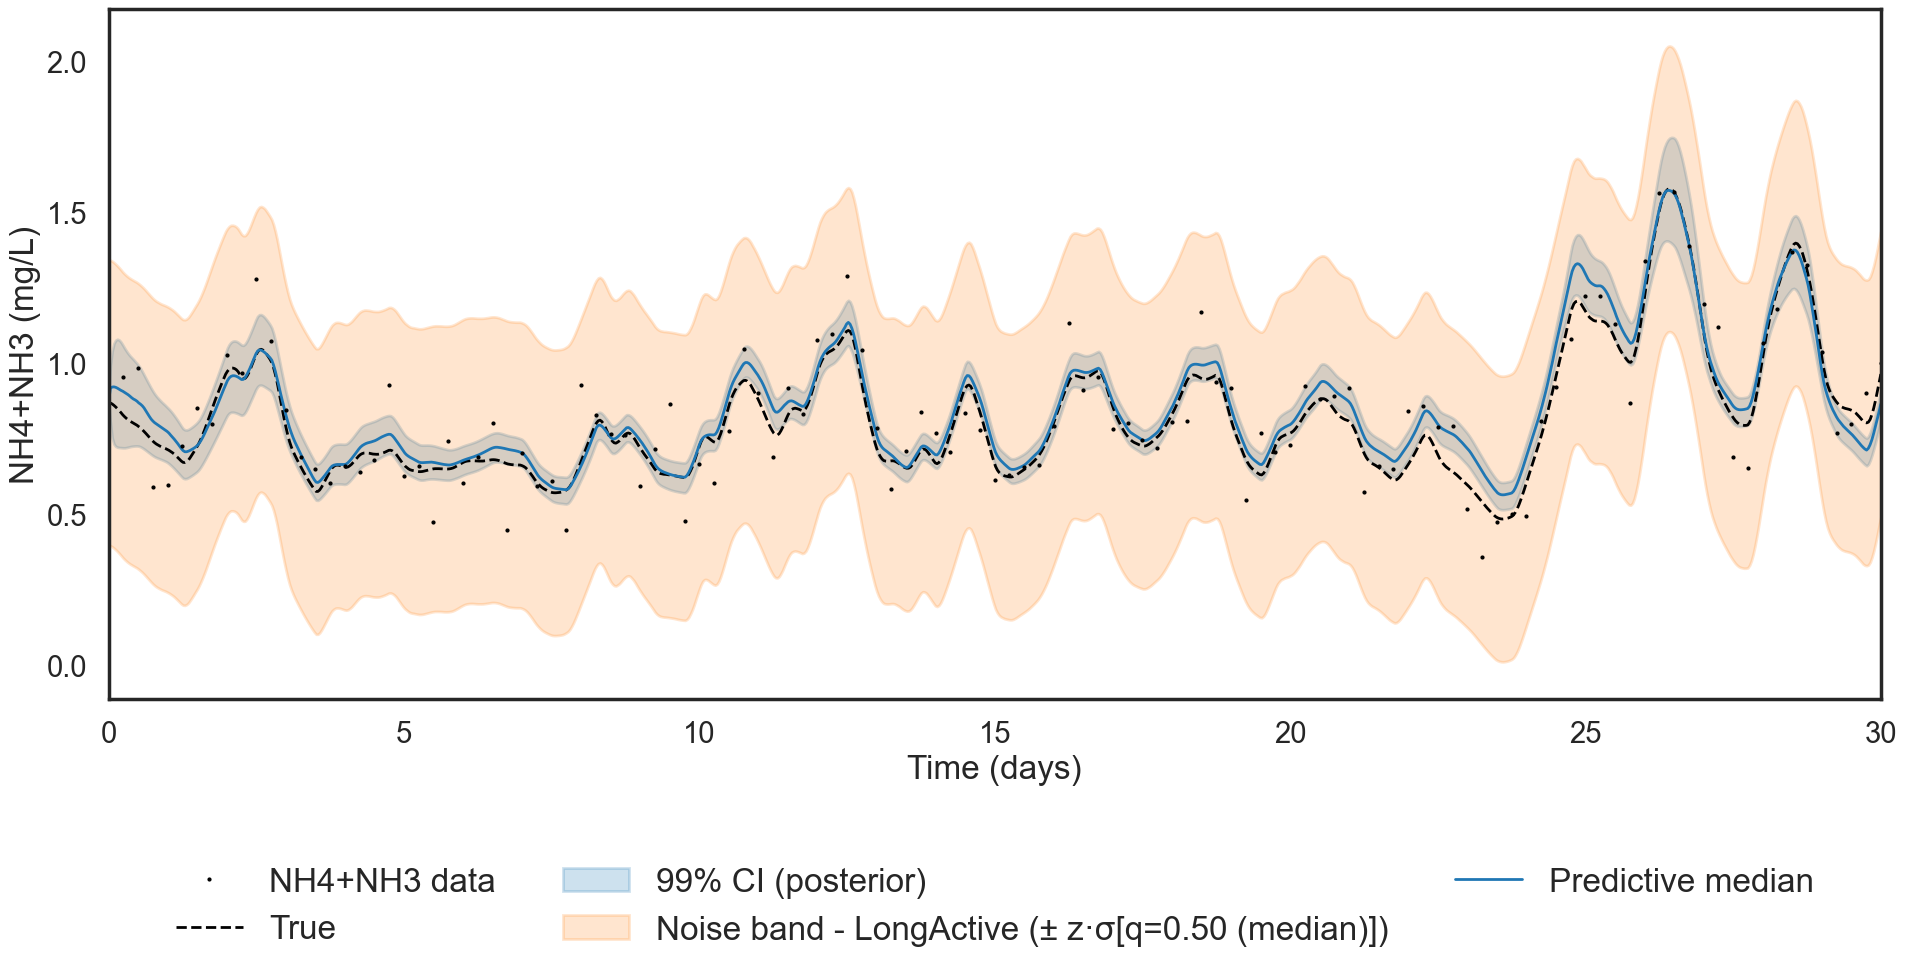

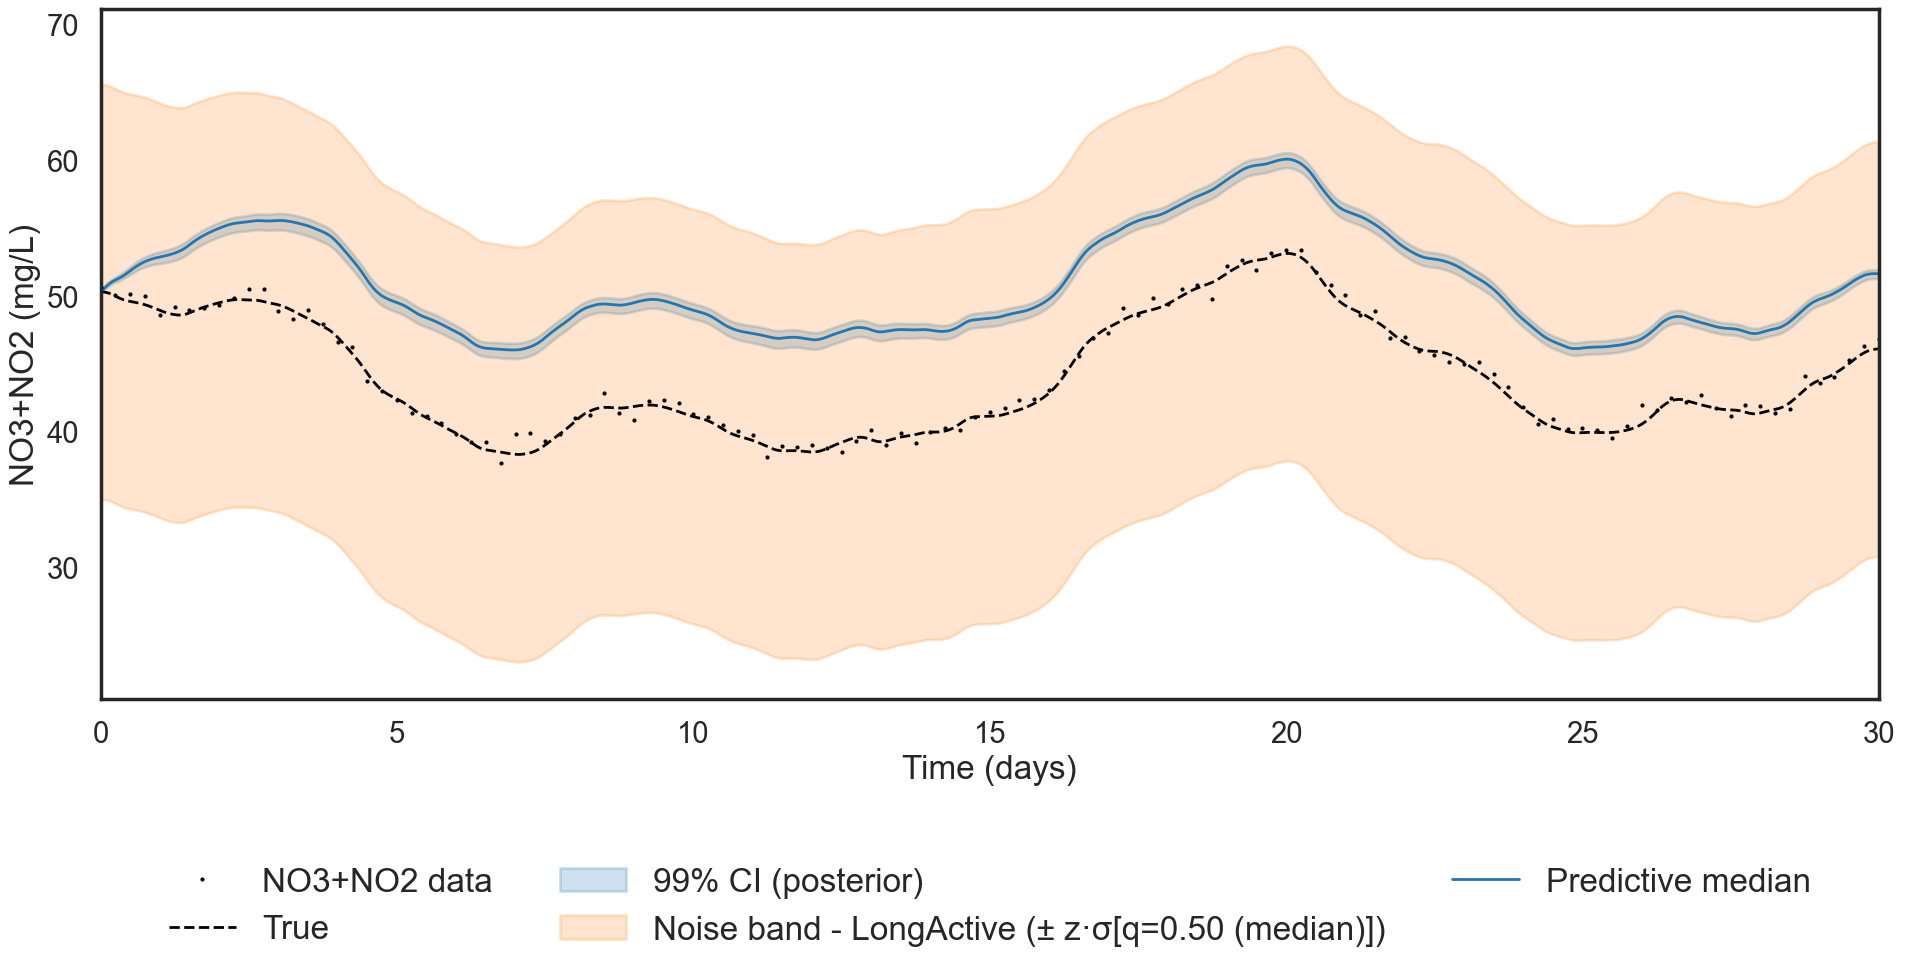

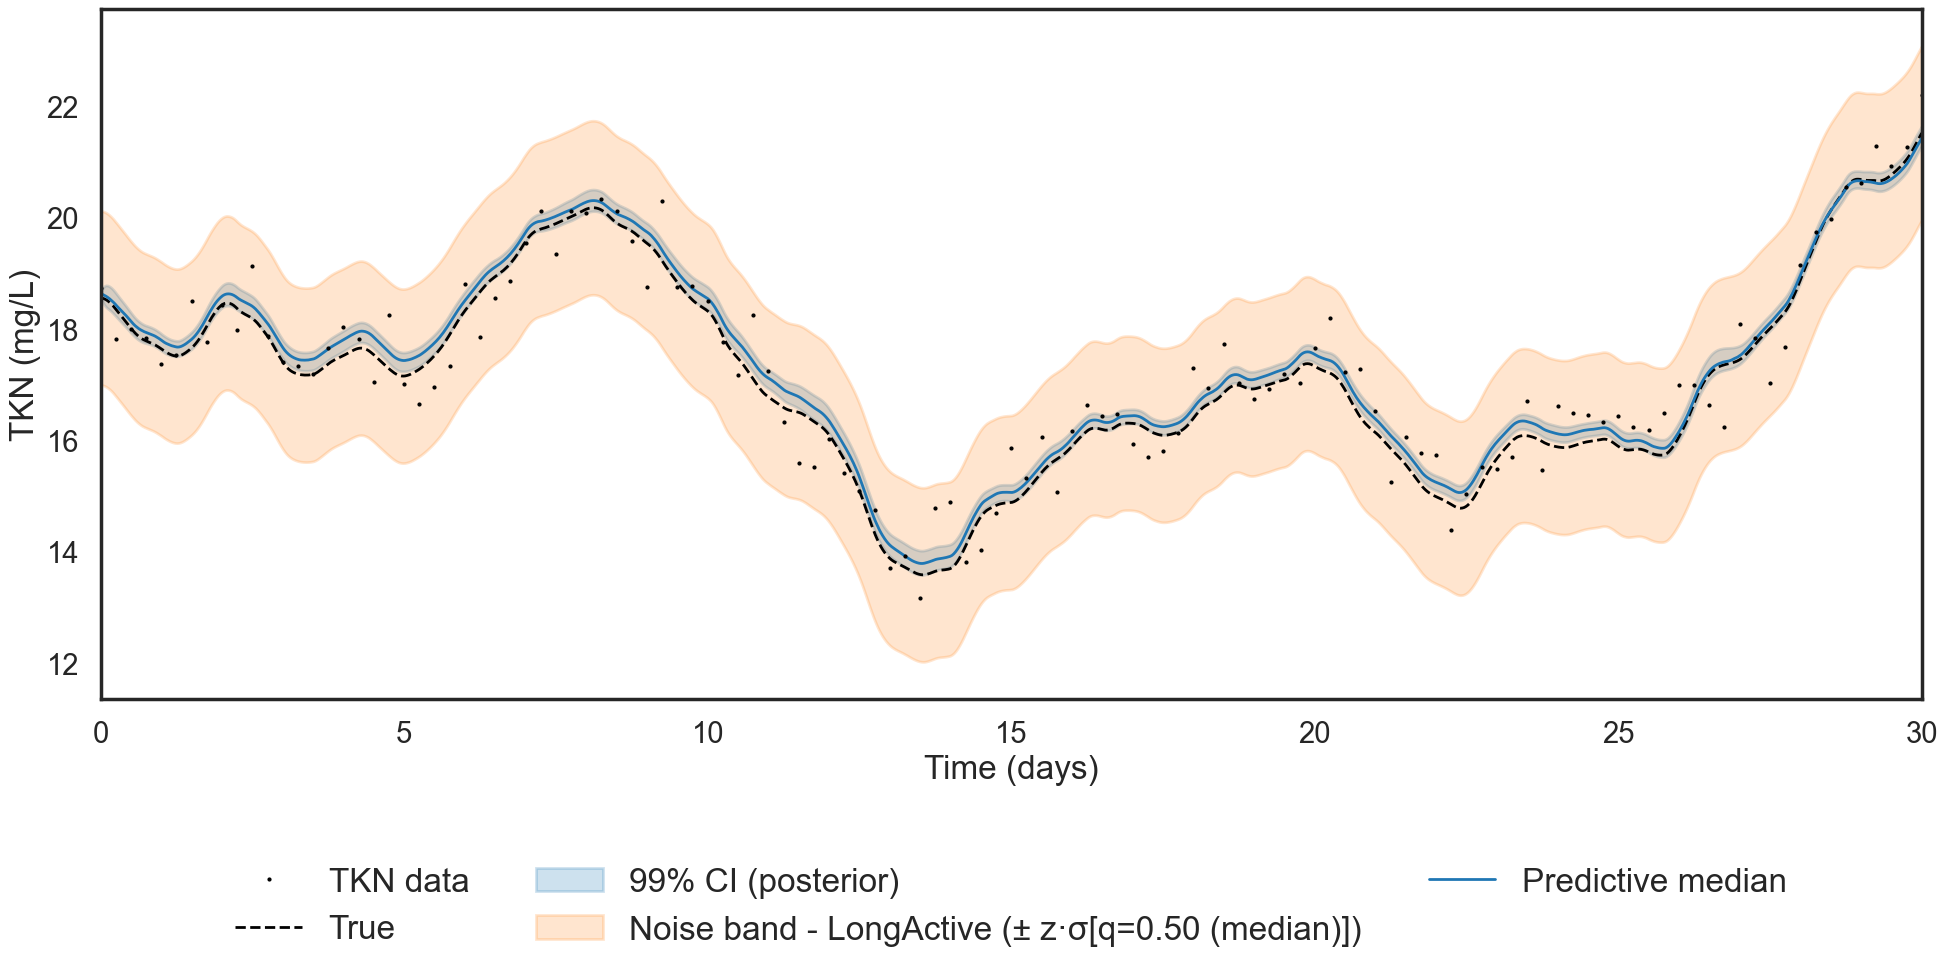

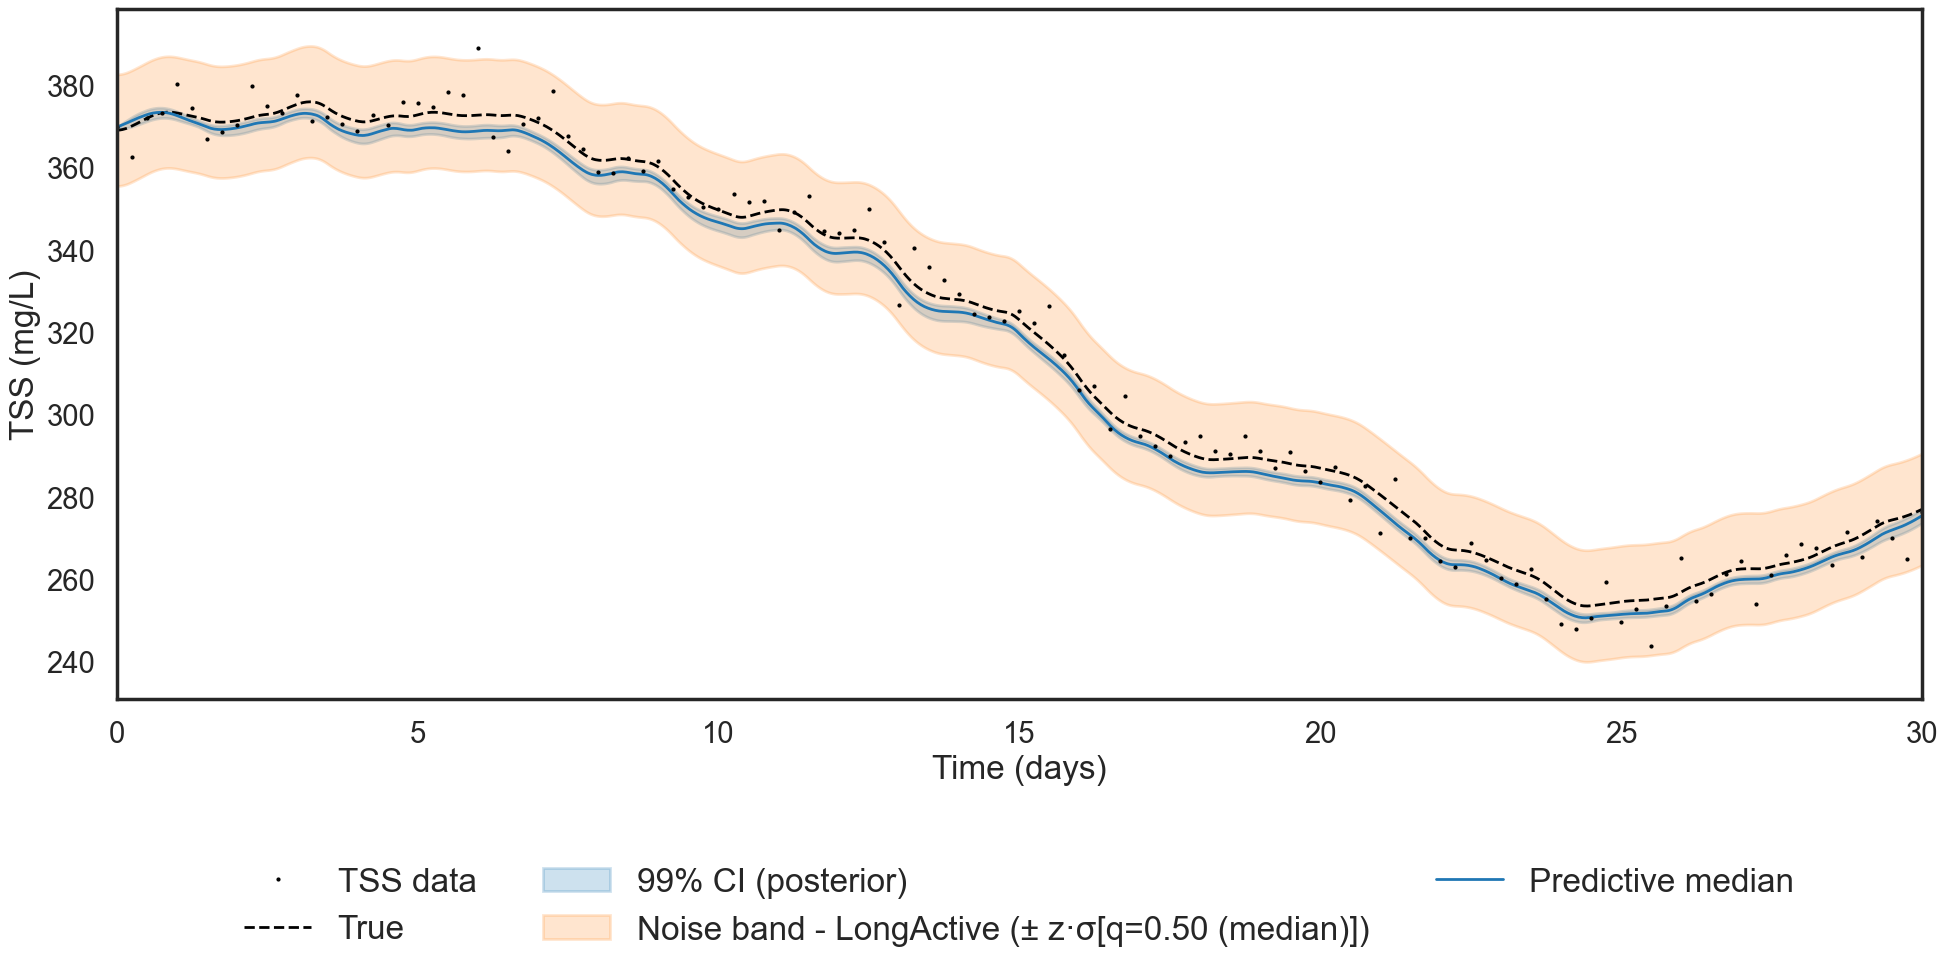

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ---------------------------------------------------
# Pick one case + scenario for predictive compounds
# ---------------------------------------------------

Case_to_run = "LongActive" # choose from: "HighRes", "Routine", "Active", "LongActive", "LongRoutine"
Method_to_run = "Sampling_Regular" # choose from: "Sampling_AllFreeNonInformative", "Sampling_AllFreePriors", "Sampling_AllFreeTight", "Sampling_FixedNoIdentifiability", "Sampling_Regular"
# label = "Active | Regular"
label = f"{Case_to_run} | {Method_to_run}"

Compounds_to_run = None             # or e.g. ["COD","NH4+NH3","TSS"]
Num_samples_to_run = 100            # If None, use all saved rows in theta_samples.csv
Credible_mass_to_run = 0.99         # e.g., 0.95 or 0.99 -- for posterior band
noise_sigma_quantile_to_run = 0.5   # eg., 0.5 for median(σ) noise band
t_eval_to_run = None                # # None -> use data time grid; or pass np.linspace(...)
# t_eval_to_run = np.linspace(0, 365, 2000)

# Set t_eval to max of case data time with 2000 points
if t_eval_to_run is None:
    eff_comp_path = _compounds_csv_path(Case_to_run)
    eff_comp_df = pd.read_csv(eff_comp_path)
    t_max = eff_comp_df["Time"].max()
    t_eval_to_run = np.linspace(0.0, t_max, 1000)

overwrite_existing = False  # set True to force recompute of predictions if they exist for this case+method

# Specifications for Case above:
spec = PredictiveSpec(
    case=Case_to_run,
    method=Method_to_run,
    label=label,
    ci_level=Credible_mass_to_run,
    num_samples=Num_samples_to_run,
    t_eval=t_eval_to_run
)
# Compute & save if overwriting (JSON + CSV), otherwise just load existing
# _ = simulate_predictive(spec, overwrite=overwrite_existing, n_jobs=10, solver_method="LSODA", rtol=1e-6, atol=1e-8, max_step=0.5)
_ = simulate_predictive(spec, overwrite=overwrite_existing, n_jobs=10, solver_method="LSODA", rtol=1e-3, atol=1e-6, max_step=np.inf) # Default vals in solve_ivp (except LSODA)

# ---------------------------------------------------
## Plotting
# ---------------------------------------------------

# Plot compounds with different band options:
    # Show posterior band and noise band (median noise)
plot_predictive_compounds(spec, None, center="median", 
                          show_posterior_band=True, show_noise_band=True, noise_sigma_quantile=noise_sigma_quantile_to_run, 
                          markersize=4.0, fontsize=24, mean_lw=2.0, true_lw=2.0, fig_size=(20,10))



In [ ]:
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # ----------------------------------------------------------
# # Compare two scenarios on the same plot for predictive compounds
# # ----------------------------------------------------------

# Case_A = "HighRes"                  # "HighRes", "Routine", "Active", "LongActive", "LongRoutine"
# Case_B = "HighRes"
# Method_A = "Sampling_Regular"      # "Sampling_AllFreeNonInformative", "Sampling_AllFreePriors", "Sampling_AllFreeTight", "Sampling_FixedNoIdentifiability", "Sampling_Regular"
# Method_B = "Sampling_AllFreeTight"
# label_a = f"{Case_A} | {Method_A}"
# label_b = f"{Case_B} | {Method_B}"
# ci_level = 0.99
# num_samples = 500

# # Define the two specs you want to compare
# spec_a = PredictiveSpec(
#     case=Case_A,
#     method=Method_A,
#     label=label_a,
#     ci_level=ci_level,
#     num_samples=num_samples,
#     t_eval=None,
# )

# spec_b = PredictiveSpec(
#     case=Case_B,
#     method=Method_B,
#     label=label_b,
#     ci_level=ci_level,
#     num_samples=num_samples,
#     t_eval=None,
# )

# #  Ensure all data is computed before plotting comparisons using the cell on top. ALternatively, compute them here 
# # _ = simulate_predictive(spec_a, overwrite=overwrite_existing, n_jobs=10, solver_method="LSODA", rtol=1e-6, atol=1e-8, max_step=np.inf)
# # _ = simulate_predictive(spec_b, overwrite=overwrite_existing, n_jobs=10, solver_method="LSODA", rtol=1e-6, atol=1e-8, max_step=np.inf)

# # Choose compounds or leave None for all
# compounds_to_compare = None # [COD, "NH4+NH3", "NO3+NO2", "TKN", "Alkalinity", "TSS"]

# # Plot comparisons

# # Only posterior bands
# plot_predictive_compounds_compare(
#     spec_a, spec_b,
#     compounds=None,
#     n_grid=2000,
#     overwrite_predictive=False,
#     show_posterior_band=True,
#     show_noise_band=False,
#     compute_kwargs={"n_jobs": 10, "solver_method": "LSODA", "rtol": 1e-6, "atol": 1e-8, "max_step": 0.5},
#     parallelize_scenarios=False,
#     fontsize=24,
#     fig_size=(22,10)
# )


In [ ]:
# ===========================
# 6.2 Multi-case KDE grids
# ===========================


# Cases and scenario mapping
SCENARIO_MAP = {
    "tight": "Sampling_AllFreeTight",
    "regular": "Sampling_Regular",
    "allfree_priors": "Sampling_AllFreePriors",
    "allfree_noninformative": "Sampling_AllFreeNonInformative",
    "fixed_no_ident": "Sampling_FixedNoIdentifiability",
}

# Case order & colors

# Output
KDE_OUT_DIR = RESULTS_DIR / "Figures" / "T62_KDEs"
KDE_OUT_DIR.mkdir(parents=True, exist_ok=True)


def _scenario_method_from_key(key: str) -> str:
    if key not in SCENARIO_MAP:
        raise KeyError(f"Unknown scenario key '{key}'. Valid keys: {list(SCENARIO_MAP)}")
    return SCENARIO_MAP[key]

def _get_param_samples(case: str, method: str, param: str, cases_registry: dict) -> Optional[pd.Series]:
    """
    Return posterior samples for (case, method, param) if available.
    If the param is fixed/special (i.e., not sampled), returns a constant Series
    so it still renders as a spike KDE (or a vertical annotation).
    Returns None if neither samples nor meta value can be found.
    """
    try:
        theta_df, meta = load_theta_samples_and_meta(case, method)
        roles = get_roles_for(case, method, cases_registry)
    except Exception as e:
        print(f"[skip] {case} | {method}: {e}")
        return None

    # Sampled?
    if param in theta_df.columns:
        s = _positive_series(theta_df[param], name=f"{case}:{param}")
        if s is not None and s.size > 0:
            return s

    # Not sampled -> check fixed/special meta
    if param in roles.get("fixed", set()):
        v = meta.get("fixed", {}).get(param, np.nan)
        if pd.notna(v):
            return pd.Series([max(0.0, float(v))] * 50, name=param)  # spike
    if param in roles.get("special", set()):
        v = meta.get("special", {}).get(param, 1e-6)
        return pd.Series([max(0.0, float(v))] * 50, name=param)

    # Nothing available
    return None

def _pooled_samples(samples_list: list[pd.Series]) -> Optional[pd.Series]:
    """Concatenate a list of Series (dropping Nones); return None if empty."""
    vals = [s.dropna().astype(float) for s in samples_list if s is not None and s.size > 0]
    if not vals:
        return None
    return pd.concat(vals, ignore_index=True)

def _xlim_around(
    s: Optional[pd.Series],
    *,
    include: Optional[Iterable[float]] = None,
    quantiles: tuple[float, float] = (0.005, 0.995),
    pad_frac: float = 0.10,
    min_span: float = 1e-6,
    cap_min_zero: bool = True
) -> tuple[float, float]:
    """
    Compute tight x-limits around KDE samples and ensure all `include` values (e.g., true)
    are explicitly inside the final limits. Always enforce non-negativity if requested.
    """
    # --- clean sample data (KDE support) ---
    if s is None or s.size == 0:
        xs = np.array([], dtype=float)
    else:
        xs = s.dropna().astype(float).to_numpy()
    xs = xs[np.isfinite(xs)]
    xs = xs[xs >= 0.0]  # enforce non-negativity on samples

    # --- clean include values (e.g., true, fixed spikes) ---
    inc = None
    if include is not None:
        inc = np.array([v for v in include if np.isfinite(v)], dtype=float)
        if inc.size > 0:
            inc = inc[inc >= 0.0]  # enforce non-negativity on include, too
        else:
            inc = None

    # If no data at all, fall back to include or [0, 1]
    if xs.size == 0 and (inc is None or inc.size == 0):
        return (0.0, 1.0)

    # --- base window from KDE samples (quantiles) or include if no samples ---
    if xs.size >= 2:
        lo_q, hi_q = np.quantile(xs, [quantiles[0], quantiles[1]])
    elif xs.size == 1:
        lo_q = hi_q = float(xs[0])
    else:
        # No samples -> base from include
        vmin = float(np.min(inc))
        vmax = float(np.max(inc))
        lo_q, hi_q = vmin, vmax

    span = max(hi_q - lo_q, min_span)
    pad = pad_frac * span
    xmin = lo_q - pad
    xmax = hi_q + pad

    # --- explicitly force-include all `inc` values by expanding the window ---
    if inc is not None and inc.size > 0:
        inc_min = float(np.min(inc))
        inc_max = float(np.max(inc))
        xmin = min(xmin, inc_min)
        xmax = max(xmax, inc_max)
        # Re-pad after expansion to keep a little breathing room
        span = max(xmax - xmin, min_span)
        pad = pad_frac * span
        xmin -= pad
        xmax += pad

    # --- spike / degenerate protection ---
    if xmax <= xmin + 1e-15:
        v = float((lo_q + hi_q) / 2.0)
        half = max(min_span, pad_frac * max(1.0, v)) * 0.5
        xmin, xmax = v - half, v + half

    # --- non-negativity clamp ---
    if cap_min_zero:
        xmin = max(0.0, xmin)

    # --- final guard ---
    if not np.isfinite(xmin) or not np.isfinite(xmax) or xmax <= xmin:
        # fallback around median of whatever we have (samples first, else include)
        base = xs if xs.size > 0 else inc
        v = float(np.nanmedian(base))
        xmin, xmax = max(0.0, v - 0.5), v + 0.5

    return (float(xmin), float(xmax))



def _darken(color_hex: str, factor: float = 0.65) -> str:
    """Return a darker shade of the given hex color (0<factor<1)."""
    r, g, b = mcolors.to_rgb(color_hex)
    return mcolors.to_hex((r*factor, g*factor, b*factor))


def plot_param_kde_grid(
    params: list[str],
    scenario_key: str,
    cases_registry: dict,
    cases_order: list[str] = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"],
    figsize_per_param: tuple[float, float] = (18, 9.5),
    font_size : int = 16,
    save_png: bool = True,
):
    """
    For each parameter in `params`, draw a 2x3 grid:
      [HighRes | Active | LongActive]
      [Routine | LongRoutine | All cases overlaid (not pooled)]
    KDEs are clipped at x>=0. Fixed/special appear as spikes. Means are solid darker lines.
    CI bounds are dash-dot. True value is a solid black line.
    """
    method = _scenario_method_from_key(scenario_key)

    for param in params:
        # Collect per-case series
        series_by_case = []
        for case in cases_order:
            s = _get_param_samples(case, method, param, cases_registry)
            series_by_case.append((case, s))

        # Build 2x3 grid
        fig, axes = plt.subplots(2, 3, figsize=figsize_per_param, constrained_layout=False)
        ax_list = list(itertools.chain.from_iterable(axes))

        # panel mapping
        panels = [
            ("HighRes", 0),
            ("Active", 1),
            ("LongActive", 2),
            ("Routine", 3),
            ("LongRoutine", 4),
        ]
        title_param = theta_format_names.get(param, param)
        true_val = TRUE_THETA.get(param, None)

        # --- Individual panels
        for case_name, ax_idx in panels:
            ax = ax_list[ax_idx]
            ax.grid(False)
            base_col = CASE_COLORS.get(case_name, "C0")
            # mean_col = _darken(base_col, 0.55)
            mean_col = base_col


            # Find the series for this case
            s = next((ss for cc, ss in series_by_case if cc == case_name), None)
            if s is None or s.size == 0:
                ax.text(0.5, 0.5, "No samples", ha="center", va="center", fontsize=font_size)
                ax.set_title(f"{case_name}", fontsize=font_size)
                ax.set_xlim(*_xlim_around(pd.Series([0.0]), include=[true_val] if (true_val is not None) else None))
                ax.set_ylim(bottom=0)
            else:
                s_clean = _positive_series(s, name=f"{case_name}:{param}")
                if s_clean.size > 0 and float(np.nanmax(s_clean)) - float(np.nanmin(s_clean)) == 0.0:
                    v = float(s_clean.iloc[0])
                    ax.axvline(v, color=base_col, linewidth=3, label="fixed/special", linestyle="--")
                    ax.plot([v], [0], "|", markersize=18, color=base_col)
                else:
                    # KDE
                    sns.kdeplot(s_clean, fill=True, linewidth=2, ax=ax, color=base_col, clip=(0, None), alpha=0.55)
                    # mean & 95% bounds (mean solid; CI dash-dot)
                    m, lo, hi = _hdi_nonneg(s_clean)
                    ax.axvline(m,  color=mean_col, linestyle="--",  linewidth=2.8, label="mean")
                    ax.axvline(lo, color=base_col, linestyle="-.", linewidth=2.3, label="95% HDI")
                    ax.axvline(hi, color=base_col, linestyle="-.", linewidth=2.3)

                # true value (if available)
                if true_val is not None:
                    ax.axvline(true_val, color="black", linestyle="-", linewidth=2.4, label="true")

                ax.set_title(f"{case_name}", fontsize=font_size)
                # ax.set_xlabel(f"{title_param}", fontsize=font_size, labelpad=2)
                # Change xlabel to show mean value
                if s_clean.size > 0:
                    m = float(np.mean(s_clean))
                ax.set_xlabel(f"{title_param} (mean: {m:.2g})", fontsize=font_size, labelpad=2)
                ax.set_ylabel("Density", fontsize=font_size, labelpad=2.0)
                ax.yaxis.set_label_coords(-0.20, 0.5)
                ax.tick_params(axis="both", labelsize=int(font_size*0.9))
                ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
                ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
                ax.set_xlim(*_xlim_around(
                    s if s is not None else pd.Series([0.0]),
                    include=[true_val] if (true_val is not None) else None
                ))
                ax.set_ylim(bottom=0)

        # --- Overlay panel (all cases overlaid)
        ax_overlay = ax_list[5]
        ax_overlay.grid(False)
        xmaxs, xmins = [], []

        drew_any = False
        for case_name, s in series_by_case:
            if s is None or s.size == 0:
                continue
            base_col = CASE_COLORS.get(case_name, "C0")
            # mean_col = _darken(base_col, 0.55)
            mean_col = base_col
            s_clean = _positive_series(s, name=f"{case_name}:{param}")

            if s_clean.size > 0 and float(np.nanmax(s_clean)) - float(np.nanmin(s_clean)) == 0.0:
                v = float(s_clean.iloc[0])
                ax_overlay.axvline(v, color=base_col, linewidth=3, label=f"{case_name} (fixed/special)", linestyle="--")
                ax_overlay.plot([v], [0], "|", markersize=18, color=base_col)
                xmins.append(v); xmaxs.append(v)
                drew_any = True
            else:
                sns.kdeplot(s_clean, fill=True, linewidth=2, ax=ax_overlay, color=base_col, clip=(0, None), alpha=0.35, label=f"{case_name} KDE")
                m, lo, hi = _hdi_nonneg(s_clean)
                ax_overlay.axvline(m, color=mean_col, linestyle="--", linewidth=2.4, label=f"{case_name} mean")
                xmins.append(lo); xmaxs.append(hi)
                drew_any = True

        # true value
        if true_val is not None:
            ax_overlay.axvline(true_val, color="black", linestyle="-", linewidth=2.4, label="True")

        ax_overlay.set_title("All cases (overlay)", fontsize=font_size)
        # ax_overlay.set_xlabel(f"{title_param}", fontsize=font_size, labelpad=2)
        # change xlabel to show true value for overlay
        if true_val is not None:
            ax_overlay.set_xlabel(f"{title_param} (true: {true_val:.2g})", fontsize=font_size, labelpad=2)
        ax_overlay.set_ylabel("Density", fontsize=font_size, labelpad=2.0)
        ax_overlay.yaxis.set_label_coords(-0.20, 0.5)
        ax_overlay.tick_params(axis="both", labelsize=int(font_size*0.9))
        ax_overlay.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        ax_overlay.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

        # overlay limits from collected spans (fallback safe window)
        if drew_any and len(xmins) > 0 and len(xmaxs) > 0:
            all_lo = list(xmins)
            all_hi = list(xmaxs)
            if true_val is not None and np.isfinite(true_val):
                all_lo.append(true_val)
                all_hi.append(true_val)

            lo = min(all_lo) if all_lo else 0.0
            hi = max(all_hi) if all_hi else 1.0
            lo = max(0.0, lo)  # non-negative

            span = max(hi - lo, 1e-6)
            pad = 0.10 * span
            ax_overlay.set_xlim(max(0.0, lo - pad), hi + pad)
        else:
            ax_overlay.set_xlim(0.0, 1.0)
        ax_overlay.set_ylim(bottom=0)

        # dedup legend entries and place nicely
        handles, labels = ax_overlay.get_legend_handles_labels()
        seen, H, L = set(), [], []
        for h, l in zip(handles, labels):
            if l not in seen:
                seen.add(l); H.append(h); L.append(l)
        # Add one label for HDI lines (with .- line style)
        L.append("95% HDI (various)")
        H.append(plt.Line2D([0], [0], color="red", linestyle  ="-.", linewidth=2.3))

        fig.legend(H, L,
           loc="lower center",
           bbox_to_anchor=(0.5, -0.12),
           ncol=min(4, len(L)),
           frameon=False,
           fontsize=int(font_size*0.9))

        # Super title (lifted higher) + top padding to avoid overlap
        # fig.suptitle(f"{title_param} — {scenario_key} ({method})", fontsize=font_size+1, y=1.06)
        fig.subplots_adjust(top=0.80, hspace=0.45, wspace=0.3)

        if save_png:
            out_path = KDE_OUT_DIR / f"{scenario_key}_{param}.png"
            fig.savefig(out_path, dpi=300, bbox_inches="tight")
            print(f"[saved] {out_path}")

        plt.show()

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# =====================================
# KDE grid plotting 6.2 (run)
# =====================================

CASES_ORDER = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"]
SCENARIO_KEY = "regular"   # "tight", "regular", "allfree_priors", "allfree_noninformative", "fixed_no_ident"
PARAMS_TO_PLOT = [
    "eta_NOX",
]
# All parameters
# PARAMS_TO_PLOT = list(theta_format_names.keys())

plot_param_kde_grid(
    params=PARAMS_TO_PLOT,
    scenario_key=SCENARIO_KEY,
    cases_registry=cases,
    cases_order=CASES_ORDER,
    figsize_per_param=(20, 12),
    font_size=24,
    save_png=True,
)


In [ ]:
# ===========================
# Posterior mean % diff vs True (by case)
# ===========================

def _scenario_method_from_key(key: str) -> str:
    if key not in SCENARIO_MAP:
        raise KeyError(f"Unknown scenario key '{key}'. Valid keys: {list(SCENARIO_MAP)}")
    return SCENARIO_MAP[key]

def _posterior_mean_for(case: str, method: str, param: str) -> float | np.nan:
    """
    Posterior mean for (case, method, param).
    Falls back to fixed/special meta if samples missing.
    Returns np.nan if nothing available.
    """
    try:
        theta_df, meta = load_theta_samples_and_meta(case, method)
    except Exception:
        return np.nan

    if param in theta_df.columns:
        s = _positive_series(theta_df[param], name=f"{case}:{param}")
        return float(s.mean()) if s.size > 0 else np.nan

    # fallbacks: fixed/special meta (saved in previous steps)
    v = meta.get("fixed", {}).get(param, None)
    if v is None:
        v = meta.get("special", {}).get(param, None)
    return float(v) if v is not None else np.nan
def _safe_pct_diff(
    est: float | np.nan,
    truth: float | None,
    *,
    mode: str = "truth",
    tiny: float = 1e-12,
) -> float | np.nan:
    """
    Absolute percent difference with configurable denominator.
      mode='truth'   → 100 * |est - truth| / |truth|
      mode='max_abs' → 100 * |est - truth| / max(|truth|, |est|)
    Returns NaN if the chosen denominator is ill-defined.
    """
    if truth is None or not np.isfinite(est) or not np.isfinite(truth):
        return np.nan

    diff = abs(est - truth)
    mode_lc = mode.lower()
    if mode_lc == "truth":
        denom = abs(truth)
    elif mode_lc == "max_abs":
        denom = max(abs(truth), abs(est))
    else:
        raise ValueError("diff_mode must be 'truth', 'max_abs', or 'relative'.")

    if denom < tiny:
        return np.nan
    return 100.0 * diff / denom


def compute_pctdiff_table(
    scenario_key: str,
    cases_order: list[str],
    params: list[str] | None = None,
    *,
    diff_mode: str = "truth",
    tiny: float = 1e-12,
) -> pd.DataFrame:
    """
    Returns a tidy DataFrame with:
      ['param', 'case', 'mean', 'true', 'pct_diff']
    for the chosen scenario/cases/params (or all params if None).

    diff_mode:
      'truth'   → classic % diff.
      'max_abs' → denominator = max(|truth|, |estimate|).
      'relative' → normalized so the largest |estimate - truth| becomes 100%.
    """
    method = _scenario_method_from_key(scenario_key)
    use_params = params if params is not None else list(TRUE_THETA.keys())
    mode_lc = diff_mode.lower()

    rows = []
    for p in use_params:
        t = TRUE_THETA.get(p, None)
        for case in cases_order:
            m = _posterior_mean_for(case, method, p)
            rows.append({
                "param": p,
                "case": case,
                "mean": m,
                "true": t,
                "abs_diff": float(abs(m - t)) if (np.isfinite(m) and t is not None and np.isfinite(t)) else np.nan,
            })

    df = pd.DataFrame(rows)
    df["param"] = pd.Categorical(df["param"], categories=use_params, ordered=True)
    df["case"] = pd.Categorical(df["case"], categories=cases_order, ordered=True)
    df = df.sort_values(["param", "case"]).reset_index(drop=True)

    if mode_lc == "relative":
        finite_abs = df["abs_diff"].to_numpy(dtype=float)
        max_diff = np.nanmax(finite_abs) if np.any(np.isfinite(finite_abs)) else np.nan
        if not np.isfinite(max_diff) or max_diff < tiny:
            df["pct_diff"] = np.where(np.isfinite(df["abs_diff"]), 0.0, np.nan)
        else:
            df["pct_diff"] = 100.0 * df["abs_diff"] / max_diff
    elif mode_lc in ("truth", "max_abs"):
        df["pct_diff"] = [
            _safe_pct_diff(m, t, mode=mode_lc, tiny=tiny)
            for m, t in zip(df["mean"], df["true"], strict=False)
        ]
    else:
        raise ValueError("diff_mode must be 'truth', 'max_abs', or 'relative'.")

    return df.drop(columns="abs_diff")

def plot_pctdiff_bars(
    scenario_key: str,
    cases_order: list[str],
    params: list[str] | None = None,
    *,
    per_fig: int = 12,        # number of parameters per figure "page"
    ncols: int = 4,
    figsize: tuple[float, float] = (20, 12),
    font_size: int = 18,
    diff_mode: str = "truth",
    save_png: bool = True,
):
    """
    Plot small-multiple bar charts:
      - One subplot per parameter.
      - Bars = cases, colored by CASE_COLORS.
      - Value = % diff of posterior mean vs true.
      - Zero-reference line shown.

    If `params=None`, includes all parameters and paginates across multiple figures.
    """
    method = _scenario_method_from_key(scenario_key)
    df = compute_pctdiff_table(scenario_key, cases_order, params=params, diff_mode=diff_mode)

    # Group params into pages
    all_params = list(df["param"].cat.categories)
    if not all_params:
        print("[warn] No parameters to plot.")
        return

    ncols = max(1, int(ncols))
    n_per_page = max(1, int(per_fig))
    pages = [all_params[i:i+n_per_page] for i in range(0, len(all_params), n_per_page)]

    out_dir = RESULTS_DIR / "Figures" / f"T62_PctDiff_{scenario_key}"
    if save_png:
        out_dir.mkdir(parents=True, exist_ok=True)

    for page_i, plist in enumerate(pages, start=1):
        n = len(plist)
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=False)
        axes = np.array(axes).reshape(nrows, ncols)

        for idx, p in enumerate(plist):
            r, c = divmod(idx, ncols)
            ax = axes[r, c]

            dsub = df[df["param"] == p]
            # Draw bars per case
            xs = np.arange(len(cases_order))
            vals = dsub.set_index("case").loc[cases_order, "pct_diff"].to_numpy()

            bar_colors = [CASE_COLORS.get(ca, "C0") for ca in cases_order]
            ax.bar(xs, vals, color=bar_colors, alpha=0.9, width=0.75)

            # Zero reference
            ax.axhline(0.0, color="black", linewidth=1.2, linestyle="-")

            # Labels & ticks
            disp = theta_format_names.get(p, p)
            ax.set_title(disp, fontsize=font_size)
            ax.set_xticks(xs)
            ax.set_xticklabels(cases_order, rotation=25, ha="right", fontsize=int(font_size*0.85))
            ax.tick_params(axis="y", labelsize=int(font_size*0.85))
            ax.set_ylabel("% diff", fontsize=int(font_size*0.9))

            # Auto symmetric y-lims around the largest |diff| for readability
            finite_vals = np.asarray([v for v in vals if np.isfinite(v)])
            if finite_vals.size > 0:
                m = float(np.nanmax(finite_vals))
                pad = 0.08 * (m if m > 0 else 1.0)
                ax.set_ylim(0.0, m + pad)
            else:
                ax.set_ylim(0.0, 1.0)
                
            ax.grid(False)

        # Hide unused subplots
        for j in range(n, nrows*ncols):
            r, c = divmod(j, ncols)
            axes[r, c].axis("off")

        # Figure-wide legend (cases)
        patches = [Patch(facecolor=CASE_COLORS.get(ca, "C0"), label=ca) for ca in cases_order]
        fig.legend(patches, [ca for ca in cases_order],
                   loc="lower center", bbox_to_anchor=(0.5, -0.02),
                   ncol=min(len(cases_order), 5), frameon=False, fontsize=int(font_size*0.9))

        # Title & spacing
        fig.suptitle(f"Posterior mean % diff vs True — {scenario_key} ({method})", fontsize=font_size+2, y=0.99)
        fig.subplots_adjust(top=0.90, hspace=0.40, wspace=0.25, bottom=0.12)

        if save_png:
            fname = out_dir / f"T62_PctDiff_{scenario_key}_page{page_i:02d}.png"
            fig.savefig(fname, dpi=300, bbox_inches="tight")
            print(f"[saved] {fname}")

        plt.show()


In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ===========================
# Run %diff bar plots
# ===========================

DIFF_SCENARIO_KEY = "tight"   # "tight", "regular", "allfree_priors", "allfree_noninformative", "fixed_no_ident"
DIFF_CASES_ORDER  = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"]

# Choose a subset (recommended for slides) or None for all parameters
DIFF_PARAMS = [
    "k_H", "mu_H", "K_S", "K_O2", "eta_NOX"
]
# DIFF_PARAMS = None  # <- uncomment to do all parameters

plot_pctdiff_bars(
    scenario_key=DIFF_SCENARIO_KEY,
    cases_order=DIFF_CASES_ORDER,
    params=DIFF_PARAMS,       # or None for all
    per_fig=12,                # params per page when params=None
    ncols=3,                   # columns of subplots
    figsize=(22, 12),
    font_size=18,
    save_png=True,
)


In [ ]:
def plot_pctdiff_single_case(
    scenario_key: str,
    case: str,
    params: Optional[Sequence[str]] = None,
    *,
    figsize: tuple[float, float] = (14, 7),
    font_size: int = 18,
    bar_colors: Optional[Sequence[str]] = None,
    label_precision: int = 1,
    order_mode: str = "input",  # "input" or "diff_desc"
    diff_cutoff: float = 0.0,
    diff_mode: str = "truth",
    save_path: Optional[Path] = None,
):
    """Plot % diff of posterior mean vs true for a single case and scenario."""
    if case not in cases:
        raise KeyError(f"Unknown case '{case}'. Available cases: {list(cases)}")

    if params is not None and not params:
        raise ValueError("Provide at least one parameter name to plot.")

    if diff_cutoff < 0.0:
        raise ValueError("diff_cutoff must be non-negative.")

    method = _scenario_method_from_key(scenario_key)
    # df = compute_pctdiff_table(scenario_key, [case], params=params if params is not None else None)
    df = compute_pctdiff_table(
        scenario_key,
        [case],
        params=params if params is not None else None,
        diff_mode=diff_mode,
    )
    df_case = df[df["case"] == case].copy()

    if diff_cutoff > 0.0:
        df_case = df_case[np.abs(df_case["pct_diff"]) >= diff_cutoff]

    if df_case.empty:
        raise ValueError(
            f"No data to plot after applying filters for case '{case}' "
            f"and provided parameters {params}."
        )

    order_mode_lc = order_mode.lower()
    if order_mode_lc == "diff_desc":
        df_case = df_case.sort_values(
            by="pct_diff", key=lambda s: np.abs(s), ascending=False, ignore_index=True
        )
    elif order_mode_lc != "input":
        raise ValueError("order_mode must be either 'input' or 'diff_desc'.")

    df_case["display"] = [theta_format_names.get(p, p) for p in df_case["param"]]
    diffs = df_case["pct_diff"].to_numpy(dtype=float)
    plot_vals = np.nan_to_num(diffs, nan=0.0)

    if bar_colors is None:
        colors = sns.color_palette("husl", len(plot_vals))
    else:
        if len(bar_colors) < len(plot_vals):
            raise ValueError("Not enough colors provided for the number of parameters.")
        colors = list(bar_colors)

    fig, ax = plt.subplots(figsize=figsize)
    indices = np.arange(len(plot_vals))
    bars = ax.bar(indices, plot_vals, color=colors[: len(plot_vals)], width=0.65)

    for bar, diff in zip(bars, diffs):
        label = f"{diff:.{label_precision}f}%" if np.isfinite(diff) else "NA"
        height = bar.get_height()
        ax.annotate(
            label,
            xy=(bar.get_x() + bar.get_width() / 2.0, height),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=int(font_size * 0.8),
        )

    ax.axhline(0.0, color="black", linewidth=1.2)
    ax.set_xticks(indices)
    ax.set_xticklabels(df_case["display"], rotation=25, ha="right", fontsize=int(font_size * 0.9))
    ax.set_ylabel("% diff", fontsize=font_size)
    ax.set_title(f"{case} ? {scenario_key} ({method})", fontsize=font_size + 2)
    ax.tick_params(axis="y", labelsize=int(font_size * 0.9))
    ax.grid(False)

    finite = diffs[np.isfinite(diffs)]
    if finite.size > 0:
        ymax = float(finite.max())
        pad = max(1.0, 0.1 * ymax)
        ax.set_ylim(0.0, ymax + pad)
    else:
        ax.set_ylim(0.0, 1.0)

    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[saved] {save_path}")

    plt.show()



In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ===========================
# Run single-case % diff bar plot
# ===========================
SINGLE_DIFF_SCENARIO_KEY = "tight"   # "tight", "regular", "allfree_priors", "allfree_noninformative", "fixed_no_ident"
SINGLE_DIFF_CASE = "HighRes"         # "HighRes", "Active", "LongActive", "Routine", "LongRoutine"
SINGLE_DIFF_PARAMS = [
    "k_H", "mu_H", "K_S", "K_O2", "eta_NOX"
]

# Shared display options
ORDER_MODE = "diff_desc"   # "input" or "diff_desc"
DIFF_CUTOFF = 0.0          # e.g. 0.1 to hide bars below 0.1%
DIFF_MODE = "max_abs"    # "truth" or "max_abs" or "relative"

# All parameters with cutoff
plot_pctdiff_single_case(
    scenario_key=SINGLE_DIFF_SCENARIO_KEY,
    case=SINGLE_DIFF_CASE,
    params=None,
    figsize=(16, 8),
    font_size=20,
    bar_colors=None,
    label_precision=2,
    order_mode=ORDER_MODE,
    diff_cutoff=1.0,
    diff_mode=DIFF_MODE,
    save_path=RESULTS_DIR / "Figures" / f"T62_PctDiff_{SINGLE_DIFF_CASE}_{SINGLE_DIFF_SCENARIO_KEY}.png"
)

# # First 6 parameters
# GROUP1_PARAMS = list(TRUE_THETA.keys())[:6]
# # SINGLE_DIFF_PARAMS = None
# plot_pctdiff_single_case(
#     scenario_key=SINGLE_DIFF_SCENARIO_KEY,
#     case=SINGLE_DIFF_CASE,
#     params=GROUP1_PARAMS,
#     figsize=(16, 8),
#     font_size=20,
#     bar_colors=None,
#     label_precision=3,
#     order_mode=ORDER_MODE,
#     diff_cutoff=DIFF_CUTOFF,
#     diff_mode=DIFF_MODE,
#     save_path=RESULTS_DIR / "Figures" / f"T62_PctDiff_{SINGLE_DIFF_CASE}_{SINGLE_DIFF_SCENARIO_KEY}_group1.png"
# )

# # Next 6 parameters
# GROUP2_PARAMS = list(TRUE_THETA.keys())[6:12]
# plot_pctdiff_single_case(
#     scenario_key=SINGLE_DIFF_SCENARIO_KEY,
#     case=SINGLE_DIFF_CASE,
#     params=GROUP2_PARAMS,
#     figsize=(16, 8),
#     font_size=20,
#     bar_colors=None,
#     label_precision=3,
#     order_mode=ORDER_MODE,
#     diff_cutoff=DIFF_CUTOFF,
#     diff_mode=DIFF_MODE,
#     save_path=RESULTS_DIR / "Figures" / f"T62_PctDiff_{SINGLE_DIFF_CASE}_{SINGLE_DIFF_SCENARIO_KEY}_group2.png"
# )

# # Next 6 parameters
# GROUP3_PARAMS = list(TRUE_THETA.keys())[12:18]
# plot_pctdiff_single_case(
#     scenario_key=SINGLE_DIFF_SCENARIO_KEY,
#     case=SINGLE_DIFF_CASE,
#     params=GROUP3_PARAMS,
#     figsize=(16, 8),
#     font_size=20,
#     bar_colors=None,
#     label_precision=3,
#     order_mode=ORDER_MODE,
#     diff_cutoff=DIFF_CUTOFF,
#     diff_mode=DIFF_MODE,
#     save_path=RESULTS_DIR / "Figures" / f"T62_PctDiff_{SINGLE_DIFF_CASE}_{SINGLE_DIFF_SCENARIO_KEY}_group3.png"
# )

# # Next 6 parameters
# GROUP4_PARAMS = list(TRUE_THETA.keys())[18:24]
# plot_pctdiff_single_case(
#     scenario_key=SINGLE_DIFF_SCENARIO_KEY,
#     case=SINGLE_DIFF_CASE,
#     params=GROUP4_PARAMS,
#     figsize=(16, 8),
#     font_size=20,
#     bar_colors=None,
#     label_precision=3,
#     order_mode=ORDER_MODE,
#     diff_cutoff=DIFF_CUTOFF,
#     diff_mode=DIFF_MODE,
#     save_path=RESULTS_DIR / "Figures" / f"T62_PctDiff_{SINGLE_DIFF_CASE}_{SINGLE_DIFF_SCENARIO_KEY}_group4.png"
# )

# # Next 6 parameters
# GROUP5_PARAMS = list(TRUE_THETA.keys())[24:30]
# plot_pctdiff_single_case(
#     scenario_key=SINGLE_DIFF_SCENARIO_KEY,
#     case=SINGLE_DIFF_CASE,
#     params=GROUP5_PARAMS,
#     figsize=(16, 8),
#     font_size=20,
#     bar_colors=None,
#     label_precision=3,
#     order_mode=ORDER_MODE,
#     diff_cutoff=DIFF_CUTOFF,
#     diff_mode=DIFF_MODE,
#     save_path=RESULTS_DIR / "Figures" / f"T62_PctDiff_{SINGLE_DIFF_CASE}_{SINGLE_DIFF_SCENARIO_KEY}_group5.png"
# )

# # Next 6 parameters
# GROUP6_PARAMS = list(TRUE_THETA.keys())[30:36]
# plot_pctdiff_single_case(
#     scenario_key=SINGLE_DIFF_SCENARIO_KEY,
#     case=SINGLE_DIFF_CASE,
#     params=GROUP6_PARAMS,
#     figsize=(16, 8),
#     font_size=20,
#     bar_colors=None,
#     label_precision=3,
#     order_mode=ORDER_MODE,
#     diff_cutoff=DIFF_CUTOFF,
#     diff_mode=DIFF_MODE,
#     save_path=RESULTS_DIR / "Figures" / f"T62_PctDiff_{SINGLE_DIFF_CASE}_{SINGLE_DIFF_SCENARIO_KEY}_group6.png"
# )


In [ ]:
# ===========================
# 6.2 Posterior predictive grids (by compound, tight scenario)
# ===========================

PRED_GRID_DIR = RESULTS_DIR / "Figures" / "T62_Predictive_Grids"
PRED_GRID_DIR.mkdir(parents=True, exist_ok=True)

def _sigma_pick(sig_df: pd.DataFrame, compound: str, q: float | str):
    """Return (sigma_value, label_suffix) for a compound from sigma samples df."""
    if sig_df is None or sig_df.empty:
        return None, ""
    s_col = f"sigma_{'Alkalinity' if compound=='Alkalinity' else ('NOx' if compound=='NO3+NO2' else ('NH4' if compound=='NH4+NH3' else compound))}"
    if s_col not in sig_df.columns:
        return None, ""
    vals = sig_df[s_col].dropna().to_numpy()
    if vals.size == 0:
        return None, ""
    if isinstance(q, str) and q.lower() == "mean":
        return float(np.mean(vals)), "mean"
    qf = min(1.0, max(0.0, float(q)))
    tag = f"q={qf:.2f}" + (" (median)" if abs(qf - 0.5) < 1e-9 else "")
    return float(np.quantile(vals, qf)), tag

def plot_compound_predictive_grid(
    compounds: list[str] | None = None,
    scenario_key: str = "tight",
    cases_order: list[str] = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"],
    *,
    center_line: str = "median",   # "median" (default) or "mean"
    ci_level: float = 0.95,
    num_samples: int | None = 500,
    n_grid_overlay: int = 1500,
    show_posterior_band: bool = True,
    show_noise_band: bool = False,
    noise_sigma_quantile: float | str = 0.5,
    fig_size_per_compound: tuple[float,float] = (18, 9.5),
    font_size: int = 18,
    markersize: float = 6.0,
    point_alpha: float = 0.9,
    ci_alpha: float = 0.22,
    mean_lw: float = 2.6,
    mean_alpha: float = 1.0,
    true_lw: float = 2.4,
    true_alpha: float = 1.0,
    save_png: bool = True,
    overwrite_predictive: bool = False,
    compute_kwargs: dict | None = None,
    ylims: tuple[float,float] | None = None,
    # NEW: keyed by (compound, case), e.g. {("Alkalinity","HighRes"): (0,20)}
    ylims_per: dict[tuple[str, str], tuple[float,float]] | None = None,
    # --- overlay controls ---
    show_overlay: bool = True,
    overlay_show_data: bool = True,
    overlay_show_posterior_band: bool | None = None,  # None -> inherit show_posterior_band
    overlay_show_noise_band: bool | None = None,      # None -> inherit show_noise_band
    overlay_markersize: float | None = None,          # None -> use markersize
    overlay_point_alpha: float | None = None,         # None -> use point_alpha
):
    """
    For each compound, draw a 2×3 grid:
      [HighRes | Active | LongActive]
      [Routine | LongRoutine | Overlay (all cases)]

    ylims_per:
      dict keyed by (compound_name, case_name) -> (ymin, ymax), e.g.
      {("Alkalinity", "HighRes"): (0, 20)}
    """
    method = _scenario_method_from_key(scenario_key)
    _ckw = dict(n_jobs=1, solver_method="LSODA", rtol=1e-6, atol=1e-8, max_step=0.5)
    if compute_kwargs:
        _ckw.update(compute_kwargs)

    # Inherit overlay toggles if not specified
    if overlay_show_posterior_band is None:
        overlay_show_posterior_band = show_posterior_band
    if overlay_show_noise_band is None:
        overlay_show_noise_band = show_noise_band
    if overlay_markersize is None:
        overlay_markersize = markersize
    if overlay_point_alpha is None:
        overlay_point_alpha = point_alpha

    # Compute/load predictive summaries per case
    per_case = {}
    for case in cases_order:
        spec = PredictiveSpec(case=case, method=method, label=f"{case} | {method}",
                              ci_level=ci_level, num_samples=num_samples, t_eval=None)
        tidy, obj = simulate_predictive(spec, overwrite=overwrite_predictive, **_ckw)
        data_df   = pd.read_csv(_compounds_csv_path(case))
        want_sigma = show_noise_band or overlay_show_noise_band
        sig_df    = load_sigma_samples(case, method) if want_sigma else pd.DataFrame(columns=SIGMA_VARS)
        per_case[case] = dict(obj=obj, data=data_df, sig=sig_df)

    # Determine compound list
    keys_all = sorted(set.intersection(*[set(per_case[c]["obj"]["compounds"].keys()) for c in cases_order])) if cases_order else []
    comp_list = [k for k in (compounds if compounds is not None else keys_all) if k in keys_all]
    if not comp_list:
        print("[warn] No compounds to plot.")
        return

    # For optional true/noise bands on a dense grid for the overlay, precompute per case
    dense_t = {case: _build_shared_time_grid(case, case, n=n_grid_overlay) for case in cases_order}

    for k in comp_list:
        fig, axes = plt.subplots(2, 3, figsize=fig_size_per_compound, constrained_layout=False)
        ax_flat = list(itertools.chain.from_iterable(axes))

        panels = [
            ("HighRes", 0),
            ("Active", 1),
            ("LongActive", 2),
            ("Routine", 3),
            ("LongRoutine", 4),
        ]

        overlay_lines = []   # (case, tt, mean, lo, hi)
        overlay_data  = []   # (case, t_data, y_data)
        overlay_noise = []   # (case, tt_nb, nb_lo, nb_hi, s_tag)

        # Single legend labels across the whole figure for data/true
        data_label_given = False
        true_label_given = False

        for case, idx in panels:
            ax = ax_flat[idx]
            ax.grid(False)
            col = CASE_COLORS.get(case, "C0")

            blob = per_case[case]
            obj  = blob["obj"]
            df   = blob["data"]

            tt   = np.array(obj["time"], dtype=float)
            lo   = _nonneg(np.array(obj["compounds"][k]["lower"]))
            hi   = _nonneg(np.array(obj["compounds"][k]["upper"]))
            if center_line.lower() == "median" and "median" in obj["compounds"][k]:
                post_center = _nonneg(np.array(obj["compounds"][k]["median"]))
            else:
                post_center = _nonneg(np.array(obj["compounds"][k]["mean"]))

            # Posterior band (per-panel) - draw first (under everything)
            if show_posterior_band and lo is not None and hi is not None:
                ax.fill_between(
                    tt, lo, hi, color=col, alpha=ci_alpha, linewidth=0.6, edgecolor=col,
                    label=f"{int(ci_level*100)}% CI — {case}", zorder=1
                )

            # Noise band (centered on true if available; else mean) — per-case label
            y_true_tt = None
            try:
                true_on_grid = simulate_true_effluent_for_case(case, tt).get("compounds", pd.DataFrame())
                if not true_on_grid.empty:
                    y_true_tt = _nonneg(true_on_grid[k].to_numpy())
            except Exception as e:
                print(f"[note] True computation failed for {case}/{k}: {e}")

            if show_noise_band:
                s_val, s_tag = _sigma_pick(blob["sig"], k, noise_sigma_quantile)
                if s_val is not None:
                    z = norm.ppf(0.5 * (1.0 + ci_level))
                    center = y_true_tt if y_true_tt is not None else post_center
                    nb_lo = _nonneg(center - z * s_val)
                    nb_hi = _nonneg(center + z * s_val)
                    ax.fill_between(
                        tt, nb_lo, nb_hi, color=col, alpha=ci_alpha*0.55,
                        label=f"Noise band — {case} (σ[{noise_sigma_quantile:.2g}])",
                        linewidth=0.6, edgecolor=col, zorder=1.1
                    )

            # Data (per-panel)
            if k in df.columns:
                t_data = df["Time"].to_numpy()
                y_data = df[k].to_numpy()
                label_data = (f"{k} data" if not data_label_given else "_nolegend_")
                ax.plot(t_data, y_data, ".", color="black",
                        alpha=point_alpha, markersize=markersize, label=label_data, zorder=3.5)
                if not data_label_given:
                    data_label_given = True
                overlay_data.append((case, t_data, y_data))

            # Mean or Median line (per-panel)
            ax.plot(tt, post_center, color=col, lw=mean_lw, alpha=mean_alpha,
                    label=f"{case} {center_line}", zorder=2.5)

            # True line (per-panel)
            if y_true_tt is not None:
                label_true = ("True" if not true_label_given else "_nolegend_")
                ax.plot(tt, y_true_tt, "--", color="black", lw=true_lw, alpha=true_alpha,
                        label=label_true, zorder=2)
                if not true_label_given:
                    true_label_given = True

            # ===== y-limits: (compound, case)-specific first, then global, then auto =====
            applied_limits = None
            key_cc = (k, case)
            if ylims_per and key_cc in ylims_per:
                applied_limits = ylims_per[key_cc]
            elif ylims is not None:
                applied_limits = ylims

            if applied_limits is not None:
                ax.set_ylim(*applied_limits)
            else:
                y_cands = [post_center, lo, hi]
                if k in df.columns:
                    y_cands.append(df[k].to_numpy())
                if y_true_tt is not None:
                    y_cands.append(y_true_tt)
                stack = [np.asarray(v, float).ravel() for v in y_cands if v is not None]
                if stack:
                    all_y = np.concatenate(stack)
                    all_y = all_y[~np.isnan(all_y)]
                    if all_y.size > 0:
                        ymin, ymax = max(0.0, float(np.nanmin(all_y))), float(np.nanmax(all_y))
                        pad = 0.06 * (ymax - ymin if ymax > ymin else 1.0)
                        ax.set_ylim(ymin - pad if ymin > 0 else 0.0, ymax + pad)

            ax.set_title(f"{case}", fontsize=font_size)
            ax.set_xlabel("Time (days)", fontsize=font_size)
            ax.set_ylabel(f"{k} (mg/L)", fontsize=font_size)
            ax.tick_params(axis="both", labelsize=int(font_size*0.9))

            # Collect for overlay
            overlay_lines.append((case, tt, post_center, lo if show_posterior_band else None, hi if show_posterior_band else None))

            # Precompute overlay noise on a dense grid (center on true if possible)
            if overlay_show_noise_band:
                s_val_ov, s_tag_ov = _sigma_pick(blob["sig"], k, noise_sigma_quantile)
                if s_val_ov is not None:
                    tt_dense = dense_t[case]
                    try:
                        true_dense = simulate_true_effluent_for_case(case, tt_dense).get("compounds", pd.DataFrame())
                        if not true_dense.empty:
                            center_dense = _nonneg(true_dense[k].to_numpy())
                        else:
                            center_dense = np.interp(tt_dense, tt, post_center)
                            center_dense = _nonneg(center_dense)
                    except Exception:
                        center_dense = np.interp(tt_dense, tt, post_center)
                        center_dense = _nonneg(center_dense)

                    z = norm.ppf(0.5 * (1.0 + ci_level))
                    nb_lo_d = _nonneg(center_dense - z * s_val_ov)
                    nb_hi_d = _nonneg(center_dense + z * s_val_ov)
                    overlay_noise.append((case, tt_dense, nb_lo_d, nb_hi_d, s_tag_ov))

        # Overlay panel (unchanged in terms of ylims_per – we typically let it auto-scale or use global ylims if you want)
        ax_ov = ax_flat[5]
        ax_ov.grid(False)

        if show_overlay:
            for case, tt, post_center, lo, hi in overlay_lines:
                col = CASE_COLORS.get(case, "C0")
                ax_ov.plot(tt, post_center, color=col, lw=mean_lw, alpha=mean_alpha,
                           label=f"{case} {center_line}", zorder=2.5)
                if overlay_show_posterior_band and lo is not None and hi is not None:
                    ax_ov.fill_between(tt, lo, hi, color=col, alpha=ci_alpha*0.6,
                                       linewidth=0.4, edgecolor=col, label=f"{case} {int(ci_level*100)}% CI",
                                       zorder=1)

            if overlay_show_noise_band:
                for case, tt_nb, nb_lo, nb_hi, s_tag in overlay_noise:
                    col = CASE_COLORS.get(case, "C0")
                    ax_ov.fill_between(tt_nb, nb_lo, nb_hi, color=col, alpha=ci_alpha*0.55,
                                       label=f"Noise band — {case} (σ[{noise_sigma_quantile:.2g}])",
                                       linewidth=0.6, edgecolor=col, zorder=1.1)

            overlay_data_label_given = False
            if overlay_show_data:
                for case, t_data, y_data in overlay_data:
                    col = CASE_COLORS.get(case, "C0")
                    label = (f"{k} data" if not overlay_data_label_given else "_nolegend_")
                    ax_ov.plot(t_data, y_data, ".", color=col, alpha=overlay_point_alpha,
                               markersize=overlay_markersize, label=label, zorder=3.5)
                    overlay_data_label_given = True

            overlay_true_label_given = False
            for i, case in enumerate(cases_order):
                try:
                    tt_dense = dense_t[case]
                    true_df  = simulate_true_effluent_for_case(case, tt_dense).get("compounds", pd.DataFrame())
                    if not true_df.empty:
                        alpha_ramp = 0.35 + 0.1*(i/len(cases_order))
                        label = ("True" if not overlay_true_label_given else "_nolegend_")
                        ax_ov.plot(tt_dense, _nonneg(true_df[k].to_numpy()), "--",
                                   color="black", alpha=max(0.0, min(1.0, alpha_ramp * true_alpha)),
                                   lw=true_lw*0.9, label=label, zorder=2)
                        overlay_true_label_given = True
                except Exception:
                    pass

            ax_ov.set_title("All cases (overlay)", fontsize=font_size)
            ax_ov.set_xlabel("Time (days)", fontsize=font_size)
            ax_ov.set_ylabel(f"{k} (mg/L)", fontsize=font_size)
            ax_ov.tick_params(axis="both", labelsize=int(font_size*0.9))
        else:
            ax_ov.axis("off")

        # Legend (figure-level, dedup)
        handles_all, labels_all = [], []
        axes_for_legend = ax_flat if show_overlay else ax_flat[:5]
        for a in axes_for_legend:
            h, l = a.get_legend_handles_labels()
            for hh, ll in zip(h, l):
                if ll and ll != "_nolegend_":
                    handles_all.append(hh)
                    labels_all.append(ll)

        seen = set()
        H, L = [], []
        for h, l in zip(handles_all, labels_all):
            if l not in seen:
                seen.add(l)
                H.append(h)
                L.append(l)

        fig.legend(H, L, loc="lower center", bbox_to_anchor=(0.5, -0.12),
                   ncol=4, frameon=False, fontsize=int(font_size*0.85))

        # fig.suptitle(f"{k} — {scenario_key} ({method})", fontsize=font_size+2, y=0.995)
        fig.subplots_adjust(top=0.92, hspace=0.40, wspace=0.25, bottom=0.14)

        if save_png:
            out_png = PRED_GRID_DIR / f"{scenario_key}_{k}.png"
            fig.savefig(out_png, dpi=300, bbox_inches="tight")
            print(f"[saved] {out_png}")

        plt.show()


In [ ]:

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ===========================================
# Run predictive grid plots
# ===========================================

PG_SCENARIO = "allfree_noninformative"   # "tight", "regular", "allfree_priors", "allfree_noninformative", "fixed_no_ident"
PG_CASES    = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"] # "HighRes", "Active", "LongActive", "Routine", "LongRoutine"
PG_COMPOUNDS = None  # or e.g. ["COD","NH4+NH3","NO3+NO2","TKN","Alkalinity","TSS"]
overwrite_predictive = False
num_samples = 500

plot_compound_predictive_grid(
    compounds=PG_COMPOUNDS,
    scenario_key=PG_SCENARIO,
    cases_order=PG_CASES,
    center_line="median", 
    ci_level=0.99,
    num_samples=num_samples,
    n_grid_overlay=1500,
    show_posterior_band=False,       # per-panel posterior band
    show_noise_band=True,            # per-panel noise band
    noise_sigma_quantile=0.5,
    fig_size_per_compound=(24, 10),
    font_size=24,
    markersize=4,
    point_alpha=0.9,
    ci_alpha=0.22,
    mean_lw=2.6,
    mean_alpha=0.7,
    true_lw=2.4,
    true_alpha=1.0,
    save_png=True,
    overwrite_predictive=overwrite_predictive,
    compute_kwargs={"n_jobs": 10, "solver_method": "LSODA", "rtol": 1e-6, "atol": 1e-8, "max_step": 0.5},
    show_overlay=False,               # set False to hide the overlay panel entirely
    overlay_show_data=True,
    overlay_show_posterior_band=False,
    overlay_show_noise_band=True,
    overlay_markersize=6.0,
    overlay_point_alpha=0.5,
    # y limits per (compound, case)
    ylims_per={
        ("Alkalinity", "HighRes"): (0, 20),
        ("Alkalinity", "LongActive"): (0, 20),
        ("COD", "HighRes"): (150, 400),
        ("COD", "Routine"): (150, 300),
        ("COD", "LongRoutine"): (150, 400),
        ("NH4+NH3", "HighRes"): (0, 15),
        ("NH4+NH3", "Active"): (0, 3),
        ("NH4+NH3", "LongActive"): (0, 3),
        ("NH4+NH3", "Routine"): (0, 15),
        ("NH4+NH3", "LongRoutine"): (0, 15),
        ("NO3+NO2", "Routine"): (0, 60),
        ("NO3+NO2", "LongRoutine"): (0, 60),
        ("TKN", "HighRes"): (0, 60),
        ("TKN", "Active"): (0, 35),
        ("TKN", "LongActive"): (0, 35),
        ("TSS", "HighRes"): (150, 400),
        ("TSS", "LongRoutine"): (150, 400)
    },
)


In [ ]:
# ===========================
# 6.2 Prediction statistics table
# ===========================

def _compound_label(k: str) -> str:
    return {
        "NH4+NH3": "NH4 + NH3",
        "NO3+NO2": "NO3 + NO2",
        "COD": "COD",
        "TKN": "TKN",
        "Alkalinity": "Alkalinity",
        "TSS": "TSS",
    }.get(k, k)

def _sigma_col_for(compound: str) -> str:
    # Matches your earlier convention
    return f"sigma_{'Alkalinity' if compound=='Alkalinity' else ('NOx' if compound=='NO3+NO2' else ('NH4' if compound=='NH4+NH3' else compound))}"

def _band_coverage(y: np.ndarray, lo: np.ndarray, hi: np.ndarray) -> float:
    """Percentage of points where y is within [lo, hi]."""
    mask = np.isfinite(y) & np.isfinite(lo) & np.isfinite(hi)
    if not np.any(mask):
        return np.nan
    inside = (y[mask] >= lo[mask]) & (y[mask] <= hi[mask])
    return 100.0 * float(np.sum(inside)) / float(np.sum(mask))

def _safe_mae_mse(y_true: np.ndarray, y_pred: np.ndarray) -> tuple[float, float]:
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return (np.nan, np.nan)
    err = y_pred[mask] - y_true[mask]
    mae = float(np.mean(np.abs(err)))
    mse = float(np.mean(err**2))
    return (mae, mse)

def _interp_at(t_src: np.ndarray, y_src: np.ndarray, t_tgt: np.ndarray) -> np.ndarray:
    """Safe interpolation with nonnegativity clipping like elsewhere."""
    if t_src.size == 0 or y_src.size == 0 or t_tgt.size == 0:
        return np.full_like(t_tgt, np.nan, dtype=float)
    out = np.interp(t_tgt, t_src, y_src)
    return np.clip(out, 0.0, None)

def _compute_case_stats_for_compound(case: str,
                                     method: str,
                                     compound: str,
                                     ci_level: float,
                                     noise_sigma_quantile: float | str,
                                     center_line: str = "median") -> dict:
    """
    Returns dict with keys:
      { 'MAE', 'MSE', 'Data coverage [%]', 'True-in-posterior [%]' }
    for a single (case, compound).
    """
    # Load predictions JSON
    with open(_predictions_json(case, method), "r") as f:
        obj = json.load(f)

    tt = np.asarray(obj["time"], dtype=float)
    comp_blob = obj["compounds"][compound]
    post_lo = _nonneg(np.asarray(comp_blob["lower"], dtype=float))
    post_hi = _nonneg(np.asarray(comp_blob["upper"], dtype=float))
    if center_line.lower() == "median" and "median" in comp_blob:
        post_center = _nonneg(np.asarray(comp_blob["median"], dtype=float))
    else:
        post_center = _nonneg(np.asarray(comp_blob["mean"], dtype=float))

    # True on prediction grid
    try:
        true_df = simulate_true_effluent_for_case(case, tt).get("compounds", pd.DataFrame())
        y_true_tt = _nonneg(true_df[compound].to_numpy()) if not true_df.empty else None
    except Exception:
        y_true_tt = None

    # MAE/MSE vs true (on tt)
    if y_true_tt is not None:
        mae, mse = _safe_mae_mse(y_true_tt, post_center)
    else:
        mae, mse = (np.nan, np.nan)

    # True-in-posterior coverage on tt
    if (y_true_tt is not None) and (post_lo is not None) and (post_hi is not None):
        true_in_post = _band_coverage(y_true_tt, post_lo, post_hi)
    else:
        true_in_post = np.nan

    # Data-in-noise coverage: build noise band at data timestamps
    df_data = pd.read_csv(_compounds_csv_path(case))
    t_data = df_data["Time"].to_numpy()
    y_data = df_data[compound].to_numpy()

    # center for noise band = true if available else predictive center (interpolated)
    if y_true_tt is not None:
        center_at_data = _interp_at(tt, y_true_tt, t_data)
    else:
        center_at_data = _interp_at(tt, post_center, t_data)

    # sigma from samples at chosen quantile/mean
    sig_df = load_sigma_samples(case, method)
    if sig_df is None or sig_df.empty:
        data_cov = np.nan
    else:
        scol = _sigma_col_for(compound)
        if scol not in sig_df.columns:
            data_cov = np.nan
        else:
            s_vals = sig_df[scol].dropna().to_numpy()
            if s_vals.size == 0:
                data_cov = np.nan
            else:
                if isinstance(noise_sigma_quantile, str) and noise_sigma_quantile.lower() == "mean":
                    sigma_src = float(np.mean(s_vals))
                else:
                    q = float(noise_sigma_quantile)
                    q = min(1.0, max(0.0, q))
                    sigma_src = float(np.quantile(s_vals, q))
                z = norm.ppf(0.5 * (1.0 + ci_level))
                lo_nb = _nonneg(center_at_data - z * sigma_src)
                hi_nb = _nonneg(center_at_data + z * sigma_src)
                data_cov = _band_coverage(y_data.astype(float), lo_nb, hi_nb)

    return {
        "MAE (mg/L)": mae,
        "MSE (mg/L)^2": mse,
        "Data coverage %": data_cov,
        "True-in-posterior %": true_in_post,
    }

def build_prediction_stats_table(
    cases_order: list[str],
    scenario_key: str,
    *,
    ci_level: float,
    noise_sigma_quantile: float | str,
    center_line: str = "median",
    save_csv: bool = True,
) -> pd.DataFrame:
    """
    Builds a tall table:

      Compound | Metric | HighRes | Active | LongActive | Routine | LongRoutine

    with rows for each (Compound, Metric) pair:
      MAE [mg/L], MSE [(mg/L)^2], Data coverage [%], True-in-posterior [%]
    """
    method = _scenario_method_from_key(scenario_key)

    # Determine compound keys from one available case
    # Prefer the first case that has predictions ready
    comp_keys = None
    for case in cases_order:
        pj = _predictions_json(case, method)
        if pj.exists():
            with open(pj, "r") as f:
                obj = json.load(f)
            comp_keys = sorted(list(obj.get("compounds", {}).keys()))
            break
    if not comp_keys:
        raise RuntimeError("No predictions found to infer compound list. Run simulate/plot first.")

    # Metrics order
    metrics = ["MAE (mg/L)", "MSE (mg/L)^2", "Data coverage %", "True-in-posterior %"]

    # Build rows
    rows = []
    for k in comp_keys:
        for m in metrics:
            row = {"Compound": _compound_label(k), "Metric": m}
            for case in cases_order:
                try:
                    stats = _compute_case_stats_for_compound(
                        case, method, k, ci_level, noise_sigma_quantile, center_line=center_line
                    )
                    val = stats.get(m, np.nan)
                except Exception as e:
                    print(f"[warn] stats failed for {case} | {k}: {e}")
                    val = np.nan
                # round for readability but keep raw floats in CSV by not formatting here
                row[case] = val
            rows.append(row)

    df = pd.DataFrame(rows, columns=["Compound", "Metric"] + cases_order)

    # Pretty print to console
    def _fmt(x):
        if isinstance(x, (float, np.floating)) and np.isfinite(x):
            # tighter formatting: 3 decimals for mags, 2 for percents
            return f"{x:.3f}" if "coverage" not in str(x).lower() else f"{x:.2f}"
        return str(x)

    print("\n=== Prediction statistics (center vs true; coverage as defined) ===")
    print(df.to_string(index=False))

    # Save CSV
    if save_csv:
        out_csv = RESULTS_DIR / "Figures" / f"prediction_stats_{scenario_key}.csv"
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index=False)
        print(f"\n[saved] {out_csv}")

    return df

# ===========================
# 6.2 Prediction stats — bar plots by metric (subplots per compound)
# ===========================

def plot_prediction_stats_bars(
    csv_path: Path | None = None,
    *,
    scenario_key: str = PG_SCENARIO,
    cases_order: list[str] = PG_CASES,                      # e.g., ["HighRes","Active","LongActive","Routine","LongRoutine"]
    selected_metrics: list[str] | None = None,              # e.g., ["MAE [mg/L]", "Data coverage [%]"]
    compounds: list[str] | None = None,                     # None -> all compounds from CSV
    ncols: int = 3,
    fontsize: int = 22,
    save_png: bool = True,
):
    """
    Reads the prediction stats CSV (produced earlier) and draws grouped bar charts.

    - One figure per metric in `selected_metrics`.
    - Subplots: each subplot is a compound; bars = cases (in `cases_order`).
    - Colors = CASE_COLORS mapping, aligned with your other figures.
    - Annotates bars with values (or 'NA' if missing).
    """
    # Default CSV location if not provided
    if csv_path is None:
        csv_path = RESULTS_DIR / "Figures" / f"prediction_stats_{scenario_key}.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Stats CSV not found: {csv_path}")

    df = pd.read_csv(csv_path)

    # Determine compound order from CSV (pretty labels are already saved by the builder)
    all_compounds = list(df["Compound"].unique())
    if compounds is not None:
        # Keep only requested compounds, in the requested order (if present)
        comp_list = [c for c in compounds if c in all_compounds]
        if not comp_list:
            raise ValueError(f"No requested compounds found in CSV. Available: {all_compounds}")
    else:
        comp_list = all_compounds

    # Determine metric set
    all_metrics = list(df["Metric"].unique())
    if selected_metrics is None:
        # sensible default: plot the two most commonly used
        selected_metrics = ["MAE [mg/L]", "Data coverage [%]"]
        # if they don't exist, fall back to first two available
        selected_metrics = [m for m in selected_metrics if m in all_metrics] or all_metrics[:2]
    else:
        for m in selected_metrics:
            if m not in all_metrics:
                raise ValueError(f"Metric '{m}' not found. Available metrics: {all_metrics}")

    # Color list aligned with cases
    colors = [CASE_COLORS.get(c, "#999999") for c in cases_order]

    # Helper to annotate bars
    def _annotate(ax, bars, raw_vals, fmt="{:.3f}"):
        for rect, raw in zip(bars, raw_vals):
            height = rect.get_height()
            if np.isfinite(raw):
                label = fmt.format(raw)
            else:
                label = "NA"
            ax.text(rect.get_x() + rect.get_width()/2.0,
                    height + (abs(height) * 0.04 if height != 0 else 0.02),
                    label, ha="center", va="bottom", fontsize=int(fontsize*0.75))

    # Decide subplot grid from number of compounds
    n = len(comp_list)
    ncols_eff = max(1, ncols)
    nrows = (n + ncols_eff - 1) // ncols_eff

    for metric in selected_metrics:
        fig, axes = plt.subplots(nrows, ncols_eff, figsize=(7.2*ncols_eff, 5.4*nrows))
        if nrows == 1 and ncols_eff == 1:
            axes = np.array([[axes]])
        elif nrows == 1:
            axes = np.array([axes])
        axes_flat = [ax for row in axes for ax in row]

        # track y max for harmonized y-limits (optional)
        ymax_seen = 0.0

        # First pass to draw & track maxima
        for idx, comp in enumerate(comp_list):
            ax = axes_flat[idx]
            sub = df[(df["Compound"] == comp) & (df["Metric"] == metric)].copy()

            # Ensure we have one row for this compound/metric
            if sub.empty:
                ax.axis("off")
                continue

            # Extract values in the requested case order
            vals = []
            for c in cases_order:
                v = sub[c].values[0] if c in sub.columns else np.nan
                vals.append(v)

            vals_arr = np.array(vals, dtype=float)
            vals_plot = np.nan_to_num(vals_arr, nan=0.0)

            x = np.arange(len(cases_order))
            bars = ax.bar(x, vals_plot, color=colors, edgecolor="white", linewidth=0.8)

            # Nice x labels
            ax.set_xticks(x)
            ax.set_xticklabels(cases_order, rotation=30, ha="right")
            ax.set_title(f"{comp}", fontsize=fontsize)
            # y label
            ax.set_ylabel(f"{metric}", fontsize=fontsize, labelpad=2.5)
            # Title key:
            ax.grid(axis="y", alpha=0.25)

            # Choose formatter by metric type
            if "coverage" in metric.lower() or "posterior" in metric.lower() or metric.endswith("[%]"):
                fmt = "{:.2f}"
                # y limit with headroom; bound to [0,100] if percentages
                if np.nanmax(vals_plot) <= 100.0:
                    ylim = (0, max(100.0, np.nanmax(vals_plot)*1.15))
                else:
                    ylim = (0, np.nanmax(vals_plot)*1.15 if np.nanmax(vals_plot) > 0 else 1)
            elif "MSE" in metric:
                fmt = "{:.3f}"
                ylim = (0, np.nanmax(vals_plot)*1.20 if np.nanmax(vals_plot)>0 else 1)
            else:  # MAE or others in mg/L
                fmt = "{:.3f}"
                ylim = (0, np.nanmax(vals_plot)*1.20 if np.nanmax(vals_plot)>0 else 1)

            ax.set_ylim(ylim)
            ymax_seen = max(ymax_seen, ylim[1])

            # Annotate atop bars with raw values (NA if missing)
            _annotate(ax, bars, vals_arr, fmt=fmt)

        # Optional: unify y-lims across subplots for this metric
        for idx, comp in enumerate(comp_list):
            ax = axes_flat[idx]
            if ax.has_data():
                bottom, _ = ax.get_ylim()
                ax.set_ylim(bottom, ymax_seen)

        # Remove any unused axes
        for j in range(len(comp_list), len(axes_flat)):
            axes_flat[j].axis("off")

        # Shared labels and layout
        # fig.suptitle(f"{metric}", fontsize=fontsize+2, y=0.995)
        plt.subplots_adjust(wspace=0.30, hspace=0.50, top=0.92)

        # Save
        if save_png:
            out_dir = RESULTS_DIR / "Figures"
            out_dir.mkdir(parents=True, exist_ok=True)
            safe_metric = (metric
                           .replace(" ", "_")
                           .replace("/", "_per_")
                           .replace("[", "")
                           .replace("]", "")
                           .replace("%", "pct")
                           .replace("(", "")
                           .replace(")", "")
                           .replace("^", "pow"))
            out_png = out_dir / f"prediction_stats_bars_{scenario_key}_{safe_metric}.png"
            fig.savefig(out_png, dpi=300, bbox_inches="tight")
            print(f"[saved] {out_png}")

        plt.show()

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Run Prediction Statistics Table
stats_df = build_prediction_stats_table(
    cases_order=PG_CASES,
    scenario_key=PG_SCENARIO,
    ci_level=0.99,
    noise_sigma_quantile=0.5,
    center_line="median",
    save_csv=True,
)

# Plot Bar graphs for stats
plot_prediction_stats_bars(
    csv_path=None,                          # None -> auto path for current scenario
    scenario_key=PG_SCENARIO,
    cases_order=PG_CASES,
    selected_metrics=["MAE (mg/L)", "Data coverage %", "True-in-posterior %", "MSE (mg/L)^2"], # AE [mg/L], MSE [(mg/L)^2], Data coverage [%], True-in-posterior [%]
    compounds=None,                         # None -> all compounds in the CSV
    ncols=3,
    fontsize=24,
    save_png=True,
)


In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ===========================
# Part 5 – Diagnostics table (revised)
# ===========================

DEFAULT_WARMUP_DRAWS_PER_CHAIN = 1000

def _posterior_param_names(idata: Optional[az.InferenceData]) -> list[str]:
    return sorted(list(names_in_trace(idata))) if idata is not None else []

def _get_sampler_stat_2d(idata: Optional[az.InferenceData], group_name: str, stat_name: str) -> Optional[np.ndarray]:
    """
    Return (chain, draw) ndarray for a given sampler stat in a given InferenceData group,
    or None if not present.
    """
    if idata is None:
        return None
    grp = getattr(idata, group_name, None)
    if grp is None or not hasattr(grp, stat_name):
        return None
    arr = np.asarray(getattr(grp, stat_name))
    if arr.ndim == 1:
        arr = arr[None, :]
    return arr

def _combined_divergences(idata: Optional[az.InferenceData]) -> Optional[np.ndarray]:
    """
    Return a concatenated (chain, warmup+posterior_draws) boolean/int array of divergences
    if available; falls back to posterior only if warmup is not saved.
    """
    if idata is None:
        return None
    post = _get_sampler_stat_2d(idata, "sample_stats", "diverging")
    warm = _get_sampler_stat_2d(idata, "warmup_sample_stats", "diverging")
    if warm is None and post is None:
        return None
    if warm is None:
        return post
    if post is None:
        return warm
    # concat along draws axis (axis=1)
    try:
        return np.concatenate([warm, post], axis=1)
    except Exception:
        # best effort fallback
        return post

def _diagnostics_for_idata(idata: Optional[az.InferenceData]) -> dict:
    """
    Compute diagnostics over theta parameters; robust to missing warmup.
    """
    if (idata is None) or (not hasattr(idata, "posterior")):
        return {
            "rhat_median": np.nan, "rhat_max": np.nan,
            "ess_bulk_median": np.nan, "ess_tail_median": np.nan,
            "n_divergences": np.nan, "percent_divergent": np.nan,
            "n_chains": np.nan, "draws_per_chain_posterior": np.nan,
            "draws_per_chain_warmup": np.nan, "draws_per_chain_total": np.nan,
            "n_draws_total": np.nan,
        }

    # Per-parameter stats on canonical theta
    var_names = _posterior_param_names(idata)
    if var_names:
        try:
            rhat_ds = az.rhat(idata, var_names=var_names, method="rank")
        except Exception:
            rhat_ds = None
        try:
            ess_bulk_ds = az.ess(idata, var_names=var_names, method="bulk")
        except Exception:
            ess_bulk_ds = None
        try:
            ess_tail_ds = az.ess(idata, var_names=var_names, method="tail")
        except Exception:
            ess_tail_ds = None

        def _reduce(ds, how="median"):
            try:
                vals = np.asarray(ds.to_array()).ravel()
                vals = vals[np.isfinite(vals)]
                if vals.size == 0:
                    return np.nan
                return float(np.nanmedian(vals) if how == "median" else np.nanmax(vals))
            except Exception:
                return np.nan

        rhat_median = _reduce(rhat_ds, "median")
        rhat_max    = _reduce(rhat_ds, "max")
        ess_bulk_median = _reduce(ess_bulk_ds, "median")
        ess_tail_median = _reduce(ess_tail_ds, "median")
    else:
        rhat_median = rhat_max = ess_bulk_median = ess_tail_median = np.nan

    # Chain / draw sizes
    if hasattr(idata, "sample_stats") and hasattr(idata.sample_stats, "sizes"):
        n_chains = idata.sample_stats.sizes.get("chain", np.nan)
        draws_post = idata.sample_stats.sizes.get("draw", np.nan)
        try:
            n_chains = int(n_chains)
        except Exception:
            n_chains = np.nan
        try:
            draws_post = int(draws_post)
        except Exception:
            draws_post = np.nan
    else:
        n_chains = draws_post = np.nan

    # Warmup draws: prefer actual saved warmup size, else default
    if hasattr(idata, "warmup_sample_stats") and hasattr(idata.warmup_sample_stats, "sizes"):
        draws_warm = idata.warmup_sample_stats.sizes.get("draw", DEFAULT_WARMUP_DRAWS_PER_CHAIN)
        try:
            draws_warm = int(draws_warm)
        except Exception:
            draws_warm = DEFAULT_WARMUP_DRAWS_PER_CHAIN
    else:
        draws_warm = DEFAULT_WARMUP_DRAWS_PER_CHAIN

    # Totals
    draws_total_per_chain = (draws_post if np.isfinite(draws_post) else 0) + (draws_warm if np.isfinite(draws_warm) else 0)
    n_draws_total = (n_chains if np.isfinite(n_chains) else 0) * draws_total_per_chain
    n_draws_total = int(n_draws_total) if n_draws_total else np.nan
    # draws_post * chains
    effective_draws = (draws_post * n_chains)

    # Divergences over warmup+posterior if available
    div = _combined_divergences(idata)
    if div is not None:
        n_divergences = int(np.nansum(div))
        percent_divergent = (100.0 * n_divergences / effective_draws) if effective_draws > 0 else np.nan
    else:
        n_divergences = np.nan
        percent_divergent = np.nan

    return {
        "rhat_median": rhat_median,
        "rhat_max": rhat_max,
        "ess_bulk_median": ess_bulk_median,
        "ess_tail_median": ess_tail_median,
        "n_divergences": n_divergences,
        "percent_divergent": percent_divergent,
        "n_chains": n_chains,
        "draws_per_chain_posterior": draws_post,
        "draws_per_chain_warmup": draws_warm,
        "draws_per_chain_total": draws_total_per_chain,
        "n_draws_total": n_draws_total,
        "effective_draws": effective_draws
    }

def build_diagnostics_table(
    cases_registry: dict,
    cases_seq: Sequence[str],
    method: str
) -> pd.DataFrame:
    rows = []
    for case in cases_seq:
        blob = cases_registry.get(case, {})
        idata = (blob.get("traces") or {}).get(method)
        diag = _diagnostics_for_idata(idata)
        rows.append({"case": case, "method": method, **diag})
    cols = [
        "case", "method",
        "rhat_median", "rhat_max",
        "ess_bulk_median", "ess_tail_median",
        "n_divergences", "percent_divergent",
        "draws_per_chain_warmup", "draws_per_chain_posterior",
        "draws_per_chain_total", "n_chains", "effective_draws",
        "n_draws_total",
    ]
    return pd.DataFrame(rows)[cols]


In [ ]:
# ---- Run table ----
DIAG_CASES = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"]
DIAG_METHOD = "Sampling_AllFreeNonInformative"  # "Sampling_AllFreeTight", "Sampling_AllFreePriors", "Sampling_FixedNoIdentifiability", "Sampling_AllFreeNonInformative", "Sampling_Regular"

diag_df = build_diagnostics_table(cases, DIAG_CASES, DIAG_METHOD)

# Plain-text print (no styling libs needed)
print("\n=== Sampling diagnostics summary ===")
print(diag_df.to_string(
    index=False,
    float_format=lambda x: f"{x:.3f}" if isinstance(x, (int, float)) and np.isfinite(x) else str(x)
))

# Save CSV for external formatting
tables_dir = RESULTS_DIR / "Figures"
tables_dir.mkdir(parents=True, exist_ok=True)
out_csv = tables_dir / f"diagnostics_table_{DIAG_METHOD}.csv"
diag_df.to_csv(out_csv, index=False)
print(f"\n[saved] {out_csv}")

# ----------------------------------------------------------
# Diagnostics bar plots (R-hat, ESS, divergences) — all cases
# ----------------------------------------------------------

# Ensure correct case ordering and align colors
cases_order = DIAG_CASES
colors = [CASE_COLORS.get(c, "#999999") for c in cases_order]
fontsize = 24

# Pull columns as numpy arrays (coerce NaNs safely)
def _col(name):
    series = diag_df.set_index("case").reindex(cases_order)[name]
    # Keep NaNs (for annotation), but for plotting use 0 where NaN
    vals = series.to_numpy(dtype=float)
    vals_plot = np.nan_to_num(vals, nan=0.0)
    return vals, vals_plot

rhat_med_vals,  rhat_med_plot  = _col("rhat_median")
rhat_max_vals,  rhat_max_plot  = _col("rhat_max")
ess_bulk_vals,  ess_bulk_plot  = _col("ess_bulk_median")
ess_tail_vals,  ess_tail_plot  = _col("ess_tail_median")
ndiv_vals,      ndiv_plot      = _col("n_divergences")
pdiv_vals,      pdiv_plot      = _col("percent_divergent")

# Helper to annotate bars with value (or 'NA' if original is NaN)
def _annotate_bars(ax, rects, raw_vals, fmt="{:.2f}", fontsize=fontsize, y_offset=0.01):
    for rect, raw in zip(rects, raw_vals):
        height = rect.get_height()
        if np.isfinite(raw):
            label = fmt.format(raw)
        else:
            label = "NA"
        ax.text(rect.get_x() + rect.get_width()/2.0,
                height + (abs(height) * y_offset if height != 0 else 0.01),
                label,
                ha="center", va="bottom", fontsize=fontsize)

# Small helper to make a single-axis categorical bar plot
def _bar_plot(ax, values_plot, values_raw, title, ylabel, fmt, ylim=None):
    x = np.arange(len(cases_order))
    bars = ax.bar(x, values_plot, color=colors, edgecolor="white", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(cases_order, rotation=35, ha="right")
    ax.set_title(title, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.grid(axis="y", alpha=0.2)
    if ylim is not None:
        ax.set_ylim(ylim)
    _annotate_bars(ax, bars, values_raw, fmt=fmt, fontsize=fontsize*0.75)

# Build the 2×3 grid
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
plt.subplots_adjust(wspace=0.35, hspace=0.45)

# Row 1
_bar_plot(axes[0,0], rhat_med_plot, rhat_med_vals,
          title="R̂ (Median)", ylabel="R̂", fmt="{:.3f}",
          ylim=(min(np.nanmin(rhat_med_plot)*0.85, 1.0), 1.5))

_bar_plot(axes[0,1], rhat_max_plot, rhat_max_vals,
          title="R̂ (Max)", ylabel="R̂", fmt="{:.3f}",
          ylim=(min(np.nanmin(rhat_max_plot)*0.85, 1.0), 1.9))

_bar_plot(axes[0,2], ess_bulk_plot, ess_bulk_vals,
          title="ESS (Bulk, median over θ)", ylabel="ESS (bulk)", fmt="{:.0f}",
          ylim=(min(np.nanmin(ess_bulk_plot)*0.85, 1.0), np.nanmax(ess_bulk_plot)*1.20 if np.nanmax(ess_bulk_plot)>0 else 1))

# Row 2
_bar_plot(axes[1,0], ess_tail_plot, ess_tail_vals,
          title="ESS (Tail, median over θ)", ylabel="ESS (tail)", fmt="{:.0f}",
          ylim=(min(np.nanmin(ess_tail_plot)*0.85, 1.0), np.nanmax(ess_tail_plot)*1.20 if np.nanmax(ess_tail_plot)>0 else 1))

_bar_plot(axes[1,1], ndiv_plot, ndiv_vals,
          title="Divergences", ylabel="# divergences", fmt="{:.0f}",
          ylim=(min(np.nanmin(ndiv_plot)*0.85, 1.0), np.nanmax(ndiv_plot)*1.20 if np.nanmax(ndiv_plot)>0 else 1))

# % divergent often small; give a decent headroom
ymax_pct = np.nanmax(pdiv_plot)
_bar_plot(axes[1,2], pdiv_plot, pdiv_vals,
          title="% Divergent Samples", ylabel="Divergent (%)", fmt="{:.1f}",
          ylim=(0, max(100, ymax_pct*1.15 if ymax_pct>0 else 100)))

# Optional overall title
# fig.suptitle(f"Sampling Diagnostics — {DIAG_METHOD}", fontsize=fontsize, y=0.995)

# Save
diag_fig_dir = RESULTS_DIR / "Figures"
diag_fig_dir.mkdir(parents=True, exist_ok=True)
out_png = diag_fig_dir / f"diagnostics_bars_{DIAG_METHOD}.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"[saved] {out_png}")

plt.show()


In [ ]:
# Arviz summary of chosen case and scenario -- Shows each parameter's stats individually

SUMMARY_KEY = "regular"  # "tight", "regular", "allfree_priors", "allfree_noninformative", "fixed_no_ident"
SUMMARY_CASE = "LongRoutine" # "HighRes", "Active", "LongActive", "Routine", "LongRoutine"
SUMMARY_SCENARIO = _scenario_method_from_key(SUMMARY_KEY)


TRACE_PATH = RESULTS_DIR / SUMMARY_CASE / SUMMARY_SCENARIO / "trace.nc"
trace = az.from_netcdf(TRACE_PATH)

# Print summary of trace
print(az.summary(trace, kind="all", round_to=4))

# Save as csv
out_summary_csv = RESULTS_DIR / SUMMARY_CASE / SUMMARY_SCENARIO / f"trace_summary_{SUMMARY_CASE}_{SUMMARY_KEY}.csv"
az.summary(trace, kind="all", round_to=4).to_csv(out_summary_csv)
print(f"\n[saved] {out_summary_csv}")


# From trace, print total sampling time and runtime per chain
try:
    sampler_stats = trace.sample_stats
    if hasattr(sampler_stats, "elapsed_time"):
        elapsed = np.asarray(sampler_stats.elapsed_time)
        total_time_sec = np.nansum(elapsed)
        n_chains = elapsed.shape[0]
        time_per_chain_sec = total_time_sec / n_chains if n_chains > 0 else np.nan
        print(f"\nTotal sampling time: {total_time_sec:.2f} sec "
              f"({time_per_chain_sec:.2f} sec per chain over {n_chains} chains)")
except Exception as e:
    print(f"\n[note] Could not compute sampling time from trace: {e}")

# From csv, determine number of z parameters (saved as z[0], z[1], ...)
z_params = [col for col in az.summary(trace, kind="all").index if col.startswith("z[")]
print(f"\nNumber of z parameters: {len(z_params)} (from {z_params})")


# ----------------------------------------------------------
# Parse Parameters_lists.csv (wide format) and report counts
# ----------------------------------------------------------


param_list_csv = RESULTS_DIR / SUMMARY_CASE / "Parameters_lists.csv"
param_list_df = pd.read_csv(param_list_csv)

def _column_names_to_set(df: pd.DataFrame, colname: str) -> set[str]:
    """Collect non-empty parameter names from a column into a set (trimmed, case-sensitive)."""
    if colname not in df.columns:
        return set()
    vals = (
        df[colname]
        .astype(str)
        .map(lambda s: s.strip())
        .replace({"": None, "nan": None, "None": None})
        .dropna()
        .tolist()
    )
    return set(vals)

fixed_set    = _column_names_to_set(param_list_df, "Fixed Parameters")
ident_set    = _column_names_to_set(param_list_df, "Identifiable Parameters")
nonident_set = _column_names_to_set(param_list_df, "Non-Identifiable Parameters")
special_set  = _column_names_to_set(param_list_df, "Special Case Parameters")

# Treat overall "fixed" as union of fixed + special (no double counting)
fixed_total_set = fixed_set | special_set

# ---- basic counts
n_fixed_total        = len(fixed_total_set)
n_identifiable       = len(ident_set)
n_non_identifiable   = len(nonident_set)
n_special            = len(special_set)

print("=== Parameter category counts (from Parameters_lists.csv) ===")
print(f"Fixed (including special): {n_fixed_total}  "
      f"[fixed={len(fixed_set)}, special={n_special}]")
print(f"Identifiable:              {n_identifiable}")
print(f"Non-identifiable:          {n_non_identifiable}")

# ---- sanity checks: detect duplicates across categories
category_of = defaultdict(set)
for p in fixed_set:    category_of[p].add("Fixed")
for p in special_set:  category_of[p].add("Special")
for p in ident_set:    category_of[p].add("Identifiable")
for p in nonident_set: category_of[p].add("Non-Identifiable")

overlaps = {p: cats for p, cats in category_of.items() if len(cats) > 1}
if overlaps:
    print("\n[warn] Some parameters appear in multiple categories:")
    for p, cats in sorted(overlaps.items()):
        print(f"  - {p}: {', '.join(sorted(cats))}")

# ---- echo lists for traceability
def _fmt_list(s): 
    return ", ".join(sorted(s)) if s else "<none>"

print("\nFixed parameters:           ", _fmt_list(fixed_set))
print("Special-case parameters:    ", _fmt_list(special_set))
print("Identifiable parameters:    ", _fmt_list(ident_set))
print("Non-identifiable parameters:", _fmt_list(nonident_set))

# ---- keep your previous summary lines (now with corrected counts)
print(f"\nNumber of fixed parameters (incl. special): {n_fixed_total}")
print(f"Number of identifiable parameters:          {n_identifiable}")
print(f"Number of non-identifiable parameters:      {n_non_identifiable}")
print(f"Number of z parameters:                     {len(z_params)} (from {z_params})")


In [ ]:
# ----------------------------------------------------------
# PLA loader + CI utilities (per-case)
# ----------------------------------------------------------

def _pla_pkl_path(case: str) -> Path:
    """Per-case ProfileLikelihoodResults.pkl under 8-Results/<case>/"""
    return RESULTS_DIR / case / "ProfileLikelihoodResults.pkl"

def _effluent_compounds_path(case: str) -> Path:
    """
    Robustly resolve effluent *compounds* CSV for a case.
    Uses your mapping if _compounds_csv_path exists; else falls back to a local map.
    """
    if "_compounds_csv_path" in globals():
        return _compounds_csv_path(case)
    mapping = {
        "HighRes":      DATA_DIR / "0-HighRes"     / "HighRes_Effluent_Compounds.csv",
        "Routine":      DATA_DIR / "1-Routine"     / "Routine_Effluent_Compounds.csv",
        "Active":       DATA_DIR / "2-Active"      / "Active_Effluent_Compounds.csv",
        "LongActive":   DATA_DIR / "3-LongActive"  / "LongActive_Effluent_Compounds.csv",
        "LongRoutine":  DATA_DIR / "4-LongRoutine" / "LongRoutine_Effluent_Compounds.csv",
    }
    if case not in mapping:
        raise ValueError(f"Unknown case: {case}")
    return mapping[case]

def _num_timepoints_for_case(case: str) -> int:
    """Number of timepoints used to derive the CI threshold."""
    f = _effluent_compounds_path(case)
    if not f.exists():
        raise FileNotFoundError(f"Effluent compounds csv not found: {f}")
    df = pd.read_csv(f)
    if "Time" not in df.columns:
        raise ValueError(f"'Time' column missing in {f}")
    return int(df["Time"].dropna().shape[0])

def _load_pla_df(case: str) -> pd.DataFrame:
    f = _pla_pkl_path(case)
    if not f.exists():
        raise FileNotFoundError(f"PLA results not found for case '{case}': {f}")
    df = pd.read_pickle(str(f))
    if not isinstance(df, pd.DataFrame) or df.empty:
        raise ValueError(f"Bad/empty PLA dataframe at {f}")
    return df

def _column_for_param(df: pd.DataFrame, param: str) -> str | None:
    """
    Returns the column name for a parameter's profile (expects '{param}_fix').
    Case-sensitive by default since your earlier files used exact names.
    """
    cand = f"{param}_fix"
    if cand in df.columns:
        return cand
    # be tolerant to accidental case/underscore differences
    norm = {c.lower().replace("_",""): c for c in df.columns}
    key = cand.lower().replace("_","")
    return norm.get(key, None)

def _extract_profile(df: pd.DataFrame, param: str) -> tuple[list[float], list[float], list[list[float]]]:
    """
    From a PLA dataframe, extract:
      - fixed_values: list of the fixed grid values for 'param'
      - obj_vals:     list of SSE/objective at those values
      - thetas:       list of full-theta vectors at those values (for reference)
    Each PLA cell is expected to be a dict with keys {'theta', 'obj_val'}.
    """
    col = _column_for_param(df, param)
    if col is None:
        raise KeyError(f"Profile column for '{param}' not found in PLA dataframe.")
    fixed_values, obj_vals, thetas = [], [], []
    for entry in df[col]:
        # tolerate NaNs / blanks
        if entry is None or (isinstance(entry, float) and np.isnan(entry)):
            continue
        # older dumps might be dict-like; newer ones are usually dicts
        thetas.append(entry["theta"])
        obj_vals.append(entry["obj_val"])
        # param index from canonical list (your ordering can differ; compute by name)
        idx = list(TRUE_THETA.keys()).index(param)
        fixed_values.append(entry["theta"][idx])
    return fixed_values, obj_vals, thetas

def _ci_threshold_from_f(case: str, min_sse: float, alpha: float = 0.05) -> float:
    """
    95% CI threshold using F-test:
      SSE_thr = SSE_min * (1 + (1/(n - p)) * F_{1, n-p}(1 - alpha))
    where n = number of timepoints, p = number of parameters (len(TRUE_THETA)).
    """
    n = _num_timepoints_for_case(case)
    p = len(TRUE_THETA)
    if n <= p + 1:
        # fallback: avoid zero/negative df
        return float(min_sse)
    F = f_dist.ppf(1 - alpha, 1, n - p)
    return float(min_sse * (1.0 + (1.0 / (n - p)) * F))

# ----------------------------------------------------------
# Plotters
# ----------------------------------------------------------


def _list_params_in_pla(case: str) -> list[str]:
    """List all parameter names available in the case's PLA (columns ending with '_fix')."""
    df = _load_pla_df(case)
    params = []
    for c in df.columns:
        if isinstance(c, str) and c.endswith("_fix"):
            params.append(c[:-4])  # strip "_fix"
    return sorted(params)

def _normalize_case_param_limits(
    lims: Mapping[Any, Any] | None
) -> dict[tuple[str,str], tuple[float,float]]:
    """
    Accepts either:
      - { (case, param): (lo, hi), ... }  OR
      - { case: { param: (lo, hi), ... }, ... }
    Returns a flat dict keyed by (case, param).
    """
    out: dict[tuple[str,str], tuple[float,float]] = {}
    if not lims:
        return out

    # Check if keys look like tuples (case,param)
    try:
        for k, v in lims.items():
            if isinstance(k, tuple) and len(k) == 2:
                case, param = k
                out[(str(case), str(param))] = tuple(v)  # type: ignore
            elif isinstance(k, str) and isinstance(v, Mapping):
                case = k
                for p, rng in v.items():
                    out[(case, str(p))] = tuple(rng)  # type: ignore
            else:
                # ignore malformed entries quietly
                continue
    except Exception:
        # be defensive; return what we parsed so far
        pass
    return out

def _resolve_limits_for(
    case: str,
    param: str,
    per_case_param: dict[tuple[str,str], tuple[float,float]],
    per_param: Mapping[str, tuple[float,float]] | None,
) -> tuple[tuple[float,float] | None, tuple[float,float] | None]:
    """
    Resolve (xlim, ylim) for a given (case, param) with fallback:
      1) per-(case,param)
      2) per-param (case-agnostic)
      3) None
    """
    # Per-(case,param)
    xlim = per_case_param.get((case, param))
    ylim = None  # we'll pass separately

    # For y-lims we pass a different map, so this helper is used twice; keep shape the same.
    return xlim, None  # placeholder; we call this twice below with different maps


def plot_pla_profile(
    case: str,
    param: str,
    *,
    ci_alpha: float = 0.05,
    xlim: tuple[float,float] | None = None,
    ylim: tuple[float,float] | None = None,
    fontsize: int = 24,
    color: str = "C0",
    ci_color: str = "C3",
    title_suffix: str = "",
    show_min_marker: bool = True,
):
    """
    Plot the Profile Likelihood curve for (case, param), with a 95% CI threshold.
    """
    try:
        df = _load_pla_df(case)
    except Exception as e:
        print(f"[skip] {case}/{param}: {e}")
        return

    fmt_name = theta_format_names.get(param, param)
    try:
        xs, ys, _thetas = _extract_profile(df, param)
    except Exception as e:
        print(f"[skip] {case}/{param}: {e}")
        return

    if len(xs) == 0 or len(ys) == 0:
        print(f"[skip] {case}/{param}: empty profile.")
        return

    xs = np.asarray(xs, dtype=float)
    ys = np.asarray(ys, dtype=float)
    order = np.argsort(xs)
    xs, ys = xs[order], ys[order]

    min_sse = float(np.nanmin(ys))
    thr = _ci_threshold_from_f(case, min_sse, alpha=ci_alpha)

    plt.figure(figsize=(20, 8))
    plt.plot(xs, ys, "-", lw=2.2, color=color, label="Profile likelihood (SSE)")

    # 95% CI threshold
    plt.axhline(thr, color=ci_color, ls="--", lw=2.0, label=f"{int((1-ci_alpha)*100)}% CI threshold")

    if show_min_marker:
        i = int(np.nanargmin(ys))
        plt.plot([xs[i]], [ys[i]], "o", color=color, ms=9, label=f"min SSE @ {xs[i]:.3g}")

    plt.xlabel(f"Fixed value of {fmt_name} - {case}", fontsize=fontsize)
    plt.ylabel("Objective (SSE)", fontsize=fontsize)
    # title_bits = [f"PLA — {fmt_name}", f"Case: {case}"]
    # if title_suffix:
    #     title_bits.append(title_suffix)
    # plt.title(" | ".join(title_bits), fontsize=fontsize)

    # Axis limits
    if xlim is not None:
        plt.xlim(*xlim)
    else:
        plt.xlim(float(xs.min()), float(xs.max()))
    if ylim is not None:
        plt.ylim(*ylim)
    else:
        ymax = max(float(np.nanmax(ys)), thr)
        plt.ylim(bottom=0.0, top=ymax * 1.05)

    plt.grid(False)
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), frameon=False, ncol=3, fontsize=fontsize)
    plt.tight_layout()
    plt.show()


def plot_pla_profiles(
    cases: Sequence[str],
    params: Sequence[str] | None,
    *,
    # Per-(case,param) limits (either nested or tuple-key dicts are accepted)
    per_case_param_xlim: Mapping[Any, Any] | None = None,
    per_case_param_ylim: Mapping[Any, Any] | None = None,
    # Optional *per-param* fallbacks (case-agnostic)
    per_param_xlim: Mapping[str, tuple[float,float]] | None = None,
    per_param_ylim: Mapping[str, tuple[float,float]] | None = None,
    ci_alpha: float = 0.05,
    fontsize: int = 24,
):
    """
    Iterate (case, param) and plot each profile.
      - If params is None, plots *all* params found in each case's PLA.
      - Limits resolution order:
          1) per-(case,param) in per_case_param_xlim / per_case_param_ylim
          2) per-param (case-agnostic) in per_param_xlim / per_param_ylim
          3) None (auto)
    """
    # Normalize per-(case,param) maps into flat tuple-key dicts.
    x_caseparam = _normalize_case_param_limits(per_case_param_xlim)
    y_caseparam = _normalize_case_param_limits(per_case_param_ylim)

    for case in cases:
        # Decide which params to plot for this case
        if params is None:
            try:
                params_for_case = _list_params_in_pla(case)
            except Exception as e:
                print(f"[skip] {case}: {e}")
                continue
        else:
            params_for_case = list(params)

        for param in params_for_case:
            # Resolve X limits
            xlim = x_caseparam.get((case, param))
            if xlim is None and per_param_xlim:
                xlim = per_param_xlim.get(param)

            # Resolve Y limits
            ylim = y_caseparam.get((case, param))
            if ylim is None and per_param_ylim:
                ylim = per_param_ylim.get(param)

            plot_pla_profile(
                case,
                param,
                ci_alpha=ci_alpha,
                xlim=xlim,
                ylim=ylim,
                fontsize=fontsize,
            )


In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ----------------------------------------------------------
# PLA Plots
# ----------------------------------------------------------

CASES_TO_PLOT = ["HighRes", "Active", "LongActive", "Routine", "LongRoutine"]  # HighRes, Active, LongActive, Routine, LongRoutine

PARAMS_TO_PLOT = ["Y_H_O2"]  # e.g., ["eta_NOX", "mu_H"] or None (for plotting all)

# Per-(case,param) X/Y limits (either style works)
X_LIMS_CASEPARAM = {
    # ("HighRes", "eta_NOX"): (0.0, 2.0),
}
Y_LIMS_CASEPARAM = {
    ("HighRes", "K_A_O2"): (1.1e5, 3e5),
    ("Active",  "K_A_O2"): (1.0e3, 2e3),
    ("LongActive",  "K_A_O2"): (2.0e3, 4e3),
}

# # Optional *per-parameter* fallbacks (used when a (case,param) key isn't provided)
# X_LIMS_PARAM = {
#     # "mu_H": (0.8, 5.0),
#     # "mu_A": (0.8, 3.0),
# }
# Y_LIMS_PARAM = {
#     # "eta_NOX": (1.0e4, 2.0e5),  # fallback if a case-specific limit not given
# }

plot_pla_profiles(
    cases=CASES_TO_PLOT,
    params=PARAMS_TO_PLOT,               # None -> all params per case
    per_case_param_xlim=X_LIMS_CASEPARAM,
    per_case_param_ylim=Y_LIMS_CASEPARAM,
    # per_param_xlim=X_LIMS_PARAM,
    # per_param_ylim=Y_LIMS_PARAM,
    ci_alpha=0.05,
    fontsize=24,
)
